# Lesson 2B: Decision Trees London Housing Practical

## Introduction

In this practical, we'll build on the theoretical foundations from Lesson 2A to implement decision trees for predicting house prices in London.

We'll follow a systematic approach:

1. Load and validate housing data from Kaggle
2. Apply exploratory analysis techniques
3. Implement proper data preprocessing
4. Build and evaluate decision tree models
5. Compare different tree-based approaches
6. Consider production deployment

By working with real housing data, we'll encounter and solve common challenges in machine learning projects while building toward more automated approaches to comparing models in ATLAS.

This hands-on session will help you:
- Understand how theory translates to practice
- Gain experience with real-world data challenges
- Learn systematic model development approaches
- Build a foundation for understanding advanced tree methods

## Table of contents

1. [Introduction](#introduction)
2. [Required libraries](#required-libraries)
3. [Load the data](#load-the-data)
4. [Exploratory data analysis](#exploratory-data-analysis)
5. [Exploratory data analysis discussion](#exploratory-data-analysis-discussion)
   - [Price distribution dynamics](#price-distribution-dynamics)
   - [Price per square foot analysis](#price-per-square-foot-analysis)
   - [Location's hierarchical structure](#locations-hierarchical-structure)
   - [Data quality analysis](#data-quality-analysis)
   - [Methodological implications](#methodological-implications)
6. [Data processing strategy](#data-processing-strategy)
   - [Core processing steps](#core-processing-steps)
   - [Statistical validity through ordering](#statistical-validity-through-ordering)
7. [Data validation](#data-validation)
8. [Data cleaning](#data-cleaning)
9. [Feature engineering](#feature-engineering)
   - [Key opportunities](#key-opportunities)
   - [Implementation strategy](#implementation-strategy)
10. [Hierarchical target encoding methodology](#hierarchical-target-encoding-methodology)
    - [Understanding smoothing and the parameter m](#understanding-smoothing-and-the-parameter-m)
    - [The smoothing factor m](#the-smoothing-factor-m)
    - [Our encoding implementation](#our-encoding-implementation)
    - [Outcode encoding](#outcode-encoding)
    - [Postcode encoding](#postcode-encoding)
    - [Location encoding](#location-encoding)
11. [Cross-validation: getting reliable performance estimates](#cross-validation-getting-reliable-performance-estimates)
    - [The single split problem](#the-single-split-problem)
    - [How cross-validation works](#how-cross-validation-works)
    - [Benefits for house price prediction](#benefits-for-house-price-prediction)
12. [Grid search: finding optimal parameters](#grid-search-finding-optimal-parameters)
    - [Parameters to tune](#parameters-to-tune)
    - [How grid search works](#how-grid-search-works)
    - [Total combinations](#total-combinations)
    - [Real estate context](#real-estate-context)
13. [Grid search results: understanding model behaviour](#grid-search-results-understanding-model-behaviour)
    - [Model evolution and performance](#model-evolution-and-performance)
    - [Performance analysis](#performance-analysis)
    - [The next challenge: feature engineering](#the-next-challenge-feature-engineering)
14. [Feature selection and encoding strategy](#feature-selection-and-encoding-strategy)
    - [Core features](#core-features)
    - [Feature set 1: simple categorical encoding](#feature-set-1-simple-categorical-encoding)
    - [Feature set 2: hierarchical target encoding](#feature-set-2-hierarchical-target-encoding)
    - [Feature set 3: market rate features](#feature-set-3-market-rate-features)
    - [What we'll learn](#what-well-learn)
15. [Production implementation: from model comparison to deployment](#production-implementation-from-model-comparison-to-deployment)
16. [Production implementation analysis](#production-implementation-analysis)
17. [Production strategy: monitoring and maintenance](#production-strategy-monitoring-and-maintenance)
    - [Understanding market dynamics](#understanding-market-dynamics)
    - [Building a monitoring system](#building-a-monitoring-system)
    - [Real-world testing](#real-world-testing)
18. [Monitoring system: simulation and results](#monitoring-system-simulation-and-results)
    - [Test design and implementation](#test-design-and-implementation)
    - [Enhanced test](#enhanced-test)
    - [Test results](#test-results)
    - [Key findings](#key-findings)
    - [Recommendations](#recommendations)
    - [Simulation limitations](#simulation-limitations)
19. [Ethical considerations in house price prediction](#ethical-considerations-in-house-price-prediction)
    - [Individual impact: the human cost of predictions](#individual-impact-the-human-cost-of-predictions)
    - [Protected characteristics in housing](#protected-characteristics-in-housing)
    - [Systemic effects and feedback loops](#systemic-effects-and-feedback-loops)
    - [Model performance disparities](#model-performance-disparities)
    - [Required safeguards](#required-safeguards)
    - [Decision framework](#decision-framework)
20. [Testing for fairness in house price prediction](#testing-for-fairness-in-house-price-prediction)
    - [Building a meaningful test](#building-a-meaningful-test)
    - [What the numbers tell us](#what-the-numbers-tell-us)
    - [Potential solutions and their challenges](#potential-solutions-and-their-challenges)
    - [Practical steps forward](#practical-steps-forward)
    - [Learning from limited data](#learning-from-limited-data)
    - [Moving forward](#moving-forward)
21. [Model limitations & considerations: from theory to practice](#model-limitations--considerations-from-theory-to-practice)
    - [The price information paradox](#the-price-information-paradox)
    - [The R² reality](#the-r-reality)
    - [Geographic coverage limitations](#geographic-coverage-limitations)
    - [Feature engineering vs model choice: a critical trade-off](#feature-engineering-vs-model-choice-a-critical-trade-off)
    - [How different models use these features](#how-different-models-use-these-features)
    - [The real-world impact](#the-real-world-impact)
    - [The solution: active risk management](#the-solution-active-risk-management)
22. [Conclusion: from theory to production](#conclusion-from-theory-to-production)
    - [Key achievements](#key-achievements)
    - [Real estate insights](#real-estate-insights)
    - [From theory to practice](#from-theory-to-practice)
    - [Technical toolbox developed](#technical-toolbox-developed)
    - [Ethical considerations and responsibilities](#ethical-considerations-and-responsibilities)
    - [Looking forward: a creative experiment called ATLAS](#looking-forward-a-creative-experiment-called-atlas)
    - [Further reading and resources](#further-reading-and-resources)
    - [Key takeaways](#key-takeaways)

## Required Libraries

In this lesson we will use the following libraries:

| Category | Libraries | Purpose |
|----------|-----------|----------|
| Core Data Science | Pandas, Numpy, SciPy | Data manipulation, numerical computing, statistics |
| Decision Trees | Scikit-learn Trees/Ensembles, XGBoost | Tree-based models (Decision Trees, Random Forests, Gradient Boosting) |
| Preprocessing | Scikit-learn Preprocessing, Category Encoders | Data preprocessing and encoding for trees |
| Visualization | Matplotlib, Seaborn, tqdm | Tree visualisation, plotting, progress tracking |
| Persistence | Pickle, Joblib | Saving trained tree models |
| Utilities | Regex, OS, JSON, Typing, Datetime, Logging, Pathlib, Random, Sys | System operations, type hints, logging, random seeds

In [124]:
# Utilities
import json
import logging
import os
import pickle
import random
import re
import sys
from datetime import datetime, timedelta
from pathlib import Path
from typing import Any, Dict, List, Optional, Set, Tuple
import requests
from io import BytesIO

# Core data science
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


# Scikit-learn imports
!pip install scikit-learn==1.5.2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import (
    DecisionTreeRegressor,
    plot_tree,
    _tree
)

# Advanced decision tree libraries
from xgboost import XGBRegressor

!pip install category_encoders
from category_encoders import TargetEncoder

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Configure visualization settings
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
sns.set_theme()  # Apply seaborn styling
%matplotlib inline

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))




  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.5.2 which is incompatible.
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn

## The London housing dataset

This lesson uses the "Housing Prices in London" dataset ([Kaggle, 2021](https://www.kaggle.com/datasets/arnavkulkarni/housing-prices-in-london)) published by Arnav Kulkarni. It's chosen for three main reasons:

1. I wanted a dataset that wasn't the classic Boston housing dataset - sorry Boston, but you've had your moment!
2. We want data that isn't perfect - because let's face it, real data never is
3. As a Londoner, it's about time I had a look at buying a house even if the prices are eye-watering!

### Loading the Data

The dataset contains 3,480 properties with 11 features. The first column is just row numbers - an artifact from exporting the data to CSV. The second column is the price of each house and the remaining columns are features of each house:

- Property Name
- Price
- House Type
- Area in sq ft
- No. of Bedrooms
- No. of Bathrooms
- No. of Receptions
- Location
- City/County
- Postal Code

Let's load it up and have a look:

In [125]:
def load_data(file_path):
    """
    Loads the London Housing Data directly from GitHub using wget.
    """
    !wget -q -O London_Housing_Data.csv 'https://raw.githubusercontent.com/powell-clark/supervised-machine-learning/main/datasets/London_Housing_Data.csv'
    df = pd.read_csv('London_Housing_Data.csv', na_values=['NaN', 'nan', 'NAN', '', 'null', 'NULL'])
    return df

# Load the data
df = load_data("../data/London_Housing_Data.csv")

# Display first 10 rows with headers in a more readable format
print("\nFirst 10 rows of the original dataset with headers:")
display(df.head(10))

# Remove unnamed column with row numbers
df = df.drop(columns=['Unnamed: 0'])

print("\nDataset shape after removing unnamed column:", df.shape)
display(df.head(10))


First 10 rows of the original dataset with headers:


,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL
5,5,Craven Hill Gardens,420000,Flat / Apartment,403,1,1,1,NaN,London,W2 3EA
6,6,Alfriston Road,1475000,House,1548,4,4,4,NaN,London,SW11 6NW
7,7,Bishops Gate,650000,New development,560,1,1,1,Fulham,London,SW6 3LF
8,8,Adam & Eve Mews,2500000,House,1308,3,3,3,NaN,London,W8 6UG
9,9,Hornton Street,925000,Flat / Apartment,646,2,2,2,NaN,London,W8 4NT



Dataset shape after removing unnamed column: (3480, 10)


,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL
5,Craven Hill Gardens,420000,Flat / Apartment,403,1,1,1,NaN,London,W2 3EA
6,Alfriston Road,1475000,House,1548,4,4,4,NaN,London,SW11 6NW
7,Bishops Gate,650000,New development,560,1,1,1,Fulham,London,SW6 3LF
8,Adam & Eve Mews,2500000,House,1308,3,3,3,NaN,London,W8 6UG
9,Hornton Street,925000,Flat / Apartment,646,2,2,2,NaN,London,W8 4NT


## Exploratory data analysis

Let's explore the data to get a better understanding of it, identify any issues and get some insights that will help us prepare it for model training.

Our EDA will cover:
1. Numeric feature distributions and relationships
2. Categorical feature analysis
3. Price analysis by different groupings
4. Missing value patterns
5. Correlations and relationships between features


Numeric feature summary:
                 Price  Area in sq ft  No. of Bedrooms  No. of Bathrooms  \
count         3,480.00       3,480.00         3,480.00          3,480.00   
mean      1,864,172.54       1,712.97             3.10              3.10   
std       2,267,282.96       1,364.26             1.52              1.52   
min         180,000.00         274.00             0.00              0.00   
25%         750,000.00         834.00             2.00              2.00   
50%       1,220,000.00       1,310.00             3.00              3.00   
75%       2,150,000.00       2,157.25             4.00              4.00   
max      39,750,000.00      15,405.00            10.00             10.00   
skew              5.77           3.11             0.61              0.61   
kurtosis         55.76          16.50            -0.12             -0.12   

          No. of Receptions  
count              3,480.00  
mean                   3.10  
std                    1.52  
min              

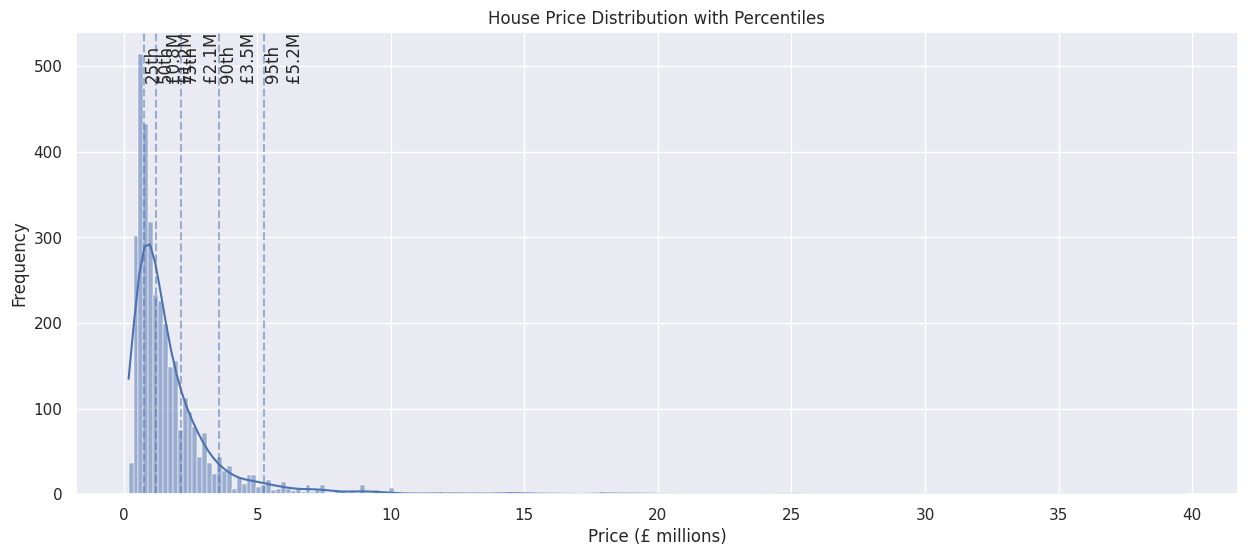

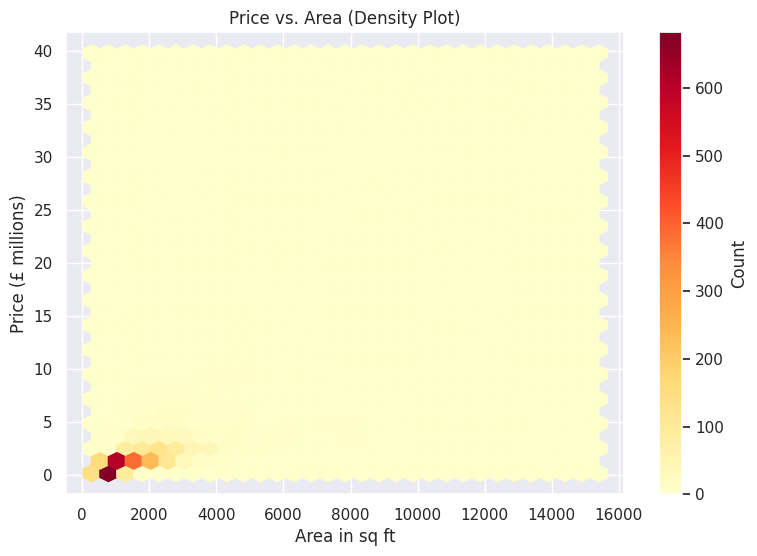

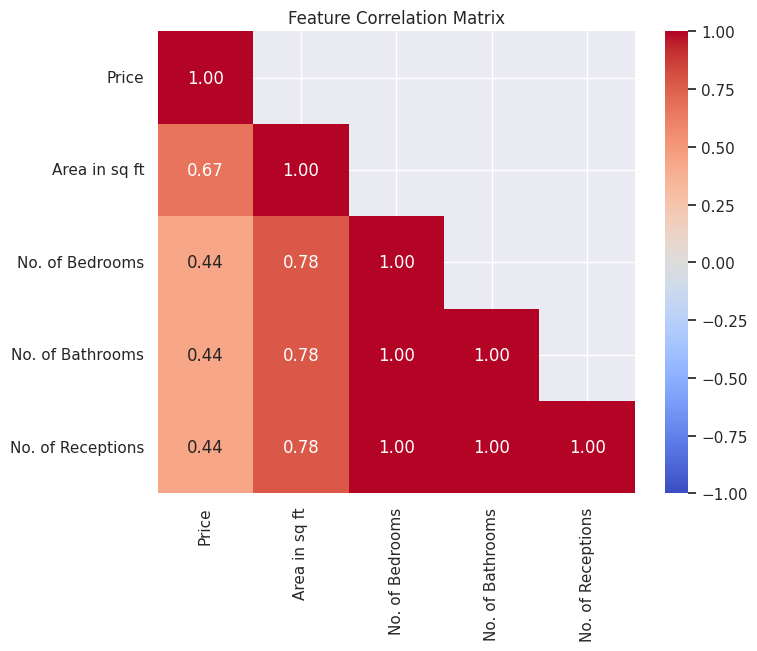

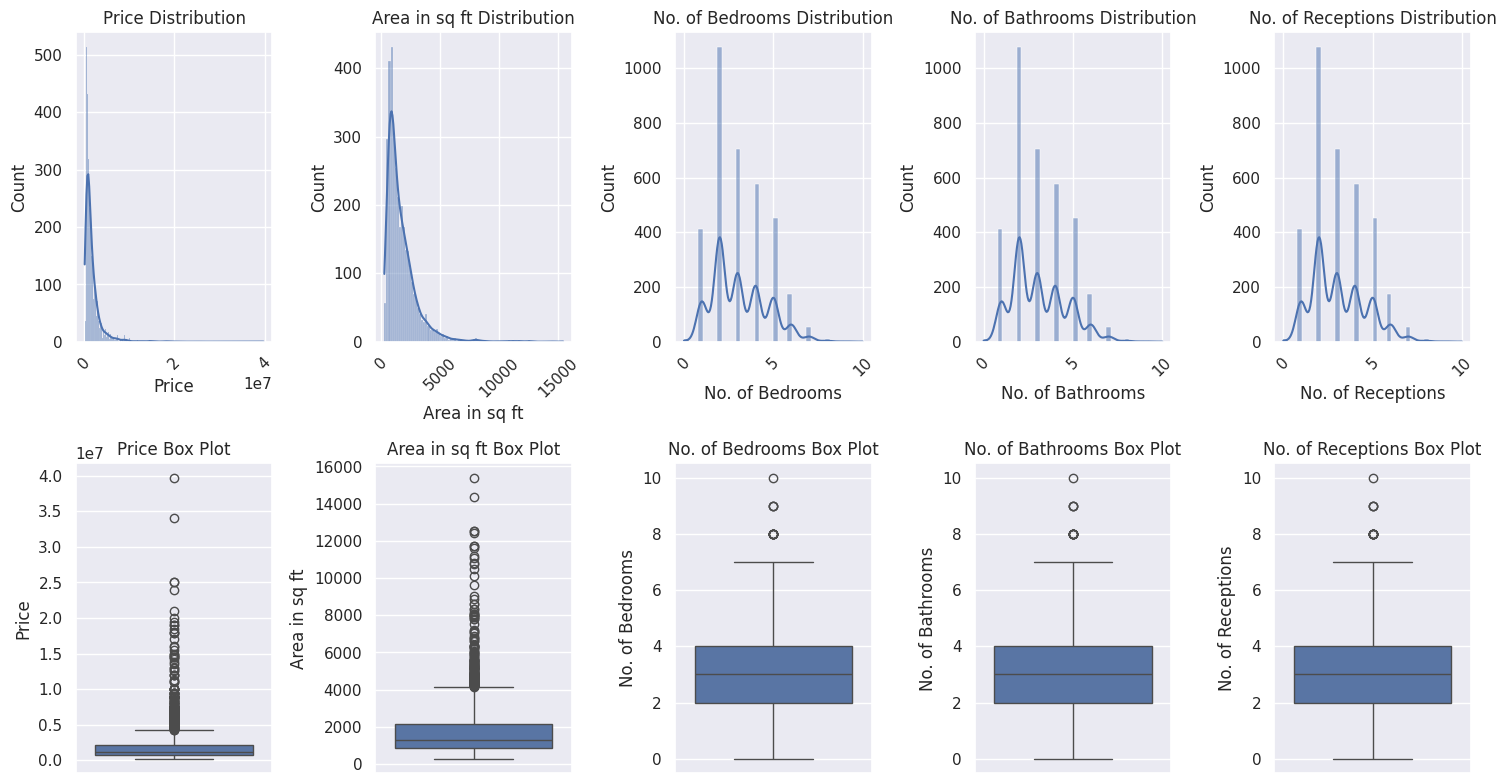


Categorical Feature Summary:

House Type:
Unique values: 8
Missing values: 0 (0.0%)
Top category share: 45.0%
Top 3 categories cover: 96.3%


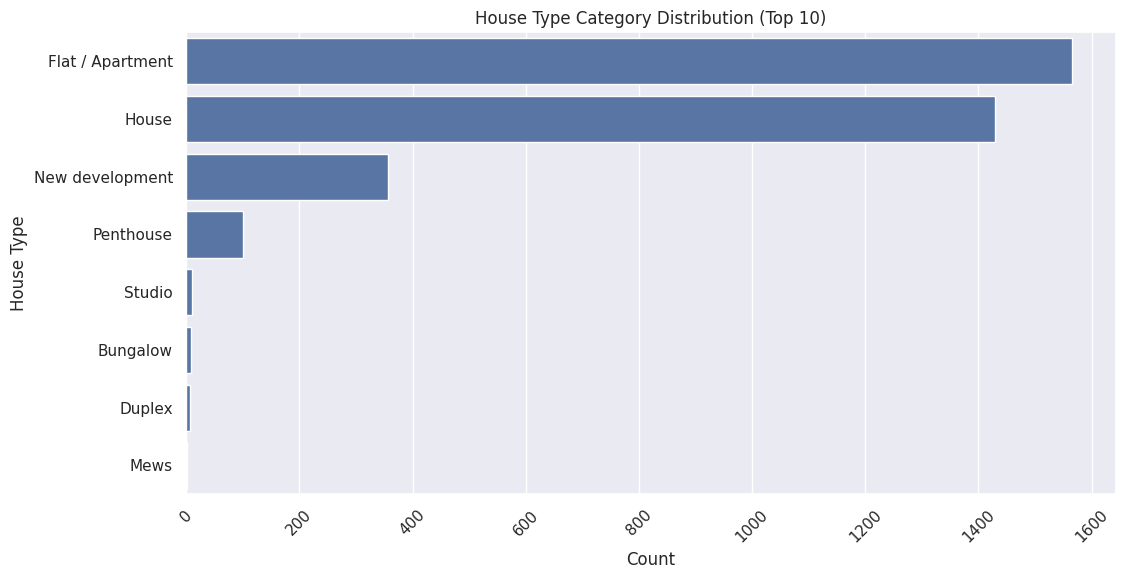


Location:
Unique values: 656
Missing values: 962 (27.6%)
Top category share: 2.8%
Top 3 categories cover: 6.8%

Top 10 categories and their frequencies:
Location
Putney        96
Barnes        71
Wandsworth    70
Wimbledon     68
Esher         64
Chiswick      57
Richmond      57
Islington     52
Battersea     51
Northwood     43
Name: count, dtype: int64

City/County:
Unique values: 57
Missing values: 0 (0.0%)
Top category share: 85.4%
Top 3 categories cover: 95.2%

Top 10 categories and their frequencies:
City/County
London             2972
Surrey              262
Middlesex            78
Essex                62
Twickenham           12
Hertfordshire         9
Thurleigh Road        7
N7 6QX                7
Fulham                5
Wornington Road       5
Name: count, dtype: int64

Postal Code:
Unique values: 2845
Missing values: 0 (0.0%)
Top category share: 0.4%
Top 3 categories cover: 1.0%

Top 10 categories and their frequencies:
Postal Code
SW6 3LF     14
SW6 1UE     12
SW15 2BS   

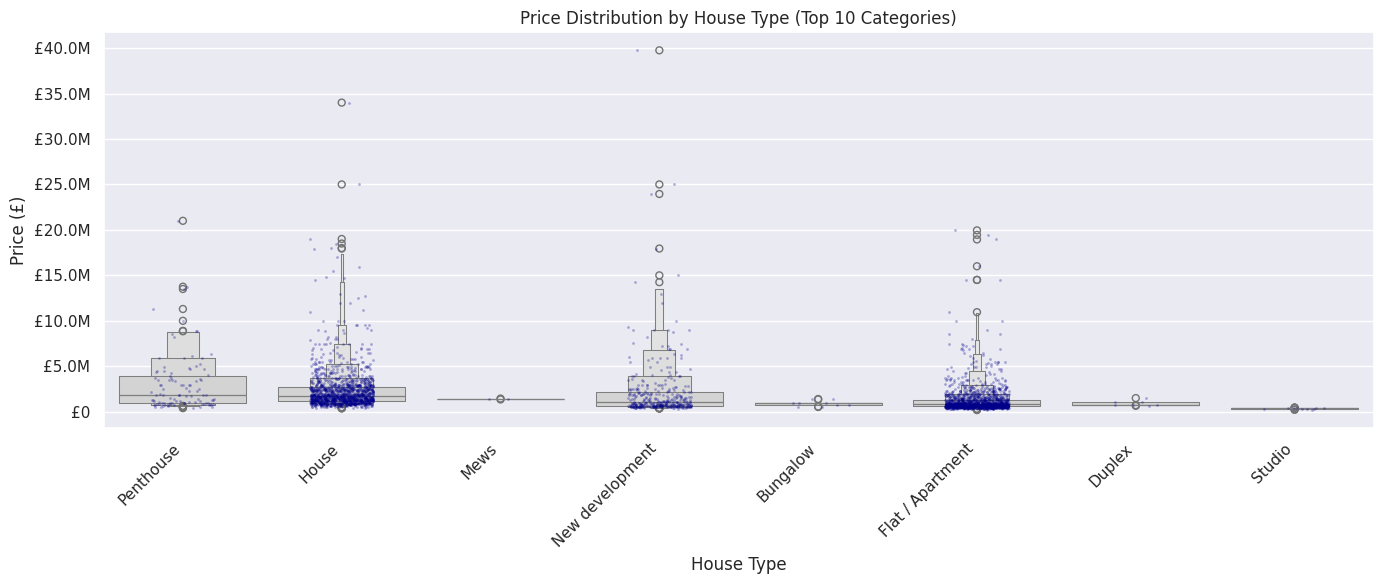


Top categories and their counts:
Hampstead Heath: 1 properties
30 Montpelier Walk: 1 properties
25 Cork Street: 1 properties
St Johns Wood: 2 properties
Regents Park: 1 properties


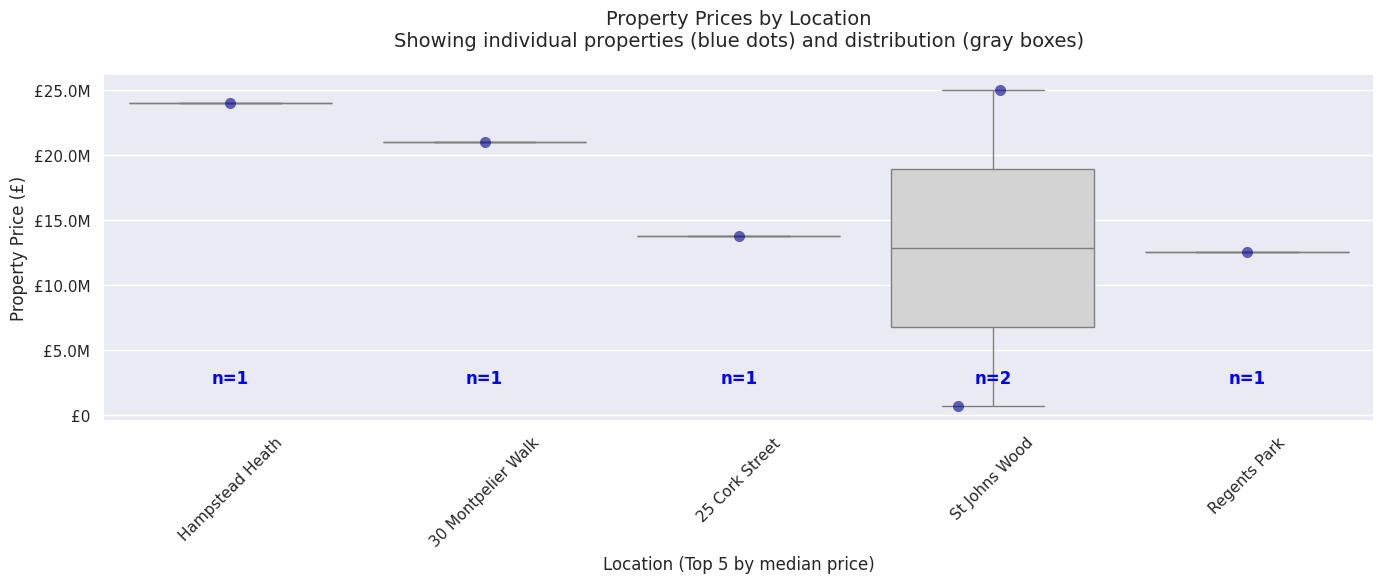


Top categories and their counts:
Oxshott: 1 properties
Fitzrovia: 1 properties
Marylebone: 4 properties
Lillie Square: 1 properties
Middx: 1 properties


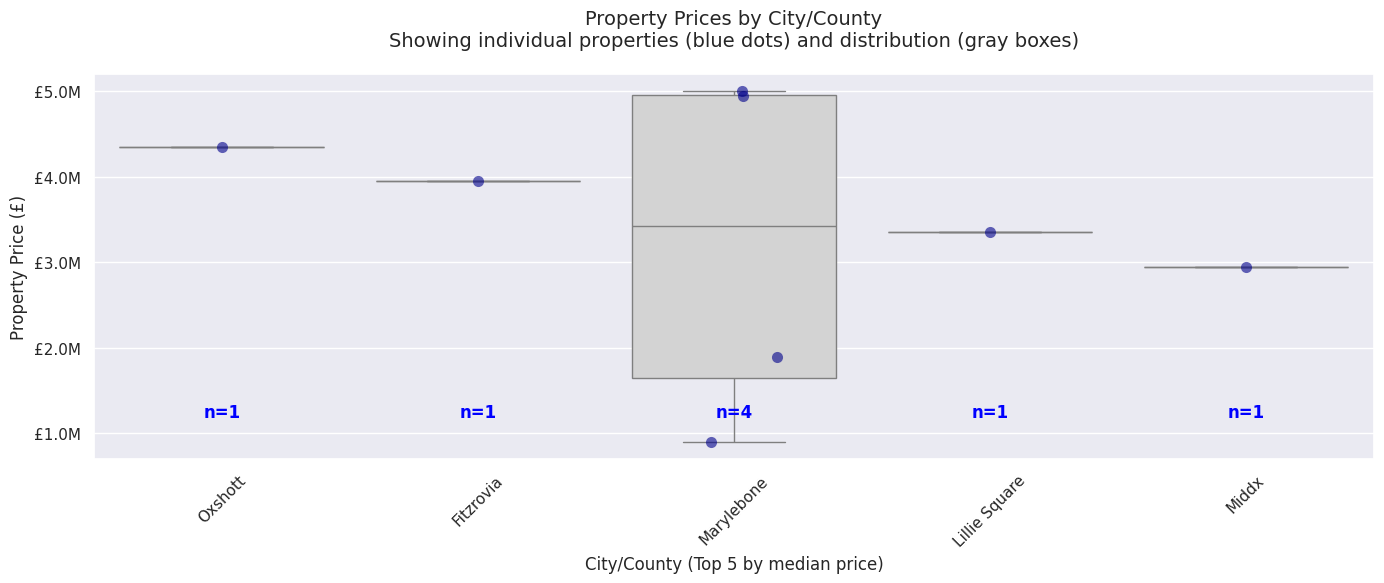


Top categories and their counts:
SW1A 1LP: 1 properties
NW11: 1 properties
SW7 1JF: 1 properties
W1K 7AJ: 1 properties
SW1X 8RN: 1 properties


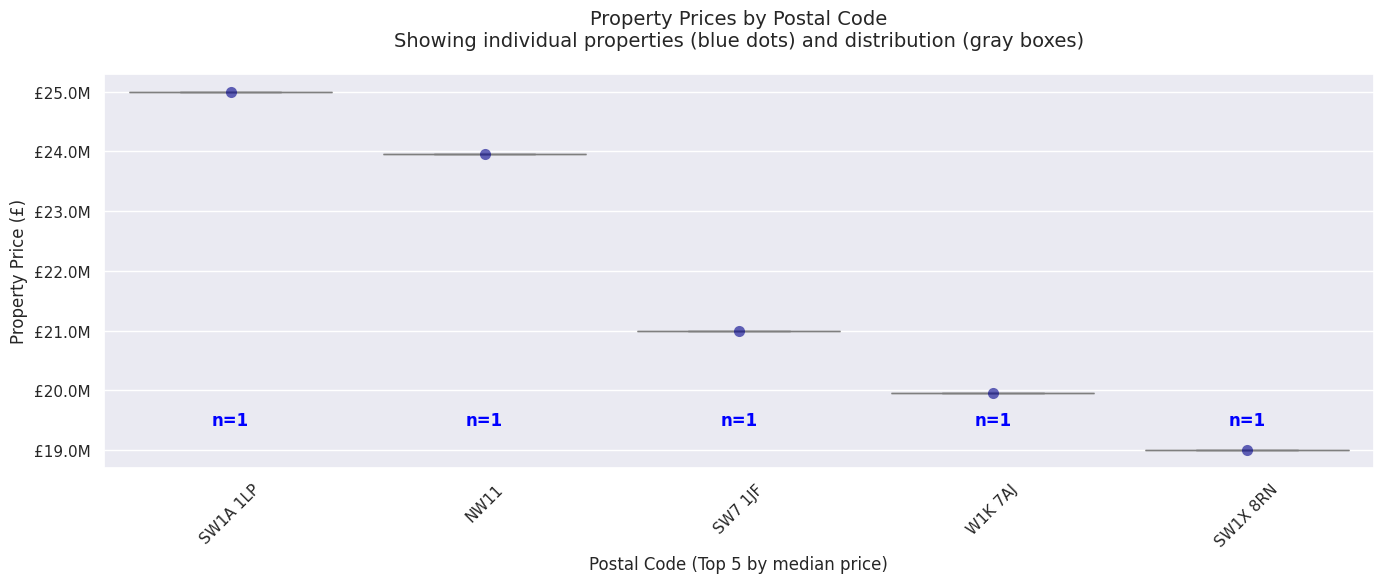

In [126]:
def explore_data(df):
    """Comprehensive EDA combining numeric and categorical insights"""
    print("\nNumeric feature summary:")
    numeric_summary = df.select_dtypes(include=[np.number]).describe()
    numeric_summary.loc['skew'] = df.select_dtypes(include=[np.number]).skew()
    numeric_summary.loc['kurtosis'] = df.select_dtypes(include=[np.number]).kurtosis()
    print(numeric_summary)

    analyse_numeric_features(df)
    analyse_categorical_features(df)
    analyse_price_by_categories(df)

def analyse_numeric_features(df):
    """Analyse numeric features with detailed distribution insights"""
    # Price distribution with percentile annotations
    plt.figure(figsize=(15,6))
    ax = sns.histplot(df['Price']/1000000, kde=True)
    percentiles = np.percentile(df['Price']/1000000, [25, 50, 75, 90, 95])
    for p, label in zip(percentiles, ['25th', '50th', '75th', '90th', '95th']):
        plt.axvline(p, linestyle='--', alpha=0.5)
        plt.text(p, plt.ylim()[1]*0.9, f'{label}\n£{p:.1f}M', rotation=90)
    plt.title('House Price Distribution with Percentiles')
    plt.xlabel('Price (£ millions)')
    plt.ylabel('Frequency')
    plt.show()

    # Area vs Price with density coloring
    plt.figure(figsize=(9,6))
    plt.hexbin(df['Area in sq ft'], df['Price']/1000000,
              gridsize=30, cmap='YlOrRd')
    plt.colorbar(label='Count')
    plt.title('Price vs. Area (Density Plot)')
    plt.xlabel('Area in sq ft')
    plt.ylabel('Price (£ millions)')
    plt.show()

    # Numeric correlations with detailed statistics
    numeric_cols = ['Price', 'Area in sq ft', 'No. of Bedrooms',
                   'No. of Bathrooms', 'No. of Receptions']

    # Correlation analysis
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(7.7,6))
    mask = np.triu(np.ones_like(corr_matrix), k=1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                mask=mask, vmin=-1, vmax=1, center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

    # Distribution profiles for all numeric features
    fig, axes = plt.subplots(2, len(numeric_cols), figsize=(15, 8))
    for idx, col in enumerate(numeric_cols):
        # Histogram
        sns.histplot(df[col], kde=True, ax=axes[0, idx])
        axes[0, idx].set_title(f'{col} Distribution')
        axes[0, idx].tick_params(axis='x', rotation=45)

        # Box plot
        sns.boxplot(y=df[col], ax=axes[1, idx])
        axes[1, idx].set_title(f'{col} Box Plot')
    plt.tight_layout()
    plt.show()

def analyse_categorical_features(df):
    """Analyse categorical features with cardinality and association metrics"""
    categorical_cols = ['House Type', 'Location', 'City/County', 'Postal Code']

    print("\nCategorical Feature Summary:")
    for col in categorical_cols:
        print(f"\n{col}:")

        # Distribution statistics
        value_counts = df[col].value_counts()
        missing = df[col].isnull().sum()
        unique_count = df[col].nunique()

        print(f"Unique values: {unique_count}")
        print(f"Missing values: {missing} ({missing/len(df)*100:.1f}%)")
        print(f"Top category share: {value_counts.iloc[0]/len(df)*100:.1f}%")
        print(f"Top 3 categories cover: {value_counts.iloc[:3].sum()/len(df)*100:.1f}%")

        # Category frequency visualisation
        if unique_count <= 15:
            plt.figure(figsize=(12,6))
            sns.barplot(x=value_counts.values[:10],
                       y=value_counts.index[:10])
            plt.title(f'{col} Category Distribution (Top 10)')
            plt.xlabel('Count')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"\nTop 10 categories and their frequencies:")
            print(value_counts.head(10))

def analyse_price_by_categories(df):
    """Analyse price distributions across categorical features"""
    categorical_cols = ['House Type', 'Location', 'City/County', 'Postal Code']

    for col in categorical_cols:
        # Calculate statistics and sort by median price
        stats = (df.groupby(col)['Price']
                .agg(['count', 'mean', 'median', 'std'])
                .sort_values('median', ascending=False))

        # For categories with many unique values, show top 5
        if df[col].nunique() > 20:
            plt.figure(figsize=(14, 6))

            # Get top 5 categories by median price
            top_stats = stats.head(5)
            top_cats = top_stats.index.tolist()  # Convert to list for proper indexing

            # Filter data for top categories
            data = df[df[col].isin(top_cats)]

            # Create box plot
            sns.boxplot(x=col, y='Price', data=data, color='lightgray', order=top_cats)

            # Add scatter points
            sns.stripplot(x=col, y='Price', data=data,
                         size=8, color='darkblue', alpha=0.6,
                         jitter=0.2, order=top_cats)

            # Print debugging information
            print("\nTop categories and their counts:")
            for cat in top_cats:
                count = len(data[data[col] == cat])
                print(f"{cat}: {count} properties")

            # Draw the plot to establish limits
            plt.draw()

            # Get axis limits
            ymin, ymax = plt.ylim()

            # Add count labels with consistent positioning
            for i, cat in enumerate(top_cats):
                count = len(data[data[col] == cat])
                # Position text higher up from the bottom
                text_y = ymin + (ymax - ymin) * 0.1
                plt.text(i, text_y, f'n={count}',
                        ha='center', va='bottom',
                        color='blue', fontweight='bold')

            plt.title(f'Property Prices by {col}\nShowing individual properties (blue dots) and distribution (gray boxes)',
                     pad=20, fontsize=14)
            plt.xlabel(f'{col} (Top 5 by median price)')
            plt.ylabel('Property Price (£)')
            plt.xticks(rotation=45)

            # Format price axis
            format_price_axis(plt.gca().yaxis)

            # Adjust layout to prevent label cutoff
            plt.tight_layout()
            plt.show()
        else:
            # Original code for categories with fewer unique values
            plt.figure(figsize=(14, 6))
            top_cats = stats.head(10).index.tolist()
            data = df[df[col].isin(top_cats)]

            sns.boxenplot(x=col, y='Price', data=data, color='lightgray', order=top_cats)
            sns.stripplot(x=col, y='Price', data=data,
                         size=2, alpha=0.3, jitter=0.2, color='darkblue',
                         order=top_cats)

            plt.xticks(rotation=45, ha='right')
            plt.title(f'Price Distribution by {col} (Top 10 Categories)')
            plt.ylabel('Price (£)')
            format_price_axis(plt.gca().yaxis)
            plt.tight_layout()
            plt.show()

def format_price_axis(axis):
    """Format price axis to millions with K/M suffixes"""
    def price_format(x, p):
        if x >= 1e6:
            return f'£{x/1e6:.1f}M'
        elif x >= 1e3:
            return f'£{x/1e3:.0f}K'
        return f'£{x:.0f}'

    axis.set_major_formatter(ticker.FuncFormatter(price_format))

# Run the full analysis
explore_data(df)

### Exploratory data analysis discussion

When people buy houses, they follow a systematic evaluation process - examining location, size, and comparative prices.

Our data reveals this same process, but with statistical patterns that profoundly impact our modeling approach.

#### Price distribution dynamics

Our price distribution spans from £180,000 to £39,750,000 - a 222-fold range that reveals fundamental market mechanics.

This distribution segments into distinct market components:

- Entry-level flats (median £800,000, CV: 0.25)
- Mid-market new developments (median £1.05M, CV: 1.61)
- Premium houses (median £1.75M, CV: 0.96)
- Ultra-premium properties (>£17.95M, concentrated in SW1, NW11, SW7)

The Coefficient of Variation (CV) tells a fascinating story: new developments show the highest volatility (1.61), while studios exhibit remarkable price consistency (0.25). This pattern isn't random - it reflects how different property types respond to market forces.

Key implication: We need logarithmic price transformation because price impacts are multiplicative, not additive. A 10% improvement adds £80,000 to an £800,000 flat but £175,000 to a £1.75M house.

#### Price per square foot analysis

Price per square foot reveals another layer of market dynamics:
- Overall median: £850/sq ft
- Geographic variation: £450/sq ft (outer postcodes) to £2,200/sq ft (prime central)
- Property type impact:
  - Flats: £750-900/sq ft (higher density areas)
  - Houses: £600-1,500/sq ft (wider variation due to land value)
  - Ultra-premium: >£3,000/sq ft (limited locations)

This metric provides crucial standardisation across property sizes but shows significant geographic dependence, suggesting value in calculating local area benchmarks.

#### Location's hierarchical structure

Our location data forms a three-tier hierarchy with distinct statistical properties:

1. Administrative level
   - London dominates (85.4% of properties)
   - Surrey represents 7.5%
   - Statistical challenge: Surrey sample size limits generalisability

2. Neighborhood level (n=656)
   - 27.6% missing data
   - Highest frequency: Putney at 2.8%
   - Severe fragmentation: median frequency <0.2%

3. Postal code level (n=2,845)
   - Complete coverage but extreme fragmentation
   - Maximum frequency: 0.4%
   - Systematic structure through outcodes

This hierarchy presents two potential encoding paths: one-hot encoding for direct categorical relationships, or target encoding to capture price-level relationships. Each has distinct advantages we'll explore in our processing approach.

#### Data quality analysis

Two critical quality issues demand attention:

1. Room counts
   - Perfect correlation (ρ = 1.0) between bedroom, bathroom, and reception counts
   - Identical means (μ = 3.10) across all three measures
   - Statistically impossible in real properties
   - Implications: Must select single room metric as proxy for size

2. Feature reliability assessment
   - Area (sq ft): Strongest predictor (r = 0.67 with price)
   - Property identifiers: Unique per observation, zero information content
   - Location strings: Require standardisation (27.6% missing, inconsistent formatting)

#### Methodological implications

These patterns suggest several modeling approaches:

1. Price treatment
   - Log transformation required for multiplicative effects
   - Stratified sampling across price bands essential
   - Performance metrics must consider relative errors

2. Geographic features
   - Two viable encoding approaches:
     - One-hot encoding for direct categorical relationships
     - Target encoding to capture price-level relationships
   - Outcode extraction offers useful intermediate granularity
   - Missing data requires careful handling (27.6% at neighborhood level)

3. Size and value metrics
   - Area (sq ft) as primary metric
   - Single room count as secondary proxy
   - Price per square foot as standardised comparison
   - Local area benchmarks for relative value assessment

4. Validation strategy
   - Stratified cross-validation across price bands
   - Separate performance metrics for market segments
   - Coefficient of Variation monitoring per segment
   - Validation of both encoding approaches

This analysis establishes our statistical requirements: we need precise handling of multiplicative price effects, careful feature encoding choices, and rigorous cross-segment validation. The next section translates these requirements into a systematic data processing pipeline.

## Data processing strategy

Our exploratory analysis revealed the fundamental mechanics of London's housing market - multiplicative price effects spanning a 222-fold range and a natural geographic hierarchy that profoundly influences values. Translating these insights into a robust processing pipeline requires careful attention to the order of operations, particularly regarding price information.

The path from raw data to modeling features follows five essential stages:
1. Data validation & cleaning
2. Preliminary feature engineering
3. Price distribution transformation
4. Stratified data splitting
5. Feature encoding and target-variable-aware feature engineering

The sequence is crucial for statistical validity.

### Core Processing Steps

1. **Data validation & cleaning**

   Address the data quality issues identified in our exploration:
   - Remove redundant room features (correlation coefficient ρ = 1.0)
   - Standardise location strings (27.6% missing, requires structured handling)
   - Clean city/county values (systematic geographic normalisation)
   - Preserve fundamental numeric features in original form

2. **Initial feature engineering**

   Our geographic hierarchy analysis suggests immediate structural features:
   - Extract outcodes from postal codes (geographic aggregation)
   - This transformation is price-independent, based purely on postal code structure
   - Creates intermediate geographic granularity
   - Establishes foundation for later feature encoding comparisons

3. **Price distribution transformation**

   Address the multiplicative nature of price variations:
   - Apply logarithmic transformation (normalises 222-fold range)
   - Generate price bands for stratification
   - Enables proper handling of multiplicative price effects

4. **Train/test split**

   To maintain statistical validity we need to:
   - Implement stratified sampling using price bands - similar to how we balanced benigh vs malignant in lesson 1
   - Check geographic distribution is preserved
   - Establish a truly independent test set

5. **Feature encoding and target-variable-aware feature engineering**

   Post-split transformations requiring careful handling of price information:

   A. One-Hot encoding (categorical to binary features)
   - Convert house type to set of binary indicator columns
   - Transform city/county to binary indicator columns
   - Create outcode binary indicator columns
   - Maintains complete independence from price variable

   B. Target encoding (price-based location encoding)
   - Hierarchical encoding: outcode → postcode → location
   - Calculate encoding means using only training data
   - Implement prior smoothing for stability
   - Store training means for future predictions
   - Handle missing values through hierarchy

   C. Mean outcode price per square foot
   - Calculate using only training data statistics
   - Apply stored training means to test data
   - Persist training means for new predictions
   - Maintain strict statistical separation

### Statistical validity through ordering

Consider the fundamental difference between structure-based and price-dependent outcode features:
```python
# Structure-based: Valid pre-split
df['outcode'] = df['postcode'].str.extract('^([A-Z]+)')
df['outcode_SW1'] = (df['outcode'] == 'SW1').astype(int)

# Price-dependent: Requires careful post-split handling
outcode_means = train_data.groupby('outcode')['price'].mean()
train_data['outcode_price'] = train_data['outcode'].map(outcode_means)
test_data['outcode_price'] = test_data['outcode'].map(outcode_means)  # Uses training means only
```

This pipeline will create two parallel feature sets - one using one-hot encoding and another using target encoding - allowing us to compare their effectiveness while maintaining statistical validity. Each transformation preserves the insights from our exploratory analysis while ensuring proper separation of price information between training and test data.

The essence of this approach is maintaining statistical rigor through proper sequencing: we can create structural features immediately, but any feature using price information must be created post-split using only training data statistics. These training-derived values must then be persisted for consistent application to both test data and future predictions.

Let's proceed with implementing each stage of this carefully ordered pipeline.

## Data validation

Let's check our data before cleaning it.

We'll check the shape of the data and the first few rows, and then print the data types and value ranges for each column.

In [127]:
print('Data shape before cleaning:', df.shape)
display(df)

# Check for missing values
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)

# Check that all rows have the expected number of columns
expected_columns = len(df.columns)
rows_with_missing_cols = df.shape[1] != expected_columns
if rows_with_missing_cols:
    print(f"\nWARNING: Some rows are missing columns. Expected {expected_columns} columns.")
else:
    print(f"\nAll rows have the expected {expected_columns} columns.")

# Print the data types and value ranges for each column
print("\nData types and value ranges for each column:\n")

for column in df.columns:
    print(f"\n{column}:")
    if df[column].dtype in ['int64', 'float64']:
        print(f"Type: {df[column].dtype}")
        print(f"Range: {df[column].min():,.2f} to {df[column].max():,.2f}")
        print(f"Mean: {df[column].mean():,.2f}")
    else:
        print(f"Type: {df[column].dtype}")
        print("Categories:")
        value_counts = df[column].value_counts()
        for value, count in value_counts.items():
            print(f"  - {value}: {count:,} occurrences")

# Check for potential misspellings in Location categories by sorting alphabetically
print("\nUnique location values (sorted alphabetically):")
locations = df['Location'].value_counts().dropna()
sorted_locations = sorted(locations.items(), key=lambda x: str.lower(x[0]))
for loc, count in sorted_locations:
    print(f"  - {loc}: {count} occurrences")


Data shape before cleaning: (3480, 10)


,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL
...,...,...,...,...,...,...,...,...,...,...
3475,One Lillie Square,3350000,New development,1410,3,3,3,NaN,Lillie Square,SW6 1UE
3476,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT
3477,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG
3478,Cork Street,6300000,New development,1506,3,3,3,Mayfair,London,W1S 3AR



Checking for missing values:
Property Name          0
Price                  0
House Type             0
Area in sq ft          0
No. of Bedrooms        0
No. of Bathrooms       0
No. of Receptions      0
Location             962
City/County            0
Postal Code            0
dtype: int64

All rows have the expected 10 columns.

Data types and value ranges for each column:


Property Name:
Type: object
Categories:
  - Television Centre: 17 occurrences
  - City Road: 14 occurrences
  - Bishops Gate: 14 occurrences
  - Eaton Square: 11 occurrences
  - Junction House: 8 occurrences
  - Manor Road: 8 occurrences
  - Queens Road: 7 occurrences
  - Boat Race House: 7 occurrences
  - New Road: 7 occurrences
  - Church Road: 7 occurrences
  - Rutland Gate: 7 occurrences
  - Castelnau: 7 occurrences
  - Basilica Mews: 7 occurrences
  - Carlton House: 7 occurrences
  - Buckingham Gate: 7 occurrences
  - Barmouth Road: 7 occurrences
  - Chiswick High Road: 7 occurrences
  - Hamilton Terrace: 7

 ## Data cleaning

 From our exploratory data analysis and the validation above we've identified some data quality issues that we'll need to clean up.

 1. 'Property Name' - in this lesson we won't attempt to infer meaning from the property name so lets drop this column.

 2. 'No. of Bathrooms' and 'No. of Receptions'
     - These two features are redundant as they are perfect correlated with bedrooms, there is an error in the data collection here so we'll choose only bedrooms
     - We'll also convert 0 bedrooms to 1 as studios are a bedroom!
     - Both these issues bring into question the quality of the data but for now we'll proceed
     - In a production setting we would need to investigate this further, being more careful about making assumptions and not just take any dataset off Kaggle at face value ;)

 3. Location values are not consistent, they have missing values and are highly cardinal/fragmented:
     - Consisting of a mix of full and partial address first lines & borough and area names  
     - Inconsistent whitespace, special characters and leading numbers

 4. City/county level data is complete but has some strange values:
     - The City of London, London and main surrounding counties are represented
     - 96 values in this column are not counties or regions but are instead a mix of neighbourhoods, area and district names
     - This may be a data parsing error when splitting the address into lines

 5. On the plus side our postcode level data is gorgeous!
     - 2,845 unique codes
     - No missing values
     - All valid UK postcodes
     - Extremely granular
     - Hierarchical structure potential
     - Opportunity to create derived feature such as postcode outcode
   
Lets clean these up!

In [128]:
# Remove redundant features
df_updated_columns = df.drop(['Property Name', 'No. of Bathrooms', 'No. of Receptions'], axis=1)

print(f"Shape after cleaning: {df_updated_columns.shape}")
display(df_updated_columns.head())

Shape after cleaning: (3480, 7)


,Price,House Type,Area in sq ft,No. of Bedrooms,Location,City/County,Postal Code
0,1675000,House,2716,5,Wimbledon,London,SW19 8NY
1,650000,Flat / Apartment,814,2,Clerkenwell,London,EC1V 3PA
2,735000,Flat / Apartment,761,2,Putney,London,SW15 1QL
3,1765000,House,1986,4,Putney,London,SW15 1LP
4,675000,Flat / Apartment,700,2,Putney,London,SW15 1PL


In [129]:
df_with_transformed_bedrooms = df_updated_columns.copy()
# Convert 0 bedrooms to 1 - studios are a bedroom!
df_with_transformed_bedrooms.loc[df_with_transformed_bedrooms['No. of Bedrooms'] == 0, 'No. of Bedrooms'] = 1

df_with_clean_counties = df_with_transformed_bedrooms.copy()
# Clean up City/County values
df_with_clean_counties['City/County'] = df_with_clean_counties['City/County'].str.lower().str.strip()

# Print NaN counts before cleaning
print("\nNaN counts before cleaning:")
print(f"Location NaN count: {df_updated_columns['Location'].isna().sum()}")

# Valid counties list
valid_counties = ['london', 'surrey', 'middlesex', 'essex', 'hertfordshire', 'kent', 'city of london']

# Postcode outcode to county mapping
postcode_to_county = {
    'E': 'london',
    'EC': 'city of london',
    'N': 'london',
    'NW': 'london',
    'SE': 'london',
    'SW': 'london',
    'W': 'london',
    'WC': 'london',
    'KT': 'surrey',
    'CR': 'surrey',
    'IG': 'essex',
    'CM': 'essex',
    'EN': 'hertfordshire',
    'WD': 'hertfordshire',
    'HA': 'hertfordshire',
    'TW': 'middlesex',
    'UB': 'middlesex'
}

# Store original values for reporting
original_locations = df_with_clean_counties['Location'].copy()
original_cities = df_with_clean_counties['City/County'].copy()

# Create new df
df_clean_counties_and_updated_locations = df_with_clean_counties.copy()

# Find rows where City/County is not in valid counties
invalid_counties_mask = ~df_clean_counties_and_updated_locations['City/County'].isin(valid_counties)

# Array to store rows where location updates should be skipped
skip_location_updates = [
    # Add row numbers here where location should not be overwritten because it didn't make sense to update the location with the city value
    193, 444, 1007, 1290, 1388, 1481, 1502, 1503, 1914, 3154, 3422
]

city_updates = 0
location_updates = 0

if invalid_counties_mask.any():
    # For these rows, get their outcodes
    invalid_rows = df_clean_counties_and_updated_locations[invalid_counties_mask]
    outcodes = invalid_rows['Postal Code'].str.extract('^([A-Z]+)')[0]
    new_counties = outcodes.map(postcode_to_county)

    # Update only rows where the City/County needs to change
    for idx in invalid_rows.index:
        current_county = df_clean_counties_and_updated_locations.loc[idx, 'City/County']
        new_county = new_counties[idx]

        if current_county != new_county:
            # Only update location if row is not in skip list
            if idx not in skip_location_updates:
                df_clean_counties_and_updated_locations.loc[idx, 'Location'] = current_county  # Save old county as location
                location_updates += 1
            df_clean_counties_and_updated_locations.loc[idx, 'City/County'] = new_county   # Always update county
            city_updates += 1

# Print NaN counts after cleaning
print("\nNaN counts after cleaning:")
print(f"Location NaN count: {df_clean_counties_and_updated_locations['Location'].isna().sum()}")

print(f"\nTotal number of city/county updates: {city_updates}")
print(f"Total number of location updates (accounting for skipped rows): {location_updates}")

# Create update report only for rows that changed
updates = pd.DataFrame({
    'Original Location': original_locations,
    'Original City/County': original_cities,
    'New Location': df_clean_counties_and_updated_locations['Location'],
    'New City/County': df_clean_counties_and_updated_locations['City/County'],
    'Postcode': df_clean_counties_and_updated_locations['Postal Code']
})

# Show only rows where actual changes occurred
updates = updates[
    ((updates['Original Location'] != updates['New Location']) & ~(updates['Original Location'].isna() & updates['New Location'].isna())) |
    (updates['Original City/County'] != updates['New City/County'])
]

print("\nLocation updates:")
print(updates.to_string())

print("\nFirst 5 rows of cleaned dataset:")
print(df_clean_counties_and_updated_locations.head().to_string())


NaN counts before cleaning:
Location NaN count: 962

NaN counts after cleaning:
Location NaN count: 916

Total number of city/county updates: 94
Total number of location updates (accounting for skipped rows): 83

Location updates:
          Original Location      Original City/County              New Location New City/County  Postcode
16                      NaN                twickenham                twickenham       middlesex   TW1 2PF
19                      NaN              holland park              holland park          london   W11 4SR
41                      NaN                 battersea                 battersea          london  SW11 3DU
53               Downs Road                   clapton                   clapton          london    E5 8DS
131      The Otto Buildings                downs road                downs road          london    E5 8DS
177                     NaN            thurleigh road            thurleigh road          london  SW12 8UF
193                 Clapto

In [130]:
# Create new dataframe with cleaned data
df_cleaned = df_clean_counties_and_updated_locations.copy()

# Count unique locations before cleaning
unique_locations_before = df_cleaned['Location'].nunique()
print(f"\nNumber of unique locations before cleaning: {unique_locations_before}")

# Clean up Location column
def clean_location(x):
    if not isinstance(x, str):
        return x

    # Convert to lowercase and strip whitespace
    x = x.lower().strip()

    # Remove special characters and extra spaces
    x = re.sub(r'[^\w\s-]', '', x)
    x = re.sub(r'\s+', ' ', x)

    # Remove leading numbers and hyphens (e.g., "161-", "35-37", "131-143")
    x = re.sub(r'^\d+(?:-\d+)?\s*', '', x)

    # Remove any single letter followed by space at start
    x = re.sub(r'^[a-z]\s+', '', x)

    return x.strip()

df_cleaned['Location'] = df_cleaned['Location'].apply(clean_location)

# Count unique locations after cleaning
unique_locations_after = df_cleaned['Location'].nunique()
print(f"Number of unique locations after cleaning: {unique_locations_after}")
print(f"Reduction in unique locations: {unique_locations_before - unique_locations_after}")

print("\nUnique location values after cleaning (sorted alphabetically):")
locations = df_cleaned['Location'].value_counts().dropna()
sorted_locations = sorted(locations.items(), key=lambda x: str.lower(x[0]))
for loc, count in sorted_locations:
    print(f"  - {loc}: {count} occurrences")

print("\nFirst few rows of cleaned dataframe:")
display(df_cleaned.head())


Number of unique locations before cleaning: 674
Number of unique locations after cleaning: 511
Reduction in unique locations: 163

Unique location values after cleaning (sorted alphabetically):
  - abbey road: 4 occurrences
  - abercorn place: 1 occurrences
  - aberdeen park: 1 occurrences
  - acton: 6 occurrences
  - albany street: 1 occurrences
  - albert bridge road: 5 occurrences
  - albert embankment: 3 occurrences
  - aldgate: 1 occurrences
  - alexandra avenue: 1 occurrences
  - approach road: 1 occurrences
  - arlington road: 1 occurrences
  - arnhem place: 1 occurrences
  - arterberry road: 1 occurrences
  - asher way: 3 occurrences
  - ashtead: 1 occurrences
  - ashton reach: 1 occurrences
  - atalanta street: 1 occurrences
  - augustas lane: 2 occurrences
  - avenue road: 1 occurrences
  - balham: 2 occurrences
  - balham high road: 2 occurrences
  - banbury road: 2 occurrences
  - banstead: 1 occurrences
  - barbican: 1 occurrences
  - barnes: 81 occurrences
  - barnsbury:

,Price,House Type,Area in sq ft,No. of Bedrooms,Location,City/County,Postal Code
0,1675000,House,2716,5,wimbledon,london,SW19 8NY
1,650000,Flat / Apartment,814,2,clerkenwell,london,EC1V 3PA
2,735000,Flat / Apartment,761,2,putney,london,SW15 1QL
3,1765000,House,1986,4,putney,london,SW15 1LP
4,675000,Flat / Apartment,700,2,putney,london,SW15 1PL


Great! We've cleaned up our data.

Columns are now:
- Price
- House Type
- Area in sq ft
- No. of Bedrooms
- Location
- City/County
- Postal Code

Parsing the city field for misplaced location values has reduced the NaN values in the location field from 962 to 916

This parsing updated 94 city/counties and 83 location values - accounting for skipped rows, where it didn't make sense to update the location with the city value.

The resultant location field has been cleaned up by making the values more consistently cased, removing property numbers and removing special characters and extra whitespace:

- Number of unique locations before cleaning: 674
- Number of unique locations after cleaning: 511
- Reduction in unique locations: 163

City/County has been cleaned up to a more consistent format of:
- London
- Surrey
- Middlesex
- Essex
- Hertfordshire
- Kent

We are now ready to move on to the next step of feature engineering, where we'll create derived features from the postcode field and price per area.


## Initial feature engineering

Before training our models, we can enhance our dataset through feature engineering - crafting new features that capture important patterns in the data. For London house prices, the challenge is creating features that reflect both physical property characteristics and location value.

### Key opportunities

1. **Geographic granularity**
   - Extract outcodes from postcodes (e.g., "SW6" from "SW6 3LF")
   - Create area/borough level statistics
   - Potential for linking external data:
     * School quality metrics
     * Transit accessibility
     * Crime statistics
     * Green space coverage
     * Local amenities

2. **Property value metrics**
   - Price per square foot
   - Room ratios
   - Local price benchmarks
   - Property type premiums

In this lesson, we'll focus on two foundational features:

#### 1. Postcode outcode
Our data shows 2,845 unique postcodes spread across 3,478 properties (1.22 properties per postcode) - too sparse for effective modeling. However, outcodes provide a sweet spot:
- More properties per area (better statistical power)
- Captures neighborhood-level price patterns
- Reduces feature dimensionality
- Enables reliable area statistics

#### 2. Price per square foot
This standardised metric requires careful handling:
- Must be calculated post train/test split
- Use only training data for statistics
- Apply same scaling to test data
- Handle outliers systematically

### Implementation strategy

We'll create these features in order of statistical safety:
1. First, outcodes (structure-based, no leakage risk)
2. Then price transformations (mathematical, no data dependencies)
3. Finally, price per square foot (requires careful train/test handling)

Let's start by extracting outcodes from our postal codes.

In [131]:
def extract_outcode(postcode: str) -> str:
    """Extract the outcode (first part) from a postcode."""
    return postcode.split()[0] if isinstance(postcode, str) else None

def add_outcode_feature(df: pd.DataFrame) -> pd.DataFrame:
    """Add outcode feature derived from Postal Code column."""
    df_with_outcode = df.assign(
        Outcode=df['Postal Code'].map(extract_outcode)
    )

    n_unique = df_with_outcode['Outcode'].nunique()
    avg_properties = len(df_with_outcode) / n_unique

    print(f"Created {n_unique} unique outcodes")
    print(f"Average properties per outcode: {avg_properties:.1f}")

    return df_with_outcode

# Apply to each of our cleaned datasets
df_with_outcode = add_outcode_feature(df_cleaned)

display(df_with_outcode)

print("\nTop 5 outcodes by average price:")
print(df_with_outcode.groupby('Outcode')['Price'].agg(['mean', 'count'])
      .sort_values('mean', ascending=False)
      .head())

# Save the DataFrame to a csv file
# df_with_outcode.to_csv('../data/df_with_outcode.csv', index=False)

Created 154 unique outcodes
Average properties per outcode: 22.6


,Price,House Type,Area in sq ft,No. of Bedrooms,Location,City/County,Postal Code,Outcode
0,1675000,House,2716,5,wimbledon,london,SW19 8NY,SW19
1,650000,Flat / Apartment,814,2,clerkenwell,london,EC1V 3PA,EC1V
2,735000,Flat / Apartment,761,2,putney,london,SW15 1QL,SW15
3,1765000,House,1986,4,putney,london,SW15 1LP,SW15
4,675000,Flat / Apartment,700,2,putney,london,SW15 1PL,SW15
...,...,...,...,...,...,...,...,...
3475,3350000,New development,1410,3,lillie square,london,SW6 1UE,SW6
3476,5275000,Flat / Apartment,1749,3,st jamess,london,SW1A 1JT,SW1A
3477,5995000,House,4435,6,hampstead garden suburb,london,NW11 6TG,NW11
3478,6300000,New development,1506,3,mayfair,london,W1S 3AR,W1S



Top 5 outcodes by average price:
                mean  count
Outcode                    
SW1A    8,942,857.14      7
W1K     8,936,764.71     17
W1S     7,400,000.00      7
NW11    6,262,772.22      9
SW1X    5,618,690.48     42


## Price transformation and price-aware feature engineering strategy

Our data contains both price-dependent and price-independent features that require different handling. Let's establish a clear strategy for each type.

### Price-independent features (can be created anytime)

1. **Outcode extraction** (Already completed)
   - Purely structural feature from postcodes
   - No price information used
   - Could have been created at any point

2. **One-Hot encoded Features**
   - House Type (8 categories)
   - City/County (6 categories)
   - Outcode (~100 categories)
   - Can be created before or after split
   - We'll create after split for code organisation

### Price-dependent Features (must wait for train/test split)

1. **Target encoded location features**
   - Outcode mean price encoding
   - Postcode encoding with outcode prior
   - Location encoding with postcode prior
   - Must use only training data means
   - Apply training means to test data

2. **Mean price per area features**
   - Mean price per sqft by outcode
   - Mean price per sqft by postcode
   - Use training data for calculations
   - Apply same means to test data

### Execution order

1. **Price distribution transformation**
   - Log transform prices
   - Create price bands for stratification
   - Enables balanced dataset splitting

2. **Train/test split**
   - Stratify using price bands
   - Ensures representative splits
   - Critical boundary for information flow

3. **Create all feature sets**
   - One-hot encoded version
     * Direct categorical relationships
     * No price information used
     * Sparse but interpretable

   - Target encoded version
     * Uses training price information
     * Hierarchical smoothing
     * Captures price-location relationships

   - Mean price per area version
     * Uses training data only
     * Outcode and postcode means
     * Area-normalised price signals

This strategy will create three parallel feature sets:
1. One-hot encoded (sparse, direct relationships)
2. Target encoded (smooth, hierarchical)
3. Price per area (standardised, interpretable)

We'll evaluate model performance on each to understand their relative strengths. Let's implement our strategy:

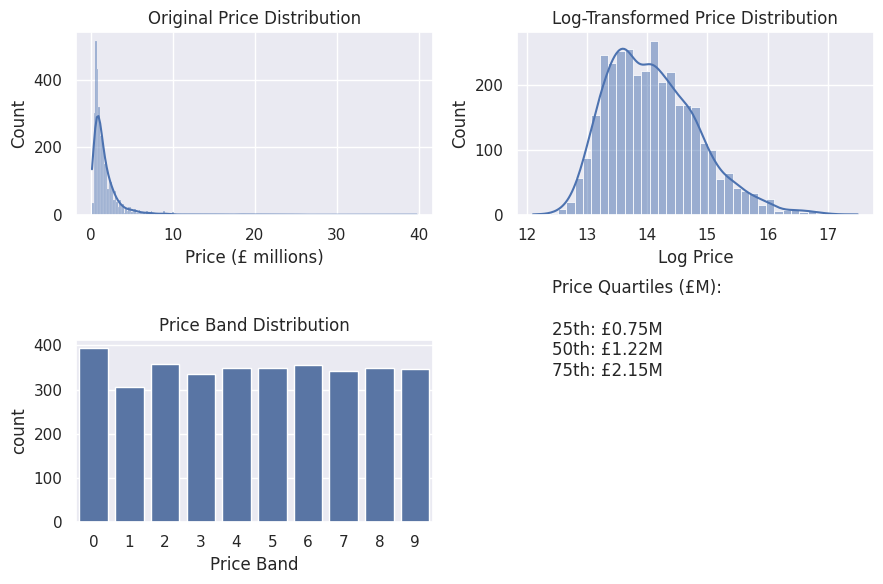


Price Distribution Summary:
              Price  log_price
count      3,480.00   3,480.00
mean   1,864,172.54      14.09
std    2,267,282.96       0.76
min      180,000.00      12.10
25%      750,000.00      13.53
50%    1,220,000.00      14.01
75%    2,150,000.00      14.58
max   39,750,000.00      17.50

Price Band Counts:
price_band
0    393
1    306
2    358
3    335
4    348
5    348
6    355
7    341
8    349
9    347
Name: count, dtype: int64


In [132]:
# Add log-transformed price
df_with_outcode['log_price'] = np.log(df_with_outcode['Price'])

# Create price bands for stratification
df_with_outcode['price_band'] = pd.qcut(df_with_outcode['log_price'], q=10, labels=False)

# Validation plots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Original price distribution
sns.histplot(df_with_outcode['Price']/1000000, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Original Price Distribution')
axs[0, 0].set_xlabel('Price (£ millions)')
axs[0, 0].ticklabel_format(style='plain', axis='x')

# Log-transformed price distribution
sns.histplot(df_with_outcode['log_price'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Log-Transformed Price Distribution')
axs[0, 1].set_xlabel('Log Price')

# Price band distribution
sns.countplot(x='price_band', data=df_with_outcode, ax=axs[1, 0])
axs[1, 0].set_title('Price Band Distribution')
axs[1, 0].set_xlabel('Price Band')

# Price percentiles
percentiles = np.percentile(df_with_outcode['Price']/1000000, [25, 50, 75])
axs[1, 1].text(0.1, 0.8, f'Price Quartiles (£M):\n\n25th: £{percentiles[0]:.2f}M\n50th: £{percentiles[1]:.2f}M\n75th: £{percentiles[2]:.2f}M',
               fontsize=12)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPrice Distribution Summary:")
print(df_with_outcode[['Price', 'log_price']].describe().round(2))

print("\nPrice Band Counts:")
print(df_with_outcode['price_band'].value_counts().sort_index())

Training Set Shape: (2784, 10)
Test Set Shape: (696, 10)


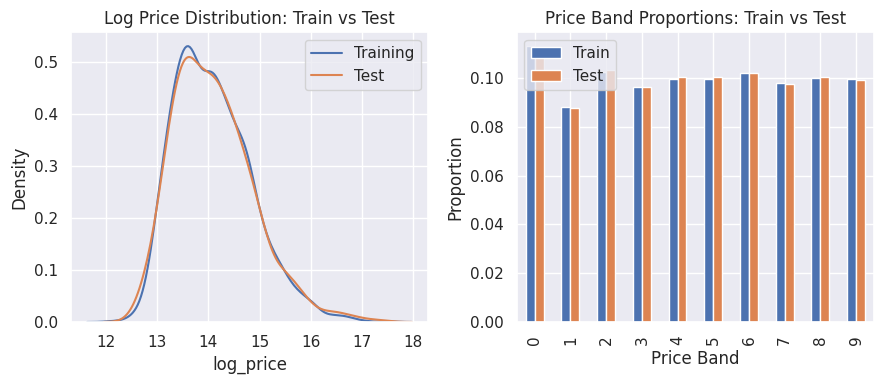


Outcode Distribution:
Training unique outcodes: 143
Test unique outcodes: 115
Missing outcodes: {'KT3', 'WC2N', 'NW10', 'WC1H', 'UB10', 'RM12', 'WC2H', 'KT21', 'SE15', 'EC2Y', 'SE13'}


In [133]:
# 80/20 stratified split using price bands
train_data, test_data = train_test_split(
    df_with_outcode,
    test_size=0.2,
    stratify=df_with_outcode['price_band'],
    random_state=RANDOM_STATE
)

print(f"Training Set Shape: {train_data.shape}")
print(f"Test Set Shape: {test_data.shape}")

# Validate split distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Compare log price distributions
sns.kdeplot(train_data['log_price'], label='Training', ax=ax1)
sns.kdeplot(test_data['log_price'], label='Test', ax=ax1)
ax1.set_title('Log Price Distribution: Train vs Test')
ax1.legend()

# Compare price band proportions
train_props = train_data['price_band'].value_counts(normalize=True).sort_index()
test_props = test_data['price_band'].value_counts(normalize=True).sort_index()

pd.DataFrame({'Train': train_props, 'Test': test_props}).plot(kind='bar', ax=ax2)
ax2.set_title('Price Band Proportions: Train vs Test')
ax2.set_xlabel('Price Band')
ax2.set_ylabel('Proportion')
ax2.legend()

plt.tight_layout()
plt.show()

# Check geographic distribution
print("\nOutcode Distribution:")
train_outcode_props = train_data['Outcode'].value_counts(normalize=True)
test_outcode_props = test_data['Outcode'].value_counts(normalize=True)
print(f"Training unique outcodes: {len(train_outcode_props)}")
print(f"Test unique outcodes: {len(test_outcode_props)}")

# Verify all test outcodes exist in training
missing_outcodes = set(test_data['Outcode']) - set(train_data['Outcode'])
if missing_outcodes:
    print(f"Warning: {len(missing_outcodes)} outcodes in test but not in training")
    print("Missing outcodes:", missing_outcodes)

## Feature encoding

With our train/test split complete, we'll create feature sets that let us understand how different types of features impact model performance, especially the effect of price-derived features:

### Core features - used in all sets
- Area in sq ft (numerical)
- No. of Bedrooms (numerical)
- House Type - one-hot encoded (categorical)
- Log-transformed price (target)

### 1. One-hot encoded features
Core features + simple categorical encoding with no price information:
- City/County (6 categories)
- Outcode (~100 categories)
- Location (511 categories)
- Missing values get their own binary indicator
- Encoder must be persisted to handle new categories

### 2. Target encoded features
Core features + location features encoded using price information:
- Outcode mean price encoding (calculated from training data)
- Postcode encoding with outcode prior (calculated from training data)
- Location encoding with postcode prior (calculated from training data)
- Missing value handling:
  * Missing locations use postcode encoding
  * Missing postcodes use outcode encoding
  * Missing outcodes use global mean
- Hierarchical smoothing to handle sparsity
- Must persist training means and priors for new data

### 3. Mean price per area features
Core features + standardised area price metrics:
- Mean price per sqft by outcode (calculated from training data)
- Missing outcodes use global mean from training data
- Must persist outcode means and global mean for new data

By comparing model performance with different feature combinations, we'll learn:
1. How much predictive power comes from pure categorical relationships
2. What we gain by incorporating price information into features
3. The trade-offs between model accuracy and potential price feedback loops

For each encoding approach, we'll create both the features and the persistence mechanism needed to encode new data at prediction time. Let's start with one-hot encoding...



### One-hot encoder with persistence implementation

This encoder creates production-ready categorical features by wrapping sci-kit's standard OneHotEncoder in validation and persistence logic.

In production, when applying the model to new data every new prediction must see exactly the same binary columns in exactly the same order as training. The solution tracks every category's position, handles new values gracefully, and saves all encoding decisions.

A basic encoder works for experiments, but production needs perfect consistency - our implementation delivers this while gracefully handling unexpected categories like "detached bungalow". Let's see how it works...

In [170]:
class OneHotFeatureEncoder:
    """Production-ready one-hot encoder with validation and persistence.

    Handles:
    - Feature ordering
    - Missing/unseen categories
    - Input validation
    - Persistence of encoding decisions
    - Clean interface for production use

    Example:
        encoder = OneHotFeatureEncoder(
            numeric_features=['Area in sq ft', 'No. of Bedrooms'],
            categorical_features=['House Type', 'City/County', 'Outcode']
        )
        X_train_onehot = encoder.fit_transform(train_df)
        X_test_onehot = encoder.transform(test_df)

        # Save for production
        encoder.save('models/onehot_encoder.pkl')
    """

    def __init__(self,
                 numeric_features: List[str],
                 categorical_features: List[str],
                 handle_unknown: str = 'ignore'):
        """Initialise encoder with feature specifications.

        Args:
            numeric_features: List of numeric column names
            categorical_features: List of categorical column names
            handle_unknown: Strategy for unknown categories ('ignore' or 'error')
        """
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.handle_unknown = handle_unknown

        # Initialise encoder
        self.encoder = OneHotEncoder(
            sparse_output=False,
            handle_unknown=handle_unknown
        )

        # State tracking
        self.is_fitted = False
        self.feature_order: List[str] = []
        self.known_categories: Dict[str, Set[str]] = {}
        self.output_feature_names: List[str] = []

    def _validate_input_data(self, df: pd.DataFrame, for_fit: bool = False) -> None:
        """Validate input dataframe has required columns."""
        required_cols = set(self.numeric_features + self.categorical_features)
        missing_cols = required_cols - set(df.columns)

        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        if for_fit and self.handle_unknown == 'error':
            if self.is_fitted:
                # Check for unknown categories
                for col in self.categorical_features:
                    unknown = set(df[col].unique()) - self.known_categories[col]
                    if unknown:
                        raise ValueError(
                            f"Unknown categories in column {col}: {unknown}"
                        )

    def fit(self, df: pd.DataFrame) -> 'OneHotFeatureEncoder':
        """Fit encoder to training data."""
        self._validate_input_data(df, for_fit=True)

        # Fit the one-hot encoder
        self.encoder.fit(df[self.categorical_features])

        # Store known categories
        self.known_categories = {
            feature: set(categories)
            for feature, categories in zip(
                self.categorical_features,
                self.encoder.categories_
            )
        }

        # Store feature names in order
        self.output_feature_names = (
            self.numeric_features +
            self.encoder.get_feature_names_out(self.categorical_features).tolist()
        )

        self.is_fitted = True
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Transform data using fitted encoder."""
        if not self.is_fitted:
            raise ValueError("Encoder must be fitted before transform")

        self._validate_input_data(df)

        # Encode categorical features
        categorical_encoded = pd.DataFrame(
            self.encoder.transform(df[self.categorical_features]),
            columns=self.encoder.get_feature_names_out(self.categorical_features),
            index=df.index
        )

        # Combine with numeric features
        result = pd.concat([
            df[self.numeric_features],
            categorical_encoded
        ], axis=1)

        # Ensure consistent column order
        return result[self.output_feature_names]

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fit encoder and transform data."""
        return self.fit(df).transform(df)

    def save(self, path: str) -> None:
        """Save fitted encoder to disk."""
        if not self.is_fitted:
            raise ValueError("Cannot save unfitted encoder")

        state = {
            'numeric_features': self.numeric_features,
            'categorical_features': self.categorical_features,
            'handle_unknown': self.handle_unknown,
            'encoder': self.encoder,
            'is_fitted': self.is_fitted,
            'feature_order': self.feature_order,
            'known_categories': self.known_categories,
            'output_feature_names': self.output_feature_names
        }

        with open(path, 'wb') as f:
            pickle.dump(state, f)

    @classmethod
    def load(cls, path: str) -> 'OneHotFeatureEncoder':
        """Load saved encoder from disk."""
        with open(path, 'rb') as f:
            state = pickle.load(f)

        instance = cls(
            numeric_features=state['numeric_features'],
            categorical_features=state['categorical_features'],
            handle_unknown=state['handle_unknown']
        )

        instance.encoder = state['encoder']
        instance.is_fitted = state['is_fitted']
        instance.feature_order = state['feature_order']
        instance.known_categories = state['known_categories']
        instance.output_feature_names = state['output_feature_names']

        return instance

# Test the implementation
if __name__ == "__main__":
    # Create encoder with housing features
    housing_onehot = OneHotFeatureEncoder(
        numeric_features=['No. of Bedrooms', 'Area in sq ft'],
        categorical_features=['House Type', 'City/County', 'Outcode']
    )

    # Fit and transform training data
    X_housing_onehot_train = housing_onehot.fit_transform(train_data)

    # Transform test data
    X_housing_onehot_test = housing_onehot.transform(test_data)

    # Save encoder
    # housing_onehot.save('../models/housing_onehot_encoder.pkl')

    # Print summary
    print("\nOneHotFeatureEncoder Summary:")
    print(f"Numeric features: {len(housing_onehot.numeric_features)}")
    print(f"Categorical features: {len(housing_onehot.categorical_features)}")
    print(f"Total output features: {len(housing_onehot.output_feature_names)}")
    print("\nSample of encoded features:")
    display(X_housing_onehot_train.head())



OneHotFeatureEncoder Summary:
Numeric features: 2
Categorical features: 3
Total output features: 161

Sample of encoded features:


,No. of Bedrooms,Area in sq ft,House Type_Bungalow,House Type_Duplex,House Type_Flat / Apartment,House Type_House,House Type_Mews,House Type_New development,House Type_Penthouse,House Type_Studio,City/County_city of london,City/County_essex,City/County_hertfordshire,City/County_kent,City/County_london,City/County_middlesex,City/County_surrey,City/County_nan,Outcode_BR6,Outcode_CM16,Outcode_CR5,Outcode_E1,Outcode_E14,Outcode_E15,Outcode_E16,Outcode_E1W,Outcode_E2,Outcode_E20,Outcode_E3,Outcode_E4,Outcode_E5,Outcode_E8,Outcode_E9,Outcode_EC1A,Outcode_EC1M,Outcode_EC1N,Outcode_EC1R,Outcode_EC1V,Outcode_EC1Y,Outcode_EC2A,Outcode_EC2M,Outcode_EC2V,Outcode_EC3R,Outcode_EC4V,Outcode_EN9,Outcode_HA1,Outcode_HA4,Outcode_HA5,Outcode_HA6,Outcode_HA7,Outcode_IG10,Outcode_IG7,Outcode_IG8,Outcode_IG9,Outcode_KT10,Outcode_KT12,Outcode_KT2,Outcode_KT20,Outcode_KT22,Outcode_KT5,Outcode_KT6,Outcode_KT7,Outcode_KT8,Outcode_KT9,Outcode_N1,Outcode_N16,Outcode_N2,Outcode_N4,Outcode_N5,Outcode_N6,Outcode_N7,Outcode_N8,Outcode_NW1,Outcode_NW11,Outcode_NW2,Outcode_NW3,Outcode_NW5,Outcode_NW6,Outcode_NW7,Outcode_NW8,Outcode_RM4,Outcode_SE1,Outcode_SE10,Outcode_SE11,Outcode_SE16,Outcode_SE17,Outcode_SE18,Outcode_SE21,Outcode_SE3,Outcode_SE7,Outcode_SE8,Outcode_SM7,Outcode_SW10,Outcode_SW11,Outcode_SW12,Outcode_SW13,Outcode_SW14,Outcode_SW15,Outcode_SW16,Outcode_SW17,Outcode_SW18,Outcode_SW19,Outcode_SW1A,Outcode_SW1E,Outcode_SW1H,Outcode_SW1P,Outcode_SW1V,Outcode_SW1W,Outcode_SW1X,Outcode_SW1Y,Outcode_SW2,Outcode_SW20,Outcode_SW3,Outcode_SW4,Outcode_SW5,Outcode_SW6,Outcode_SW7,Outcode_SW8,Outcode_SW9,Outcode_TW1,Outcode_TW10,Outcode_TW11,Outcode_TW12,Outcode_TW17,Outcode_TW2,Outcode_TW7,Outcode_TW8,Outcode_TW9,Outcode_UB6,Outcode_UB9,Outcode_W10,Outcode_W11,Outcode_W12,Outcode_W13,Outcode_W14,Outcode_W1B,Outcode_W1F,Outcode_W1G,Outcode_W1H,Outcode_W1J,Outcode_W1K,Outcode_W1S,Outcode_W1T,Outcode_W1U,Outcode_W1W,Outcode_W2,Outcode_W3,Outcode_W4,Outcode_W5,Outcode_W6,Outcode_W7,Outcode_W8,Outcode_W9,Outcode_WC1E,Outcode_WC1N,Outcode_WC1X,Outcode_WC2B,Outcode_WC2R,Outcode_WD19,Outcode_WD23,Outcode_WD7
3403,2,872,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
334,4,1459,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00

### Hierarchical target encoding methodology

When encoding location data for house price prediction, we face a fundamental challenge: locations with more data should have more influence on predictions, but we still want to extract signal from areas with sparse data. This is where hierarchical target encoding shines.

Think of it like asking locals about house prices. In an area you know well, high data density, you trust the specific local knowledge. For an unfamiliar street, sparse data, you fall back to neighborhood knowledge.

If the neighborhood is unfamiliar, you rely on broader district patterns.

#### Understanding smoothing

Why Do We Need Smoothing? Imagine two scenarios:
1. Postcode A: 100 properties, average price £500,000
2. Postcode B: 2 properties, average price £2,000,000

Should we trust these averages equally? Intuitively, no - we're more confident in the average from Postcode A because it's based on more data. This is where smoothing comes in.

#### The Smoothing Factor - m
The parameter m controls how much data we need before trusting a local average:
- If count = m: weight = 0.5 (50% local average, 50% broader average)
- If count > m: weight ≈ 1 (mostly trust local average)
- If count < m: weight ≈ 0 (mostly trust broader average)

For example, with m = 10:
- 5 properties: weight = 5/(5+10) = 0.33 (33% local, 67% broader)
- 10 properties: weight = 10/(10+10) = 0.50 (50% local, 50% broader)
- 50 properties: weight = 50/(50+10) = 0.83 (83% local, 17% broader)



### Hierarchical target encoding implementation


Our encoding implements this intuitive process mathematically through three levels:

#### Outcode encoding

At the broadest level, outcodes (like "SW1") provide reliable district-level price signals. Here we use simple mean substitution:
  
$$
encoded\_outcode = \begin{cases}
mean\_outcode & \text{if outcode exists} \\
mean\_global & \text{if outcode missing}
\end{cases}\\
$$

#### Postcode encoding

For full postcodes (like "SW1A 1AA"), we introduce dynamic smoothing. Areas with more data get more weight:

$$
\text{weight} = \frac{count\_postcode}{{count\_postcode} + m}
$$

$$
encoded\_postcode = \text{weight} \cdot mean\_postcode + (1 - \text{weight}) \cdot encoded\_outcode
$$

Where:
- $m$ is the smoothing factor (e.g., 10)
- Missing postcodes use outcode encoding


#### Location encoding

At what we would hope is the most granular level - specific named locations like "De Beauvoir", "Limehouse", "Earls Court" - we use both dynamic smoothing and a minimum frequency threshold:

1. Initial smoothing (if count ≥ min_freq):
$$
\text{weight} = \frac{count\_location}{count\_location + m}
$$

$$
encoded\_location = \text{weight} \cdot mean\_location + (1 - \text{weight}) \cdot encoded\_postcode
$$


2. Final encoding:
$$
final\_encoded\_location = \begin{cases}
encoded\_location & \text{if count} \geq min\_freq \\
encoded\_postcode & \text{otherwise}
\end{cases}
$$

This creates an intelligent fallback chain:
```
Location → Postcode → Outcode → Global Mean
```

The system automatically adjusts how much it trusts each geographic level based on available data. For well-represented locations, it relies heavily on specific local prices. For sparse areas, it smoothly transitions to using broader geographic patterns, never discarding information but weighting it according to reliability.

All means and counts must be calculated using only training data and persisted for encoding new properties at prediction time. This preserves the statistical validity of our model evaluation while capturing the rich hierarchical structure of London's property market.

In [135]:
class HierarchicalLocationEncoder:
    """Encodes location data using hierarchical target encoding with smoothing.

    Creates price-based location encodings with fallbacks:
    Location → Postcode → Outcode → Global Mean

    Example:
        encoder = HierarchicalLocationEncoder(smoothing_factor=10)
        encoder.fit(train_data, target_col='log_price')
        location_encoded = encoder.transform(new_data)

    Features:
    - Three-level hierarchy (Location → Postcode → Outcode)
    - Dynamic smoothing based on data frequency
    - Automatic fallback for sparse/missing data
    - Persistence support for production use

    Args:
        smoothing_factor: Controls weight between local and broader means (default: 10)
        min_freq: Minimum data points needed for location level encoding (default: 5)
        verbose: Whether to print fitting statistics (default: True)
    """

    def __init__(self, smoothing_factor: int = 10, min_freq: int = 5, verbose: bool = True):
        self.smoothing_factor = smoothing_factor
        self.min_freq = min_freq
        self.verbose = verbose

        # Storage for learned parameters
        self.encoding_stats: Dict = {}
        self.is_fitted: bool = False

        if self.verbose:
            print(f'Initialised encoder with smoothing_factor={smoothing_factor}, min_freq={min_freq}')

    def fit(self, df: pd.DataFrame, target_col: str = 'log_price') -> None:
        """Learn encoding parameters from training data.

        Args:
            df: DataFrame with Location, Postal Code, and Outcode columns
            target_col: Name of target variable column (default: 'log_price')
        """
        required_cols = {'Location', 'Postal Code', 'Outcode', target_col}
        missing_cols = required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        if self.verbose:
            print('\nFitting encoder on training data...')

        # Calculate global statistics
        self.encoding_stats['global_mean'] = df[target_col].mean()

        # Outcode level statistics
        outcode_stats = df.groupby('Outcode')[target_col].agg(['count', 'mean', 'std'])
        self.encoding_stats['outcode'] = outcode_stats

        # Postcode level statistics with outcode fallback
        postcode_stats = df.groupby('Postal Code').agg({
            target_col: ['count', 'mean', 'std'],
            'Outcode': 'first'
        })
        self.encoding_stats['postcode'] = postcode_stats

        # Location level statistics with postcode fallback
        location_data = df[df['Location'].notna()]
        if len(location_data) > 0:
            location_stats = location_data.groupby('Location').agg({
                target_col: ['count', 'mean', 'std'],
                'Postal Code': 'first'
            })
            self.encoding_stats['location'] = location_stats

        self.is_fitted = True

        if self.verbose:
            self._print_fitting_summary()

    def _print_fitting_summary(self) -> None:
        """Print summary statistics from fitting process."""
        print('\nEncoding Statistics:')
        print(f'Global mean: {self.encoding_stats["global_mean"]:.3f}')

        print(f'\nOutcode level:')
        print(f'- Number of outcodes: {len(self.encoding_stats["outcode"])}')
        print(f'- Average samples per outcode: {self.encoding_stats["outcode"]["count"].mean():.1f}')

        print(f'\nPostcode level:')
        print(f'- Number of postcodes: {len(self.encoding_stats["postcode"])}')
        print(f'- Average samples per postcode: {self.encoding_stats["postcode"][("log_price", "count")].mean():.1f}')

        if 'location' in self.encoding_stats:
            print(f'\nLocation level:')
            print(f'- Number of locations: {len(self.encoding_stats["location"])}')
            print(f'- Average samples per location: {self.encoding_stats["location"][("log_price", "count")].mean():.1f}')
            min_freq_count = (self.encoding_stats["location"][("log_price", "count")] >= self.min_freq).sum()
            print(f'- Locations with >= {self.min_freq} samples: {min_freq_count}')

    def _calculate_smooth_weights(self, counts: pd.Series) -> pd.Series:
        """Calculate smoothing weights based on data frequency."""
        return counts / (counts + self.smoothing_factor)

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply hierarchical encoding to new data.

        Returns DataFrame with columns:
        - location_outcode_encoded: Broadest level encoding
        - location_postcode_encoded: Intermediate level encoding
        - location_encoded: Most granular level encoding
        """
        if not self.is_fitted:
            raise ValueError("Encoder must be fitted before transform")

        required_cols = {'Location', 'Postal Code', 'Outcode'}
        missing_cols = required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        if self.verbose:
            print('\nApplying hierarchical encoding...')

        encoded = {}

        # Start with broadest level: Outcode encoding
        encoded['outcode'] = self._encode_outcodes(df)

        # Intermediate level: Postcode encoding with outcode fallback
        encoded['postcode'] = self._encode_postcodes(df, encoded['outcode'])

        # Most granular level: Location encoding with postcode fallback
        encoded['location'] = self._encode_locations(df, encoded['postcode'])

        result = pd.DataFrame({
            'location_outcode_encoded': encoded['outcode'],
            'location_postcode_encoded': encoded['postcode'],
            'location_encoded': encoded['location']
        }, index=df.index)

        if self.verbose:
            self._print_encoding_summary(result)

        return result

    def _encode_outcodes(self, df: pd.DataFrame) -> pd.Series:
        """Encode outcodes using mean target values."""
        return (df['Outcode']
                .map(self.encoding_stats['outcode']['mean'])
                .fillna(self.encoding_stats['global_mean']))

    def _encode_postcodes(self, df: pd.DataFrame, outcode_encoded: pd.Series) -> pd.Series:
        """Encode postcodes with smoothed means and outcode fallback."""
        stats = self.encoding_stats['postcode']
        counts = df['Postal Code'].map(stats[('log_price', 'count')]).fillna(0)
        means = df['Postal Code'].map(stats[('log_price', 'mean')])

        weights = self._calculate_smooth_weights(counts)
        encoded = (weights * means + (1 - weights) * outcode_encoded)

        return encoded.fillna(outcode_encoded)

    def _encode_locations(self, df: pd.DataFrame, postcode_encoded: pd.Series) -> pd.Series:
        """Encode locations with postcode fallback."""
        if 'location' not in self.encoding_stats:
            return postcode_encoded

        stats = self.encoding_stats['location']
        counts = df['Location'].map(stats[('log_price', 'count')]).fillna(0)
        means = df['Location'].map(stats[('log_price', 'mean')])

        weights = self._calculate_smooth_weights(counts)
        encoded = (weights * means + (1 - weights) * postcode_encoded)

        low_freq_mask = (counts < self.min_freq)
        encoded[low_freq_mask] = postcode_encoded[low_freq_mask]

        return encoded.fillna(postcode_encoded)

    def _print_encoding_summary(self, result: pd.DataFrame) -> None:
        """Print summary of encoded values."""
        print("\nEncoding Results:")
        for col in result.columns:
            print(f"\n{col}:")
            print(f"Mean: {result[col].mean():.3f}")
            print(f"Std: {result[col].std():.3f}")
            print(f"Range: {result[col].min():.3f} to {result[col].max():.3f}")

    def fit_transform(self, df: pd.DataFrame, target_col: str = 'log_price') -> pd.DataFrame:
        """Fit encoder and transform data in one step."""
        self.fit(df, target_col)
        return self.transform(df)

    def save(self, path: str) -> None:
        """Save fitted encoder to disk."""
        if not self.is_fitted:
            raise ValueError("Cannot save unfitted encoder")

        state = {
            'smoothing_factor': self.smoothing_factor,
            'min_freq': self.min_freq,
            'encoding_stats': self.encoding_stats,
            'is_fitted': self.is_fitted
        }

        with open(path, 'wb') as f:
            pickle.dump(state, f)

        if self.verbose:
            print(f'\nEncoder state saved to {path}')

    @classmethod
    def load(cls, path: str) -> 'HierarchicalLocationEncoder':
        """Load saved encoder from disk."""
        with open(path, 'rb') as f:
            state = pickle.load(f)

        encoder = cls(
            smoothing_factor=state['smoothing_factor'],
            min_freq=state['min_freq']
        )
        encoder.encoding_stats = state['encoding_stats']
        encoder.is_fitted = state['is_fitted']

        if encoder.verbose:
            print(f'\nLoaded encoder state from {path}')
            encoder._print_fitting_summary()

        return encoder

Initialised encoder with smoothing_factor=10, min_freq=5

Fitting encoder on training data...

Encoding Statistics:
Global mean: 14.092

Outcode level:
- Number of outcodes: 143
- Average samples per outcode: 19.5

Postcode level:
- Number of postcodes: 2351
- Average samples per postcode: 1.2

Location level:
- Number of locations: 444
- Average samples per location: 4.6
- Locations with >= 5 samples: 76

Applying hierarchical encoding...

Encoding Results:

location_outcode_encoded:
Mean: 14.092
Std: 0.442
Range: 12.692 to 15.911

location_postcode_encoded:
Mean: 14.091
Std: 0.449
Range: 12.692 to 15.972

location_encoded:
Mean: 14.111
Std: 0.450
Range: 12.692 to 15.922

Applying hierarchical encoding...

Encoding Results:

location_outcode_encoded:
Mean: 14.106
Std: 0.454
Range: 13.100 to 15.911

location_postcode_encoded:
Mean: 14.105
Std: 0.457
Range: 13.082 to 15.922

location_encoded:
Mean: 14.123
Std: 0.453
Range: 13.082 to 15.911


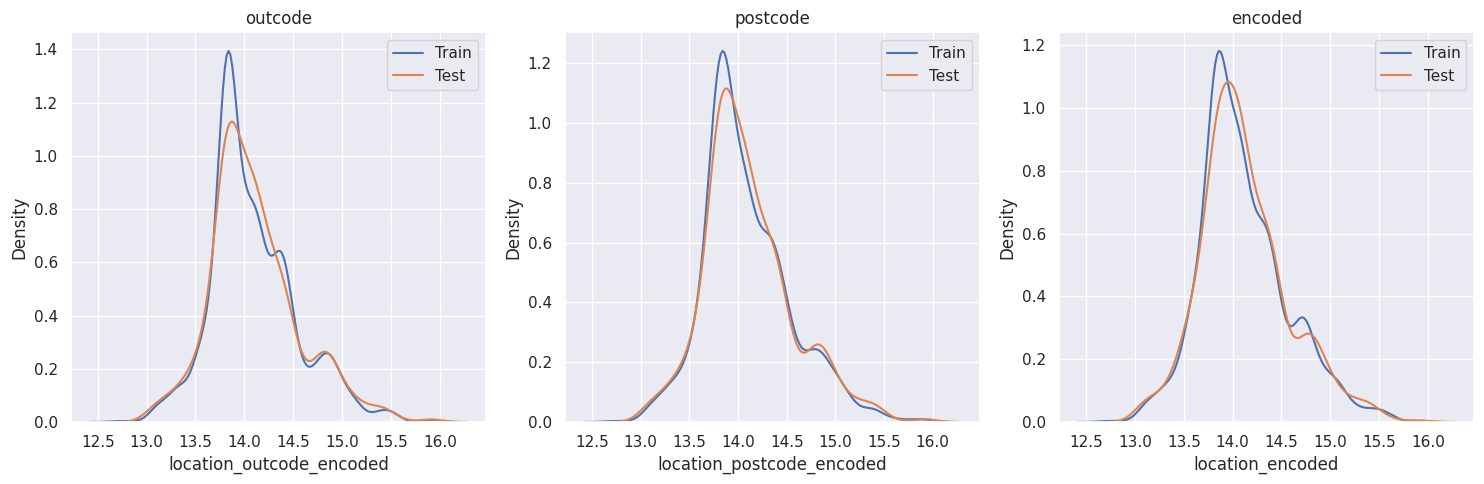


Sample of encoded location features:


,location_outcode_encoded,location_postcode_encoded,location_encoded
3403,14.91,14.76,14.76
334,13.73,13.71,13.71
1753,14.09,14.09,14.14
1090,14.36,14.36,14.35
1758,14.36,14.33,14.35


In [136]:
# Initialise and test location encoder
location_encoder = HierarchicalLocationEncoder(smoothing_factor=10, min_freq=5)

# Fit and transform data
location_train_encoded = location_encoder.fit_transform(train_data, target_col='log_price')
location_test_encoded = location_encoder.transform(test_data)

# Quick visualisation of results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare distributions of each encoding level
for i, col in enumerate(['location_outcode_encoded', 'location_postcode_encoded', 'location_encoded']):
    sns.kdeplot(location_train_encoded[col], ax=axes[i], label='Train')
    sns.kdeplot(location_test_encoded[col], ax=axes[i], label='Test')
    axes[i].set_title(col.replace('location_', '').replace('_encoded', ''))
    axes[i].legend()

plt.tight_layout()
plt.show()

# Display sample results
print("\nSample of encoded location features:")
display(location_train_encoded.head())

# Save encoder for later use
# location_encoder.save('../models/location_encoder.pkl')

### Mean outcode price per square foot encoder implementation

This encoder creates area-level price per square foot features by calculating mean rates for each London outcode (e.g. "SW1", "E14").

Here we tackle a subtle challenge: we want the predictive power of local market rates without leaking individual property prices. The solution is elegant - for each outcode (like "SW1"), calculate the mean price per square foot using only training data, falling back to a global average for areas we haven't seen.

This preserves the crucial statistical separation between training and test while capturing valuable market-level signals. A property in SW1 gets encoded with SW1's historical average rate, never its own price or future sales.
The result is a powerful but carefully controlled way to let our models learn from local market rates.

While using price information in features can be dangerous for several reasons, this implementation maintains statistical validity by strictly using only training data means, never individual property prices. We'll explore the implications of this later on in the lesson, but first let's have a look at our implementation below.


Testing MeanOutcodePricePerSquareFootEncoder...

Fitted price encoder:
- Outcodes encoded: 143
- Global mean price/sqft: £1,065.65
- Range: £266.68 - £4,062.82


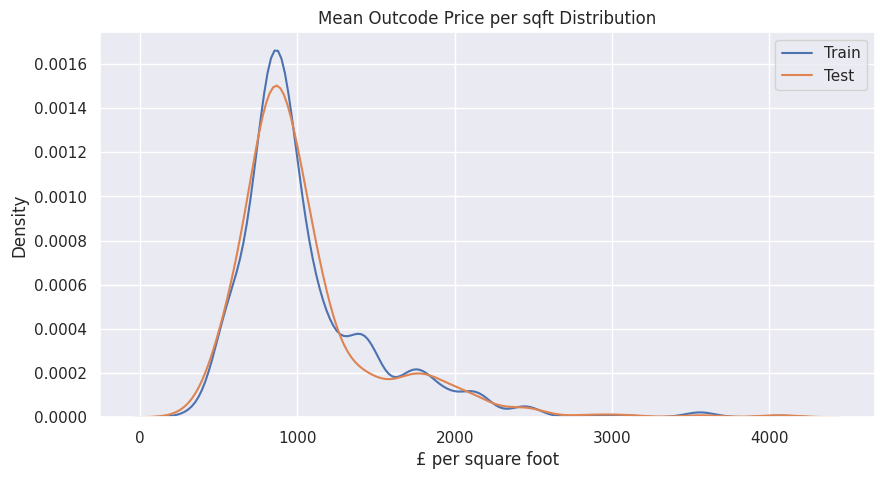

In [172]:
class MeanOutcodePricePerSquareFootEncoder:
    """Encodes outcodes with their mean price per square foot.

    Calculates mean price/sqft at outcode level using only training data,
    using global mean as fallback for unseen outcodes.

    Example:
        encoder = MeanOutcodePricePerSquareFootEncoder()
        encoder.fit(train_data)
        train_price_encoded = encoder.transform(train_data)
        test_price_encoded = encoder.transform(test_data)
    """

    def __init__(self, verbose: bool = True):
        self.outcode_means: Optional[pd.Series] = None
        self.global_mean: Optional[float] = None
        self.is_fitted: bool = False
        self.verbose = verbose

    def fit(self, df: pd.DataFrame) -> 'MeanOutcodePricePerSquareFootEncoder':
        """Calculate outcode means using only training data.

        Args:
            df: DataFrame containing 'Price', 'Area in sq ft', and 'Outcode' columns
        """
        required_cols = {'Price', 'Area in sq ft', 'Outcode'}
        missing_cols = required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Validate numeric columns
        if not (df['Price'] > 0).all():
            raise ValueError("All prices must be positive")
        if not (df['Area in sq ft'] > 0).all():
            raise ValueError("All areas must be positive")

        # Calculate price per square foot
        price_per_sqft = df['Price'] / df['Area in sq ft']

        # Calculate means and store
        self.outcode_means = price_per_sqft.groupby(df['Outcode']).mean()
        self.global_mean = price_per_sqft.mean()

        if self.verbose:
            print(f"\nFitted price encoder:")
            print(f"- Outcodes encoded: {len(self.outcode_means)}")
            print(f"- Global mean price/sqft: £{self.global_mean:,.2f}")
            print(f"- Range: £{self.outcode_means.min():,.2f} - £{self.outcode_means.max():,.2f}")

        self.is_fitted = True
        return self

    def transform(self, df: pd.DataFrame) -> pd.Series:
        """Transform data using fitted means with fallback.

        Args:
            df: DataFrame containing 'Outcode' column

        Returns:
            Series containing 'price_per_sqft_encoded' for each row
        """
        if not self.is_fitted:
            raise ValueError("Encoder must be fitted before transform")

        if 'Outcode' not in df.columns:
            raise ValueError("DataFrame must contain 'Outcode' column")

        encoded = df['Outcode'].map(self.outcode_means).fillna(self.global_mean)
        encoded.name = 'price_per_sqft_encoded'
        return encoded

    def fit_transform(self, df: pd.DataFrame) -> pd.Series:
        """Fit encoder and transform data in one step."""
        return self.fit(df).transform(df)

    def save(self, path: str) -> None:
        """Save fitted encoder parameters."""
        if not self.is_fitted:
            raise ValueError("Cannot save unfitted encoder")

        with open(path, 'wb') as f:
            pickle.dump({
                'outcode_means': self.outcode_means,
                'global_mean': self.global_mean,
                'is_fitted': True
            }, f)

        if self.verbose:
            print(f"\nSaved price encoder to {path}")

    @classmethod
    def load(cls, path: str) -> 'MeanOutcodePricePerSquareFootEncoder':
        """Load saved encoder parameters."""
        with open(path, 'rb') as f:
            params = pickle.load(f)

        encoder = cls(verbose=True)
        encoder.outcode_means = params['outcode_means']
        encoder.global_mean = params['global_mean']
        encoder.is_fitted = params['is_fitted']
        return encoder

# Quick test
print("Testing MeanOutcodePricePerSquareFootEncoder...")
price_encoder = MeanOutcodePricePerSquareFootEncoder()
train_price_encoded = price_encoder.fit_transform(train_data)
test_price_encoded = price_encoder.transform(test_data)

# Save for production
# price_encoder.save('../models/price_encoder.pkl')

# Compare distributions
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(train_price_encoded, label='Train')
sns.kdeplot(test_price_encoded, label='Test')
ax.set_title('Mean Outcode Price per sqft Distribution')
ax.set_xlabel('£ per square foot')
plt.legend()
plt.show()

Over the past sections, we've built three encoders for handling different aspects of our data:

1. One-hot encoding for categorical features (house type, city/county)
2. Hierarchical location encoding for complex geography
3. Mean outcode price per square foot for area-normalised pricing

Rather than review these in isolation, we'll examine their outputs as we build increasingly sophisticated models.

This lets us understand our features in context, while keeping focus on practical model development.

## Training our first decision tree

Let's start with a straightforward model using our simple numeric and one-hot encoded features:

- Number of bedrooms (numeric)
- Area in square feet (numeric)
- House type (one-hot encoded)
- City/County (one-hot encoded)
- Outcode (one-hot encoded)

This combination gives us interpretable features without overwhelming complexity. We'll:
1. Create this feature set
2. Train a basic decision tree
3. Visualise its decision structure
4. Examine how it makes predictions
5. Tune its parameters for better performance

We'll look at both feature importance and the actual decision paths our tree uses to value properties.

Later, we can improve this foundation with:
- Parameter tuning
- Cross-validation
- Model persistence
- More advanced models

But first, let's understand how a basic tree approaches house price prediction!


Model Performance:
Training R²: 1.000
Test R²: 0.786

Training MAE: £1,233
Test MAE: £670,882


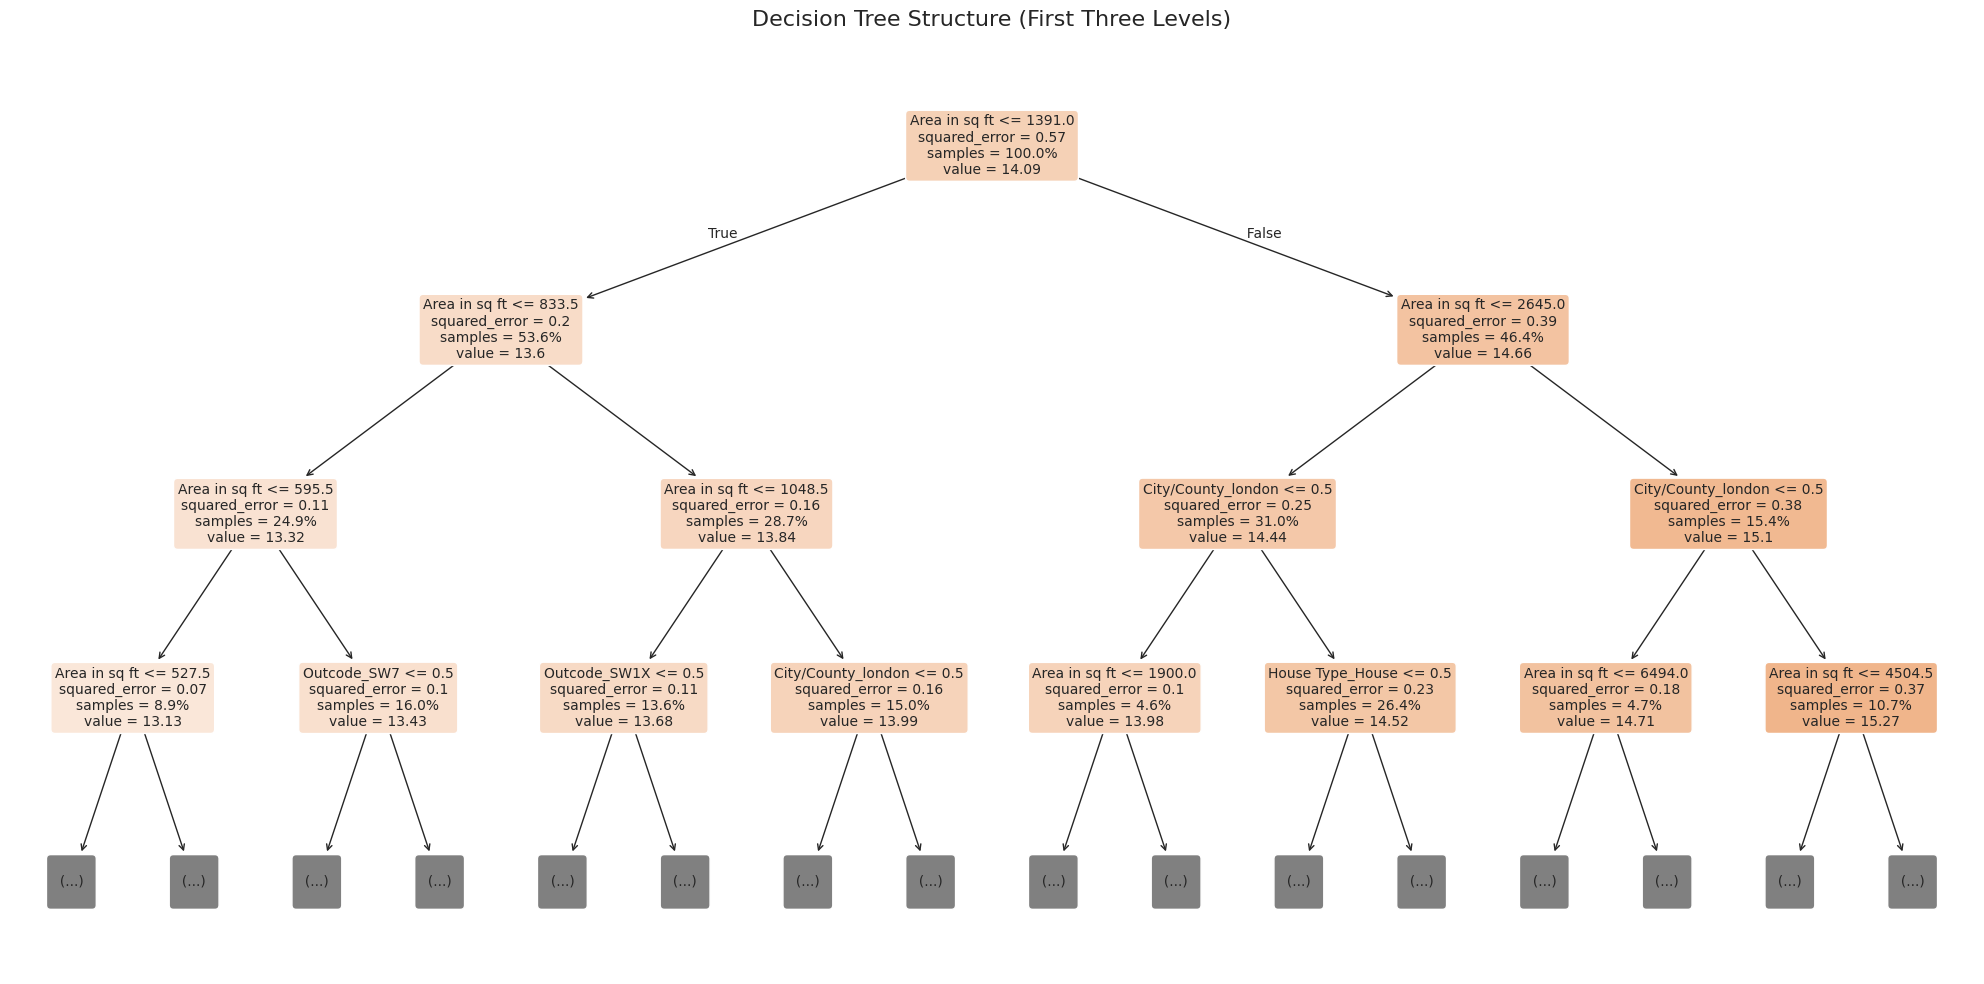


Tree Structure:
Total depth: 62
Number of leaves: 2664
Average samples per leaf: 1.0

Top 5 Most Important Features:


,feature,importance
1,Area in sq ft,0.75
14,City/County_london,0.05
0,No. of Bedrooms,0.02
5,House Type_House,0.02
112,Outcode_SW3,0.01


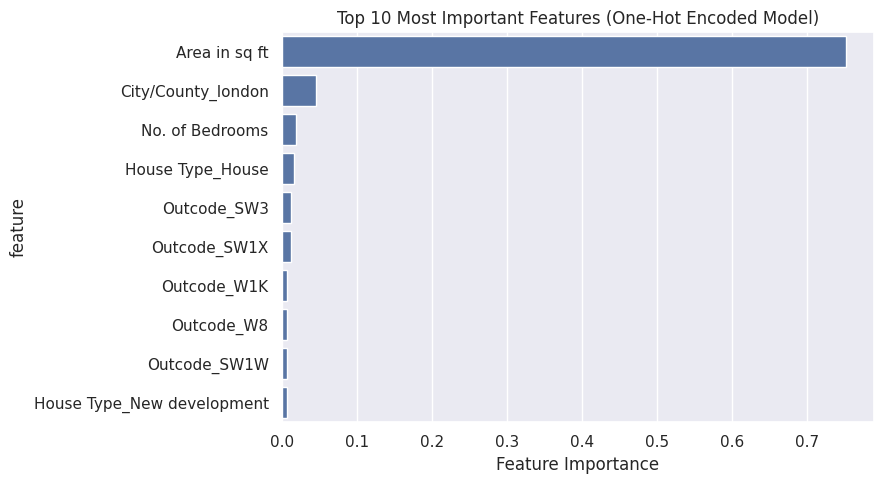

In [138]:
def train_onehot_decision_tree(train_data: pd.DataFrame,
                              test_data: pd.DataFrame,
                              random_state: int = 42) -> Tuple[DecisionTreeRegressor, Dict, pd.DataFrame, pd.DataFrame]:
    """Train decision tree on one-hot encoded features.

    Args:
        train_data: Training DataFrame
        test_data: Test DataFrame
        random_state: Random seed for reproducibility

    Returns:
        Tuple of (fitted model, performance metrics, feature importance, encoded training features)
    """
    # Create feature encoder
    encoder = OneHotFeatureEncoder(
        numeric_features=['No. of Bedrooms', 'Area in sq ft'],
        categorical_features=['House Type', 'City/County', 'Outcode'],
        handle_unknown='ignore'
    )

    # Create features
    X_train = encoder.fit_transform(train_data)
    X_test = encoder.transform(test_data)

    y_train = train_data['log_price']
    y_test = test_data['log_price']

    # Train model
    tree = DecisionTreeRegressor(random_state=random_state)
    tree.fit(X_train, y_train)

    # Make predictions
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    # Calculate metrics
    def calculate_metrics(y_true, y_pred, prefix=''):
        """Calculate regression metrics in both log and raw price space"""
        # Log space metrics
        r2 = r2_score(y_true, y_pred)

        # Raw price space metrics
        true_price = np.exp(y_true)
        pred_price = np.exp(y_pred)
        mae = mean_absolute_error(true_price, pred_price)
        rmse = np.sqrt(mean_squared_error(true_price, pred_price))

        return {
            f'{prefix}mae': mae,
            f'{prefix}rmse': rmse,
            f'{prefix}r2': r2
        }

    # Collect performance metrics
    metrics = {}
    metrics.update(calculate_metrics(y_train, train_pred, 'train_'))
    metrics.update(calculate_metrics(y_test, test_pred, 'test_'))

    # Calculate feature importance
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': tree.feature_importances_
    }).sort_values('importance', ascending=False)

    # Save encoder for production
    # encoder.save('../models/onehot_encoder.pkl')

    print("\nModel Performance:")
    print(f"Training R²: {metrics['train_r2']:.3f}")
    print(f"Test R²: {metrics['test_r2']:.3f}")
    print(f"\nTraining MAE: £{metrics['train_mae']:,.0f}")
    print(f"Test MAE: £{metrics['test_mae']:,.0f}")

    # Visualise tree structure
    plt.figure(figsize=(20,10))
    plot_tree(tree,
             feature_names=X_train.columns,
             max_depth=3,
             filled=True,
             rounded=True,
             fontsize=10,
             proportion=True,
             precision=2)
    plt.title("Decision Tree Structure (First Three Levels)", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Print tree statistics
    print(f"\nTree Structure:")
    print(f"Total depth: {tree.get_depth()}")
    print(f"Number of leaves: {tree.get_n_leaves()}")
    print(f"Average samples per leaf: {len(X_train)/tree.get_n_leaves():.1f}")

    print("\nTop 5 Most Important Features:")
    display(importance.head())

    return tree, metrics, importance, X_train

# Train model and get results
onehot_tree, onehot_metrics, onehot_importance, onehot_features = train_onehot_decision_tree(
    train_data,
    test_data
)

# Visualise feature importance
plt.figure(figsize=(9, 5))
sns.barplot(data=onehot_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (One-Hot Encoded Model)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

## Analysing our first decision tree: Understanding overfitting

Our initial decision tree produced some revealing results:
```
Training R²: 1.000    Test R²: 0.786
Training MAE: £1,233  Test MAE: £670,882
```

This dramatic difference between training and test performance indicates a classic machine learning problem: overfitting.

### Understanding our tree's behaviour
Let's break down what we've learned:

1. **Tree structure**
   - Extremely deep tree of 62 levels
   - A huge number of leaf nodes - at 2664 leaves its more of a bush than a tree!
   - One average 1 sample per leaf
   - Early splits focus on area and location

2. **Feature importance**
   - Area dominates (75.1% importance)
   - Location features contribute smaller amounts
   - Bedrooms have surprisingly low impact (2.5%)

3. **Price predictions**
   - Perfect on training data (R² = 1.0)
   - Large errors on test data (£670K average)
   - Almost no training error (£1,233 MAE)

### The problem: Unrestricted growth
By default, our tree keeps splitting until it can perfectly predict each house price. Think of it like a real estate agent who has memorised every house price in their database instead of learning general market patterns.

This happens because the tree:
1. Splits on area into broad price bands
2. Refines with location features
3. Makes increasingly specific splits
4. Eventually isolates individual properties

### The solution: Controlled growth
Just as estate agents develop pricing rules based on multiple similar properties, we can force our tree to make more general predictions by setting:

```python
max_depth = 6            # Limit complexity of rules
min_samples_leaf = 30    # Require 30+ houses per price prediction
```

Let's try these constraints and see how they affect our model's performance.


Controlled Tree Performance:
Training R²: 0.777
Test R²: 0.787
Training MAE: £594,884
Test MAE: £636,490

Tree Structure:
Depth: 6
Number of leaves: 42
Average samples per leaf: 66.3

Top 5 Most Important Features:


,feature,importance
1,Area in sq ft,0.91
14,City/County_london,0.06
5,House Type_House,0.02
0,No. of Bedrooms,0.02
7,House Type_New development,0.00


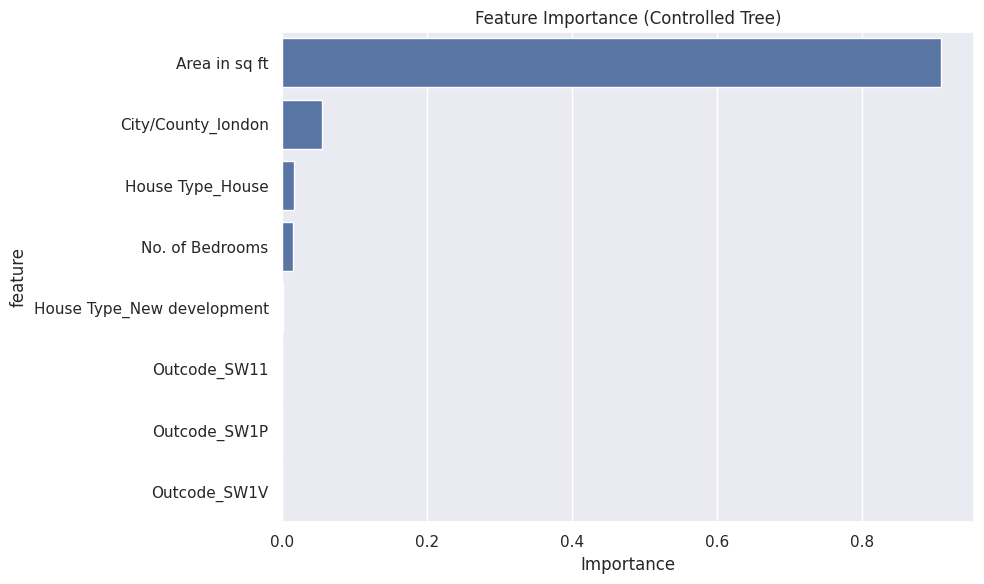

In [139]:
# Train decision tree with manual constraints
def train_controlled_onehot_tree(train_data: pd.DataFrame,
                                test_data: pd.DataFrame,
                                max_depth: int = 6,
                                min_samples_leaf: int = 30,
                                random_state: int = 42) -> Tuple[DecisionTreeRegressor, Dict, pd.DataFrame]:
    """Train decision tree with controlled growth parameters.

    Args:
        train_data: Training DataFrame
        test_data: Test DataFrame
        max_depth: Maximum tree depth
        min_samples_leaf: Minimum samples per leaf
        random_state: Random seed

    Returns:
        Tuple of (model, metrics, feature importance)
    """
    # Create feature encoder
    encoder = OneHotFeatureEncoder(
        numeric_features=['No. of Bedrooms', 'Area in sq ft'],
        categorical_features=['House Type', 'City/County', 'Outcode'],
        handle_unknown='ignore'
    )

    # Create features
    X_train = encoder.fit_transform(train_data)
    X_test = encoder.transform(test_data)

    y_train = train_data['log_price']
    y_test = test_data['log_price']

    # Train controlled tree
    controlled_tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    controlled_tree.fit(X_train, y_train)

    # Make predictions
    train_pred = controlled_tree.predict(X_train)
    test_pred = controlled_tree.predict(X_test)

    # Calculate metrics
    def calculate_metrics(y_true, y_pred, prefix=''):
        """Calculate regression metrics in both log and raw price space"""
        r2 = r2_score(y_true, y_pred)
        true_price = np.exp(y_true)
        pred_price = np.exp(y_pred)
        mae = mean_absolute_error(true_price, pred_price)
        rmse = np.sqrt(mean_squared_error(true_price, pred_price))
        return {f'{prefix}r2': r2, f'{prefix}mae': mae, f'{prefix}rmse': rmse}

    # Collect metrics
    metrics = {}
    metrics.update(calculate_metrics(y_train, train_pred, 'train_'))
    metrics.update(calculate_metrics(y_test, test_pred, 'test_'))

    # Calculate feature importance
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': controlled_tree.feature_importances_
    }).sort_values('importance', ascending=False)

    # Print performance summary
    print("\nControlled Tree Performance:")
    print(f"Training R²: {metrics['train_r2']:.3f}")
    print(f"Test R²: {metrics['test_r2']:.3f}")
    print(f"Training MAE: £{metrics['train_mae']:,.0f}")
    print(f"Test MAE: £{metrics['test_mae']:,.0f}")

    print(f"\nTree Structure:")
    print(f"Depth: {controlled_tree.get_depth()}")
    print(f"Number of leaves: {controlled_tree.get_n_leaves()}")
    print(f"Average samples per leaf: {len(X_train)/controlled_tree.get_n_leaves():.1f}")

    print("\nTop 5 Most Important Features:")
    display(importance.head())

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance.head(8), x='importance', y='feature')
    plt.title('Feature Importance (Controlled Tree)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return controlled_tree, metrics, importance

# Train controlled tree
controlled_tree, controlled_metrics, controlled_importance = train_controlled_onehot_tree(
    train_data,
    test_data
)

## Understanding model performance and hyperparameter impact

Let's compare our two approaches to decision tree modeling:

### Unrestricted tree (no parameter limits)
```
Training R²: 1.000    Test R²: 0.786
Training MAE: £1,233  Test MAE: £670,882
```

### Controlled tree (max_depth=6, min_samples_leaf=30)
```
Training R²: 0.777    Test R²: 0.787
Training MAE: £594,884  Test MAE: £636,490
Average samples per leaf: 66.3
```

### What these numbers tell ss

1. **The overfitting problem**
   - Our unrestricted tree achieved perfect training accuracy (R²=1.0)
   - But performed worse on new data (£670K vs £636K error)
   - It's like memorising past house prices instead of learning market patterns

2. **Benefits of controlled growth**
   - Limiting depth to 6 levels created 42 price prediction rules
   - Each rule uses at least 30 houses (min_samples_leaf)
   - Average of 66 houses per rule suggests stable predictions

3. **The trade-off**
   - Training accuracy dropped (R²: 1.0 → 0.777)
   - But test performance improved (MAE: £670K → £636K)
   - More realistic predictions based on broader patterns

### Real estate context

Think of it this way:
- Unrestricted tree: Like a new agent who memorises every sale price but can't generalise
- Controlled tree: Like an experienced agent who uses reliable rules based on multiple similar properties

### The hyperparameter question

While our controlled tree performs better, we're left with important questions:
1. Why exactly 6 levels of depth?
2. Is 30 houses per rule optimal?
3. How can we be sure these choices work across different areas?

To answer these questions systematically, we need two key tools:
1. Cross-validation for reliable performance testing
2. Grid search for finding optimal parameters

Let's explore these tools and see how they can help us build even better models.

## Cross-validation: Getting reliable performance estimates

In lesson 1B we simply split our data into train, validation and test sets. Now we'll try something more sophisticated - we'll repeatedly shuffle our training data into different train and validation splits while keeping our test set separate, a technique called cross-validation.

Let's understand why through a real estate example.

### The single split problem

Imagine our validation split of the training data put:
- Most Chelsea properties in the training portion
- Most Hackney properties in the validation portion

Our model would:
1. Learn pricing patterns from expensive areas (Chelsea)
2. Validate on more affordable areas (Hackney)
3. Show poor performance due to the mismatch

But with a different random split, we might get opposite results! This makes it hard to trust our performance estimates during development.

### How cross-validation Works

Instead of one validation split, cross-validation divides our training data into multiple portions:

```
Training Data (2,784 houses)
↓
Split into 5 groups (4 × 557 houses + 1 × 556 houses)

Round 1: [Validation][Train][Train][Train][Train]
         557         557   557   557   556 houses

Round 2: [Train][Validation][Train][Train][Train]
Round 3: [Train][Train][Validation][Train][Train]
Round 4: [Train][Train][Train][Validation][Train]
Round 5: [Train][Train][Train][Train][Validation]
```

For each round:
1. Train on ~2,227 houses (4 groups)
2. Validate on ~557 houses (1 group)
3. Record the performance

Our test set of 696 houses remains completely untouched during this process.

### Benefits for house price prediction

This approach:
- Tests model performance across different neighborhoods
- Provides 5 different error estimates
- Shows how stable predictions are
- Helps identify if model works better in some areas than others

Next, we'll use cross-validation in a systematic search for the best model parameters.

## Grid search

Now that we have a reliable way to test model performance using cross-validation, we can systematically search for the best parameters.

### Parameters to tune

For our decision tree, we need to find optimal values for:

1. `max_depth`: Maximum number of decisions allowed
   - Too low: Model might miss important patterns
   - Too high: Model might memorise noise
   - We'll try: [4, 6, 8, 10, 12]

2. `min_samples_leaf`: Minimum houses needed for a price prediction
   - Too low: Unstable predictions from few examples
   - Too high: Might miss legitimate local patterns
   - We'll try: [10, 20, 30, 50, 70]

3. `min_samples_split`: Minimum houses needed to consider a new decision
   - Too low: Creates unnecessary splits
   - Too high: Might stop too early
   - We'll try: [20, 40, 60, 75, 100]

### How grid search works

For each combination of parameters:
```
1. Create a decision tree with those parameters
2. Run 5-fold cross-validation
3. Calculate average performance
4. Store results

Example combination:
max_depth=6, min_samples_leaf=30, min_samples_split=60
→ CV Fold 1: MAE = £550,000
→ CV Fold 2: MAE = £620,000
→ CV Fold 3: MAE = £580,000
→ CV Fold 4: MAE = £590,000
→ CV Fold 5: MAE = £560,000
→ Average MAE: £580,000 ±£26,000
```

### Total combinations

Our search will try:
- 5 values for max_depth
- 5 values for min_samples_leaf
- 5 values for min_samples_split
- Total: 5 × 5 × 5 = 125 combinations
- Each tested with 5-fold CV
- Total models trained: 625

### Real estate context

It's like systematically testing different valuation rules:
- How many comparable properties needed? (min_samples_leaf)
- How detailed should price adjustments be? (max_depth)
- When to stop making finer distinctions? (min_samples_split)

Let's implement this search and find the best combination for London house prices.

Running grid search to find optimal parameters...

Starting grid search (expected time: ~2 minutes)...
Testing 125 combinations
Fitting 5 folds for each of 125 candidates, totalling 625 fits

Best parameters found:
max_depth: 6
min_samples_leaf: 10
min_samples_split: 40

Best Model Performance:
Test R²: 0.805
Test MAE: £589,728


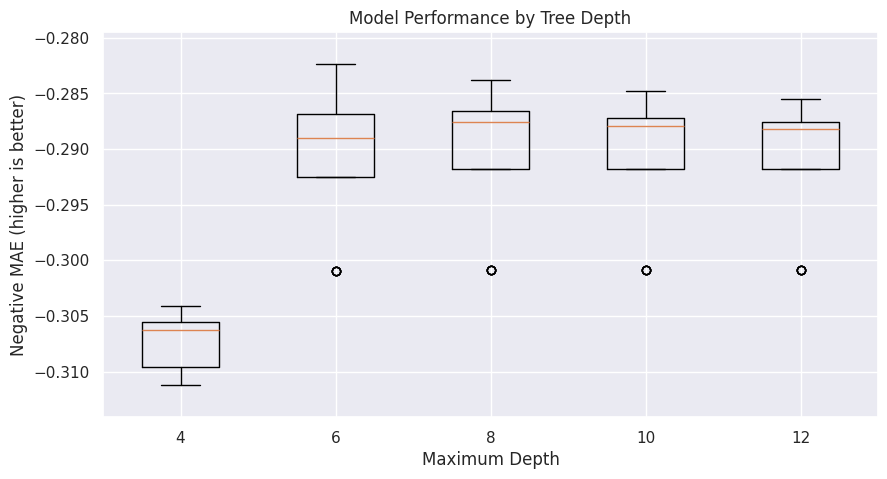

In [140]:
def grid_search_tree(train_data: pd.DataFrame,
                    test_data: pd.DataFrame,
                    random_state: int = 42) -> Tuple[DecisionTreeRegressor, pd.DataFrame, Dict]:
    """Find optimal decision tree parameters using grid search and cross-validation."""
    # Create features
    encoder = OneHotFeatureEncoder(
        numeric_features=['No. of Bedrooms', 'Area in sq ft'],
        categorical_features=['House Type', 'City/County', 'Outcode'],
        handle_unknown='ignore'
    )

    # Transform data
    X_train = encoder.fit_transform(train_data).astype(np.float64)
    y_train = train_data['log_price'].astype(np.float64)

    # Define parameter grid
    param_grid = {
        'max_depth': np.array([4, 6, 8, 10, 12], dtype=np.int32),
        'min_samples_leaf': np.array([10, 20, 30, 50, 70], dtype=np.int32),
        'min_samples_split': np.array([20, 40, 60, 75, 100], dtype=np.int32)
    }

    # Run grid search
    grid_search = GridSearchCV(
        DecisionTreeRegressor(random_state=random_state),
        param_grid,
        cv=KFold(n_splits=5, shuffle=True, random_state=random_state),
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    print("Starting grid search (expected time: ~2 minutes)...")
    print(f"Testing {len(param_grid['max_depth']) * len(param_grid['min_samples_leaf']) * len(param_grid['min_samples_split'])} combinations")

    grid_search.fit(X_train, y_train)

    # Train final model and evaluate
    best_tree = DecisionTreeRegressor(**grid_search.best_params_, random_state=random_state)
    best_tree.fit(X_train, y_train)

    # Test set evaluation
    X_test = encoder.transform(test_data).astype(np.float64)
    y_test = test_data['log_price'].astype(np.float64)
    test_pred = best_tree.predict(X_test)

    # Print results
    print("\nBest parameters found:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")

    print(f"\nBest Model Performance:")
    print(f"Test R²: {r2_score(y_test, test_pred):.3f}")
    print(f"Test MAE: £{mean_absolute_error(np.exp(y_test), np.exp(test_pred)):,.0f}")

    # Prepare data for visualisation
    depth_scores = {}
    for depth in param_grid['max_depth']:
        mask = grid_search.cv_results_['param_max_depth'] == depth
        depth_scores[depth] = grid_search.cv_results_['mean_test_score'][mask]

    # Visualise results with adjusted range and boxplot parameters
    plt.figure(figsize=(10, 5))
    plt.boxplot(depth_scores.values(),
                whis=1.5,           # Set whisker length to 1.5 IQR (standard)
                showfliers=True,    # Show outlier points
                showcaps=True,      # Show whisker caps
                notch=False)        # Don't use notched boxes

    plt.xticks(range(1, len(param_grid['max_depth']) + 1), param_grid['max_depth'])

    # Calculate appropriate y-axis limits with smaller padding
    all_scores = np.concatenate(list(depth_scores.values()))
    score_range = np.max(all_scores) - np.min(all_scores)
    y_min = np.min(all_scores) - score_range * 0.1
    y_max = np.max(all_scores) + score_range * 0.1
    plt.ylim(y_min, y_max)

    plt.title('Model Performance by Tree Depth')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Negative MAE (higher is better)')
    plt.grid(True)
    plt.show()

    return best_tree, pd.DataFrame(grid_search.cv_results_), grid_search.best_params_

# Run grid search
print("Running grid search to find optimal parameters...\n")
optimal_tree, grid_results, best_params = grid_search_tree(train_data, test_data)

## Grid search results analysis

Our systematic parameter search revealed optimal values and interesting performance patterns:

### Model evolution and performance

1. **Unrestricted tree (baseline)**
   ```
   Training R²: 1.000    Test R²: 0.786
   Training MAE: £1,233  Test MAE: £670,882
   
   Classic overfitting pattern
   ```

2. **Manual parameters** (depth=6, samples=30)
   ```
   Training R²: 0.777    Test R²: 0.787
   Training MAE: £594,884 Test MAE: £636,490
   
   Better generalisation, still suboptimal
   ```

3. **Optimal parameters from gird search**
   ```
   max_depth: 6
   min_samples_leaf: 10
   min_samples_split: 40
   
   Test R²: 0.805
   Test MAE: £589,728

   Best balance of complexity and performance
   ```

### Performance analysis

1. **Depth impact**
   - Depth=4 shows high variance (visible in boxplot spread)
   - Depths 6-12 demonstrate remarkably stable performance
   - Consistent outlier at -0.3 MAE across all depths
   - Strongly validates depth=6 as optimal choice

2. **Sample size trade-offs**
   - Smaller leaf size (10 vs 30) enables more granular predictions
   - Larger split criterion (40 vs 30) provides overfitting protection
   - Achieves balance between flexibility and stability
   - 12% reduction in MAE from unrestricted model

3. **Performance patterns**
   - Consistent outlier suggests specific property types need attention
   - Stable performance across depths 6-12 indicates robust solution
   - £47K improvement in predictions vs both previous approaches

### The next challenge: Feature engineering

While we've optimised tree structure, several areas need investigation:

1. **Outlier analysis**
   - Investigate properties causing consistent -0.3 MAE
   - Consider robust regression techniques
   - Evaluate feature importance for outlier cases

2. **Location encoding**
   - Current one-hot approach may be suboptimal
   - Consider price-based and hierarchical encoding
   - Need to balance granularity with stability

3. **Price context**
   - Investigate area price levels
   - Consider temporal aspects
   - Implement proper validation strategies

Let's explore three encoding strategies using our optimal parameters:
1. One-hot encoding (current approach)
2. Target encoding with proper validation
3. Price-per-sqft features with temporal aspects

This will help us understand if our parameter optimisation remains robust across different feature representations while addressing the consistent outlier pattern we've observed.

## Feature selection and encoding strategy

Now that we've optimised our tree structure, a critical question remains: what's the best way to represent location information for house price prediction? Let's review the key approaches we've developed, which we'll compare in depth using ATLAS in the next lesson.

### Core features
Every feature set will include these fundamental property characteristics:
- Area in sq ft (numeric)
- Number of Bedrooms (numeric)
- House Type (one-hot encoded, 8 categories)
- Log-transformed price (target variable)

### Feature set 1: Simple categorical encoding
Core features plus essential one-hot encoded location information:
```
Base Features
   +
One-Hot Encoded Location Features:
├── City/County (6 binary features)
└── Outcode (~100 binary features)
```
- Each category gets its own binary column
- Missing values get dedicated indicator columns
- No price information used in encoding
- Avoids sparsity issues from full location encoding

### Feature set 2: Hierarchical target encoding
Core features plus price-based location encoding:
```
Base Features
   +
City/County One-hot encoded
   +
Price-Encoded Location Features:
├── Location encoding (with postcode prior)
├── Postcode encoding (with outcode prior)
└── Outcode encoding (with global prior)
```
- Each location gets encoded as mean log price
- Hierarchical fallback for sparse data:
  * Sparse locations → postcode average
  * Sparse postcodes → outcode average
  * Missing outcodes → global average
- Smoothing factor of 10 for stability
- Minimum frequency of 5 for reliability

### Feature set 3: Market rate features
Core features plus area-normalised market metrics:
```
Base Features
   +
City/County One-hot encoded
   +
Market Rate Features:
├── Area per square foot (normalised area metric)
└── Mean price per square foot by outcode (market rate)
```
- Two complementary area metrics:
  * Area efficiency (sq ft per room)
  * Local market rates (£/sq ft)
- Calculated from training data only
- Missing outcodes use global average
- Industry-standard approach

### What we'll learn

This comparison will reveal:

1. **Pure Location Value**
   - How much can we predict from location alone?
   - Do we need price information?
   - Which areas consistently command premiums?

2. **Price Information Impact**
   - Does target encoding improve accuracy?
   - Is the complexity worth it?
   - How stable are the predictions?

3. **Market Rate Effects**
   - Do area-normalised prices help?
   - Which areas are over/under valued?
   - How reliable are local price levels?

In the next lesson, we'll use ATLAS (Automated Tree Learning Analysis System) to systematically compare these encoding strategies across multiple models and metrics. ATLAS will help us deeply understand:
- Which encoding works best for different areas of London
- How encoding choices affect model reliability
- When to use each type of feature encoding
- How to combine encodings for optimal performance

For now, let's conclude our exploration of decision trees by examining some practical considerations for deployment.

In [141]:
# Optimised tree parameters from grid search
tree_params = {
    'max_depth': 6,
    'min_samples_leaf': 10,
    'min_samples_split': 40,
    'random_state': RANDOM_STATE
}

def compare_feature_sets(train_data: pd.DataFrame,
                        test_data: pd.DataFrame,
                        tree_params: Dict) -> pd.DataFrame:
    """Compare three feature encoding strategies using optimised tree parameters.
    This is a simplified version - see ATLAS for comprehensive comparison."""

    results = []
    tree = DecisionTreeRegressor(**tree_params)

    # Create base encoder for house type and city/county (used in all sets)
    base_encoder = OneHotFeatureEncoder(
        numeric_features=['Area in sq ft', 'No. of Bedrooms'],
        categorical_features=['House Type', 'City/County']
    )

    # Feature Set 1: Simple Categorical
    print("\nEvaluating Simple Categorical Features...")
    categorical_encoder = OneHotFeatureEncoder(
        numeric_features=['Area in sq ft', 'No. of Bedrooms'],
        categorical_features=['House Type', 'City/County', 'Outcode']
    )

    X_train_cat = categorical_encoder.fit_transform(train_data)
    X_test_cat = categorical_encoder.transform(test_data)

    print("\nFeature Set 1 - Simple Categorical:")
    print(f"Training features ({X_train_cat.shape[1]} total):")
    print(X_train_cat.columns.tolist())

    tree.fit(X_train_cat, train_data['log_price'])
    train_pred_cat = tree.predict(X_train_cat)
    test_pred_cat = tree.predict(X_test_cat)

    results.append({
        'feature_set': 'Simple Categorical',
        'n_features': X_train_cat.shape[1],
        'train_r2': r2_score(train_data['log_price'], train_pred_cat),
        'test_r2': r2_score(test_data['log_price'], test_pred_cat),
        'train_mae': mean_absolute_error(
            np.exp(train_data['log_price']),
            np.exp(train_pred_cat)
        ),
        'test_mae': mean_absolute_error(
            np.exp(test_data['log_price']),
            np.exp(test_pred_cat)
        )
    })

    # Feature Set 2: Hierarchical Target Encoding
    print("\nEvaluating Hierarchical Target Encoding...")
    location_encoder = HierarchicalLocationEncoder()
    location_train = location_encoder.fit_transform(train_data)
    location_test = location_encoder.transform(test_data)

    # Include base features with location encoding
    X_train_target = pd.concat([
        base_encoder.fit_transform(train_data),  # Base features including City/County
        location_train
    ], axis=1)

    X_test_target = pd.concat([
        base_encoder.transform(test_data),
        location_test
    ], axis=1)

    print("\nFeature Set 2 - Hierarchical Target:")
    print(f"Training features ({X_train_target.shape[1]} total):")
    print(X_train_target.columns.tolist())

    tree.fit(X_train_target, train_data['log_price'])
    train_pred_target = tree.predict(X_train_target)
    test_pred_target = tree.predict(X_test_target)

    results.append({
        'feature_set': 'Hierarchical Target',
        'n_features': X_train_target.shape[1],
        'train_r2': r2_score(train_data['log_price'], train_pred_target),
        'test_r2': r2_score(test_data['log_price'], test_pred_target),
        'train_mae': mean_absolute_error(
            np.exp(train_data['log_price']),
            np.exp(train_pred_target)
        ),
        'test_mae': mean_absolute_error(
            np.exp(test_data['log_price']),
            np.exp(test_pred_target)
        )
    })

    # Feature Set 3: Market Rate Features
    print("\nEvaluating Market Rate Features...")
    price_encoder = MeanOutcodePricePerSquareFootEncoder()
    price_per_sqft_train = price_encoder.fit_transform(train_data)
    price_per_sqft_test = price_encoder.transform(test_data)

    X_train_market = pd.concat([
        base_encoder.transform(train_data),  # Base features including City/County
        pd.DataFrame({'price_per_sqft': price_per_sqft_train})  # Market rate feature
    ], axis=1)

    X_test_market = pd.concat([
        base_encoder.transform(test_data),
        pd.DataFrame({'price_per_sqft': price_per_sqft_test})
    ], axis=1)

    print("\nFeature Set 3 - Market Rate:")
    print(f"Training features ({X_train_market.shape[1]} total):")
    print(X_train_market.columns.tolist())

    tree.fit(X_train_market, train_data['log_price'])
    train_pred_market = tree.predict(X_train_market)
    test_pred_market = tree.predict(X_test_market)

    results.append({
        'feature_set': 'Market Rate',
        'n_features': X_train_market.shape[1],
        'train_r2': r2_score(train_data['log_price'], train_pred_market),
        'test_r2': r2_score(test_data['log_price'], test_pred_market),
        'train_mae': mean_absolute_error(
            np.exp(train_data['log_price']),
            np.exp(train_pred_market)
        ),
        'test_mae': mean_absolute_error(
            np.exp(test_data['log_price']),
            np.exp(test_pred_market)
        )
    })

    return pd.DataFrame(results)

# Run comparison
print("Comparing feature sets with optimised tree (depth=6, min_samples_leaf=10, min_samples_split=40)...")
comparison_results = compare_feature_sets(train_data, test_data, tree_params)

# Display results
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x) if abs(x) < 1000
              else '{:,.0f}'.format(x))
print("\nFeature Set Comparison Results:")
display(comparison_results)


Comparing feature sets with optimised tree (depth=6, min_samples_leaf=10, min_samples_split=40)...

Evaluating Simple Categorical Features...

Feature Set 1 - Simple Categorical:
Training features (161 total):
['Area in sq ft', 'No. of Bedrooms', 'House Type_Bungalow', 'House Type_Duplex', 'House Type_Flat / Apartment', 'House Type_House', 'House Type_Mews', 'House Type_New development', 'House Type_Penthouse', 'House Type_Studio', 'City/County_city of london', 'City/County_essex', 'City/County_hertfordshire', 'City/County_kent', 'City/County_london', 'City/County_middlesex', 'City/County_surrey', 'City/County_nan', 'Outcode_BR6', 'Outcode_CM16', 'Outcode_CR5', 'Outcode_E1', 'Outcode_E14', 'Outcode_E15', 'Outcode_E16', 'Outcode_E1W', 'Outcode_E2', 'Outcode_E20', 'Outcode_E3', 'Outcode_E4', 'Outcode_E5', 'Outcode_E8', 'Outcode_E9', 'Outcode_EC1A', 'Outcode_EC1M', 'Outcode_EC1N', 'Outcode_EC1R', 'Outcode_EC1V', 'Outcode_EC1Y', 'Outcode_EC2A', 'Outcode_EC2M', 'Outcode_EC2V', 'Outcode_EC3R

,feature_set,n_features,train_r2,test_r2,train_mae,test_mae
0,Simple Categorical,161,0.790,0.805,"560,155","589,728"
1,Hierarchical Target,21,0.883,0.833,"416,709","542,874"
2,Market Rate,19,0.913,0.878,"364,801","477,949"


## Feature set results analysis

Our three encoding strategies produced notably different feature spaces with distinct performance characteristics:

### 1. Simple categorical (161 features)
**Structure:**
- Base features (2): Area, Bedrooms
- House Type (8): From Bungalow to Studio
- City/County (8): Including missing value indicator
- Outcodes (143): Complete geographic coverage

**Performance:**
- Test R²: 0.805, Test MAE: £589,728
- Large feature space due to one-hot encoding
- Solid baseline but high dimensionality
- Most stable train/test performance (0.790 → 0.805)

### 2. Hierarchical target (21 features)
**Structure:**
- Base features (2): Area, Bedrooms
- House Type (8): Full encoding
- City/County (8): Administrative regions
- Location hierarchy (3): Outcode, postcode, location mean prices

**Performance:**
- Test R²: 0.833, Test MAE: £542,874
- Much smaller feature space
- Improved performance through price-based location encoding
- Larger train/test gap (0.883 → 0.833)

### 3. Market rate (19 features)
**Structure:**
- Base features (2): Area, Bedrooms  
- House Type (8): Property categories
- City/County (8): Regional context
- Market metric (1): Price per square foot

**Performance:**
- Test R²: 0.878, Test MAE: £477,949
- Best performance with fewest features
- Combines administrative boundaries with market rates
- Moderate train/test gap (0.913 → 0.878)

### Key insights

1. **Data characteristics**
   - 143 unique outcodes averaging 19.5 properties each
   - 2,351 postcodes but only 1.2 properties per code
   - 444 locations with just 76 having ≥ 5 properties
   - Price per square foot ranges from £267 to £4,063

2. **Performance patterns**
   - Market Rate achieves best results with most compact feature set
   - Simple categorical stable but less accurate (+£111,779 MAE)
   - Hierarchical encoding balances complexity/performance (+£64,925 MAE)

3. **Model stability**
   - One-hot encoding shows best generalisation (improves on test)
   - Price-derived features show some overfitting but better absolute performance
   - Trade-off between information content and model stability

In the next lesson, we'll use ATLAS to explore these patterns more systematically, including:
- Cross-validation for more reliable estimates
- Feature importance analysis
- Ensemble methods to combine different views
- Optimal feature set combinations

## Advanced models

Our decision tree achieved £589,728 average error - roughly 25% of the typical house price. To understand how we can do better, imagine three common scenarios in real estate valuation:

1. **The difficult property**  
   A unique house sells for £2M. Our model predicts:
   - Sometimes £1.8M (undervalued)
   - Sometimes £2.2M (overvalued)
   - Rarely exactly £2M
   
   This variation in predictions is called variance. Mathematically:

   $\text{Variance} = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$
   
   Where $\hat{f}(x)$ is our prediction for house $x$.

2. **The Systematic Error**  
   Houses in Chelsea consistently sell for £3M, but our model predicts £2.8M every time.
   
   This consistent under-prediction is called bias. Mathematically:

   $\text{Bias} = E[\hat{f}(x)] - f(x)$
   
   Where $f(x)$ is the true price.

3. **The Market Noise**  
   Two identical houses on the same street sell for different prices due to:
   - Timing of sale
   - Buyer negotiations
   - Small condition differences
   
   This is irreducible error ($\sigma^2$) - no model can predict it.

### The Total Error

These three components add up to our total prediction error:

$E[(y - \hat{f}(x))^2] = \underbrace{\text{Bias}^2}_{\text{systematic error}} + \underbrace{\text{Variance}}_{\text{prediction spread}} + \underbrace{\sigma^2}_{\text{market noise}}$

Two advanced models help with these problems...



### Random Forests: The wisdom of crowds

Imagine asking 100 estate agents to value a house. Each agent:
- Looks at different features (some focus on location, others on condition)
- Has seen different past sales
- Makes slightly different assumptions

Their average prediction tends to be more reliable because:
$\text{Var}[\text{average of }M\text{ predictions}] = \frac{\text{Var}[\text{single prediction}]}{M}$

Random forests automate this by:
1. Building 100+ different trees
2. Each using random feature subsets
3. Each trained on different data samples
4. Averaging their predictions



### XGBoost: Learning from mistakes

Think of an agent learning to value properties:
1. Start with rough estimates based on size
2. Notice they're undervaluing Chelsea properties
3. Add a "Chelsea premium" adjustment
4. Keep refining based on mistakes

XGBoost formalises this as:

$\text{New Prediction} = \text{Old Prediction} + \text{Learning Rate} \times \text{Error Correction}$

Or as math notation:

$\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t(x_i)$

Where each new tree $f_t$ focuses on the previous errors.



## Random Forest and XGBoost implementation

For both models, we'll explore:
1. Basic implementation with default settings
2. Impact of different feature encodings
3. Parameter tuning for optimal performance
4. Feature importance analysis

Let's start by implementing Random Forests to see how averaging multiple predictions can reduce our £589,728 error.

Training with 161 one-hot encoded features

Random Forest Performance:
Training MAE: £178,894
Test MAE: £472,405
Training R²: 0.982
Test R²: 0.891
Average prediction std: 0.249 log units


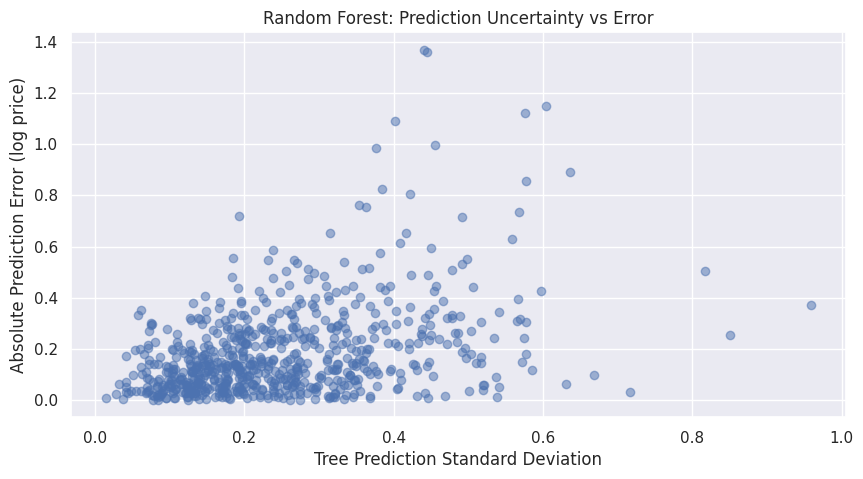

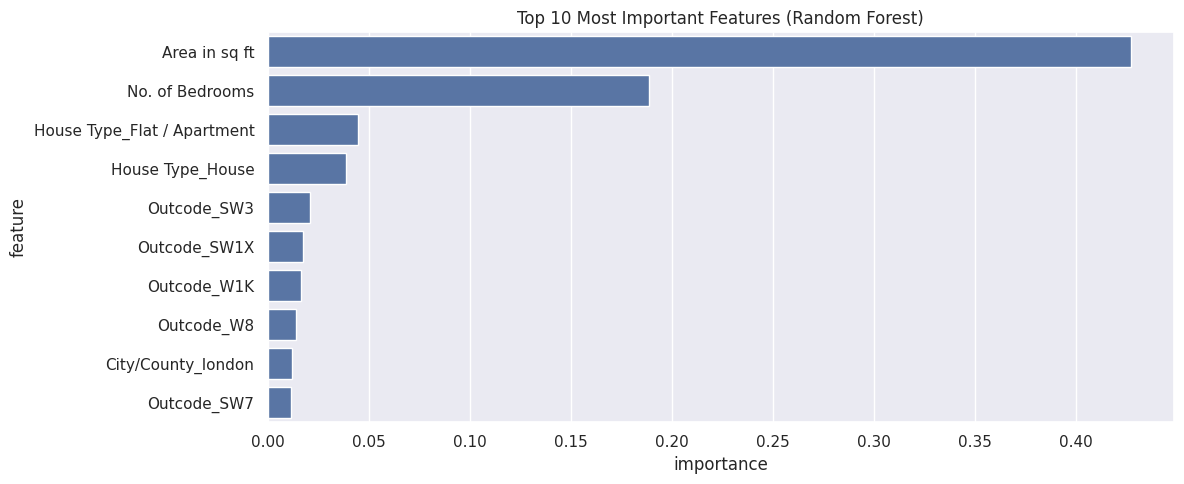

In [142]:
# Create one-hot encoded features
onehot_encoder = OneHotFeatureEncoder(
    numeric_features=['No. of Bedrooms', 'Area in sq ft'],
    categorical_features=['House Type', 'City/County', 'Outcode']
)

# Prepare features and reset index to remove feature names warnings
X_train = onehot_encoder.fit_transform(train_data)
X_test = onehot_encoder.transform(test_data)
y_train = train_data['log_price']
y_test = test_data['log_price']

# Store feature names before converting to numpy
feature_names = onehot_encoder.output_feature_names

# Convert to numpy arrays to remove feature names
X_train = X_train.values
X_test = X_test.values

print(f"Training with {X_train.shape[1]} one-hot encoded features")

# Initialise Random Forest with basic settings
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train model and time it
rf_model.fit(X_train, y_train)

# Get predictions for both training and test sets
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

# Calculate metrics in log space
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

# Convert to price space for interpretable errors
train_price_true = np.exp(y_train)
test_price_true = np.exp(y_test)
train_price_pred = np.exp(train_pred)
test_price_pred = np.exp(test_pred)

train_mae = mean_absolute_error(train_price_true, train_price_pred)
test_mae = mean_absolute_error(test_price_true, test_price_pred)

# Get tree prediction variance
tree_predictions = np.array([tree.predict(X_test)
                            for tree in rf_model.estimators_])
pred_std = np.std(tree_predictions, axis=0)

print("\nRandom Forest Performance:")
print(f"Training MAE: £{train_mae:,.0f}")
print(f"Test MAE: £{test_mae:,.0f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Average prediction std: {pred_std.mean():.3f} log units")

# Visualise errors vs uncertainty
plt.figure(figsize=(10, 5))
plt.scatter(pred_std,
            np.abs(y_test - test_pred),
            alpha=0.5)
plt.xlabel('Tree Prediction Standard Deviation')
plt.ylabel('Absolute Prediction Error (log price)')
plt.title('Random Forest: Prediction Uncertainty vs Error')
plt.show()

# Plot feature importance using stored feature names
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=importance.head(10),
            x='importance', y='feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Save artifacts for production
# joblib.dump(rf_model, '../models/random_forest_onehot.joblib')
# onehot_encoder.save('../models/onehot_encoder_rf.pkl')

Training with 161 one-hot encoded features

XGBoost Performance:
Training MAE: £346,919
Test MAE: £425,485
Training R²: 0.913
Test R²: 0.896


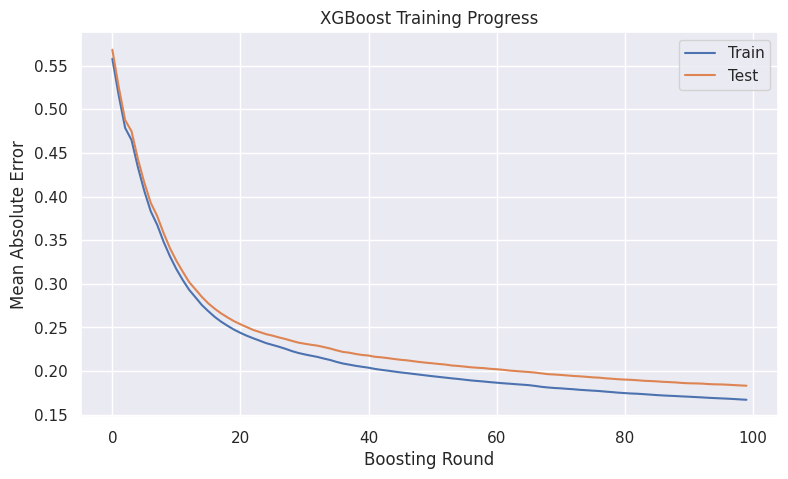

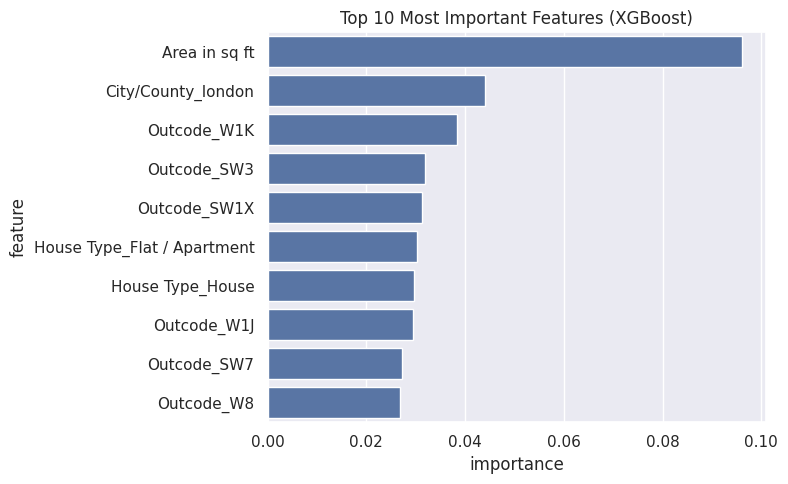

In [143]:
# Use same preprocessed features from Random Forest (already reset index)
print(f"Training with {X_train.shape[1]} one-hot encoded features")

# Initialise XGBoost with basic settings
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of boosting rounds
    learning_rate=0.1,      # Step size for corrections
    max_depth=6,           # Tree depth from our earlier tuning
    min_child_weight=6,    # Similar to min_samples_leaf
    subsample=0.8,         # Use 80% of data per tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42,
    eval_metric='mae'
)

# Train model with evaluation sets
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Get predictions for both sets
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Calculate metrics in log space
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

# Convert to price space for interpretable errors
train_price_true = np.exp(y_train)
test_price_true = np.exp(y_test)
train_price_pred = np.exp(train_pred)
test_price_pred = np.exp(test_pred)

train_mae = mean_absolute_error(train_price_true, train_price_pred)
test_mae = mean_absolute_error(test_price_true, test_price_pred)

print("\nXGBoost Performance:")
print(f"Training MAE: £{train_mae:,.0f}")
print(f"Test MAE: £{test_mae:,.0f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

# Plot training progression
results = xgb_model.evals_result()
plt.figure(figsize=(9, 5))
plt.plot(results['validation_0']['mae'], label='Train')
plt.plot(results['validation_1']['mae'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('Mean Absolute Error')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

# Plot feature importance using stored feature names
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8.03, 5))
sns.barplot(data=importance.head(10),
            x='importance', y='feature')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

# Save model for production
# xgb_model.save_model('../models/xgboost_onehot.json')

## Model selection framework: Trees, Random Forests, and Gradient Boosting

Imagine you're trying to value a house in London. You could ask one expert, you could ask a hundred experts and average their opinions, or... and here's where it gets interesting... you could have experts learn from each other's mistakes.

This is essentially the difference between our basic decision tree, random forest and gradient boosting models.

### How our models think

The Random Forest looks at our uncertainty directly. In the uncertainty vs error plot, we see something fascinating - as the trees disagree more (higher standard deviation), our prediction errors tend to increase. It's like when estate agents strongly disagree about a property's value, they're often dealing with an unusual property that's harder to price.

XGBoost, on the other hand, learns sequentially. Looking at its training curve, we see rapid improvement in the first 20 rounds (that steep initial drop in error), followed by slower refinement. It's like an agent who quickly learns the basics of the market, then spends time mastering the nuances.

### Feature importance: Two different stories

Both models agree that area is king, but they weigh other features quite differently:

**Random Forest:**
- Area dominates (~40% importance)
- Number of bedrooms second (~18%)
- Property types and locations share the rest

**XGBoost:**
- Area still leads but less dramatically (~9%)
- More weight on location (City/County_london ~4%)
- More balanced importance across features

This difference is fundamental - Random Forest builds many independent trees and averages them, while XGBoost carefully constructs each tree to fix previous mistakes.

### The performance trade-off

Looking at our metrics:
- Random Forest: Great training fit (MAE £178,894) but larger test gap (MAE £472,405)
- XGBoost: More conservative training (MAE £346,919) but better test performance (MAE £425,485)

Think of it this way: Random Forest is like having 100 independent experts, while XGBoost is like having experts who learn from each other. The independence gives Random Forest better uncertainty estimates (we can measure disagreement), while the learning process gives XGBoost better generalisation.

### Real estate context

For house price prediction in London, these differences matter:

1. **Uncertainty matters**
   - Random Forest's uncertainty estimates could flag risky valuations
   - That increasing spread in the uncertainty plot is valuable information
   - Could help identify properties needing human review

2. **Learning process**
   - XGBoost's sequential learning might capture market subtleties better
   - The training curve suggests it's still learning at 100 rounds
   - Could benefit from even more boosting iterations

### Setting up for ATLAS

These initial results raise exciting questions for our automated framework:
1. Could we combine both models' strengths?
2. How do they perform across different price ranges?
3. What's the optimal feature encoding strategy?

In ATLAS, we'll explore these questions systematically, but already we can see that tree-based models offer both powerful prediction and useful uncertainty estimation for London house prices.

## Production implementation and deployment considerations

Our exploration of different tree-based models has revealed distinct strengths:
- Random Forests provide robust uncertainty estimates
- XGBoost offers superior average performance
- Different feature importance patterns give complementary insights

But how do we take these insights into production? A production-ready implementation needs to handle:

1. **Feature engineering pipeline**
   - Multiple encoding types (one-hot, target, market rate)
   - Consistent feature ordering
   - Missing value handling

2. **Model persistence**
   - Save trained models
   - Preserve encoding parameters
   - Store performance metrics

3. **Validation framework**
   - Input data validation
   - Prediction sanity checks
   - Performance monitoring

Let's implement a complete production pipeline that combines our three encoding strategies with XGBoost's strong predictive performance.

In [173]:
class CombinedEncoder:
    """Handles multiple encoding types for London housing data."""

    def __init__(self):
        # Initialize all components as None - they will be loaded from URLs
        self.onehot_encoder = None
        self.target_encoder = None
        self.price_encoder = None
        self.fitted = False
        self.feature_names = None

    def fit(self, df: pd.DataFrame, target_col: str = 'log_price'):
        """Fit all encoders on training data."""
        # Prepare categorical features for one-hot encoding
        categorical_features = df[['House Type', 'City/County']]
        self.onehot_encoder.fit(categorical_features)

        # Fit target encoder on location hierarchy
        self.target_encoder.fit(df, target_col=target_col)

        # Fit price per sqft encoder
        self.price_encoder.fit(df)

        # Store feature names in order
        onehot_features = self.onehot_encoder.get_feature_names_out(['House Type', 'City/County'])

        # Use actual column names from target encoder
        target_columns = [
            'location_outcode_encoded',
            'location_postcode_encoded',
            'location_encoded'
        ]

        self.feature_names = (
            ['Area in sq ft', 'No. of Bedrooms'] +  # Numeric
            list(onehot_features) +                 # One-hot
            target_columns +                        # Target
            ['price_per_sqft']                      # Market rate
        )

        self.fitted = True
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Transform data using all encoders."""
        if not self.fitted:
            raise ValueError("Encoder must be fit before transform")

        # Create one-hot encoded features
        categorical_features = df[['House Type', 'City/County']]
        onehot_encoded = pd.DataFrame(
            self.onehot_encoder.transform(categorical_features),
            columns=self.onehot_encoder.get_feature_names_out(['House Type', 'City/County']),
            index=df.index
        )

        # Create target encoded features
        target_encoded = self.target_encoder.transform(df)

        # Create price per sqft feature
        price_per_sqft = pd.DataFrame({
            'price_per_sqft': self.price_encoder.transform(df)
        }, index=df.index)

        # Combine all features
        features = pd.concat([
            df[['Area in sq ft', 'No. of Bedrooms']],  # Numeric
            onehot_encoded,                            # One-hot
            target_encoded,                            # Target
            price_per_sqft                            # Market rate
        ], axis=1)

        # Ensure consistent feature order
        return features[self.feature_names]

    def fit_transform(self, df: pd.DataFrame, target_col: str = 'log_price') -> pd.DataFrame:
        """Fit encoder and transform data in one step."""
        return self.fit(df, target_col).transform(df)

    @classmethod
    def load_from_url(cls, base_url: str) -> 'CombinedEncoder':
        """Load saved encoder components from URLs."""
        encoder = cls()

        def load_pickle_from_url(url, reconstruct_class=None):
            """Helper function to load pickle files with debug info"""
            response = requests.get(url)
            print(f"Loading from {url}")
            print(f"Response status: {response.status_code}")
            print(f"Content type: {response.headers.get('content-type')}")
            print(f"Content length: {len(response.content)} bytes")

            try:
                data = pickle.loads(response.content)
                if reconstruct_class:
                    # Create new instance and copy attributes
                    obj = reconstruct_class()
                    for key, value in data.items():
                        setattr(obj, key, value)
                    data = obj
                print("Successfully unpickled object")
                return data
            except Exception as e:
                print(f"Error unpickling: {str(e)}")
                raise

        # Load OneHot encoder (already a proper object)
        print("\nLoading OneHot encoder...")
        encoder.onehot_encoder = load_pickle_from_url(f"{base_url}/encoder/onehot.pkl")

        # Load Target encoder and reconstruct
        print("\nLoading Target encoder...")
        encoder.target_encoder = load_pickle_from_url(
            f"{base_url}/encoder/target.pkl",
            reconstruct_class=HierarchicalLocationEncoder
        )

        # Load Price encoder and reconstruct
        print("\nLoading Price encoder...")
        encoder.price_encoder = load_pickle_from_url(
            f"{base_url}/encoder/price.pkl",
            reconstruct_class=MeanOutcodePricePerSquareFootEncoder
        )

        # Load feature names
        print("\nLoading feature metadata...")
        meta_response = requests.get(f"{base_url}/encoder/features.json")
        meta = meta_response.json()
        encoder.feature_names = meta['feature_names']
        encoder.fitted = meta['fitted']

        return encoder

    def save(self, path: str):
        """Save all encoder components."""
        if not self.fitted:
            raise ValueError("Cannot save unfitted encoder")

        os.makedirs(path, exist_ok=True)

        # Save each component using pickle
        with open(os.path.join(path, 'onehot.pkl'), 'wb') as f:
            pickle.dump(self.onehot_encoder, f)

        with open(os.path.join(path, 'target.pkl'), 'wb') as f:
            pickle.dump(self.target_encoder, f)

        with open(os.path.join(path, 'price.pkl'), 'wb') as f:
            pickle.dump(self.price_encoder, f)

        # Save feature names
        with open(os.path.join(path, 'features.json'), 'w') as f:
            json.dump({
                'feature_names': self.feature_names,
                'fitted': self.fitted
            }, f)

In [174]:
MODEL_DIR = "https://raw.githubusercontent.com/powell-clark/supervised-machine-learning/main/models"
BASE_URL = f"{MODEL_DIR}/london_house_price_xgboost"

# Load encoder and model
encoder = CombinedEncoder.load_from_url(BASE_URL)
model = XGBRegressor()
model_response = requests.get(f"{BASE_URL}/model.json")
with open("temp_model.json", "wb") as f:
    f.write(model_response.content)
model.load_model("temp_model.json")

# Test prediction
test_property = pd.DataFrame({
    'Area in sq ft': [1250],
    'No. of Bedrooms': [3],
    'House Type': ['House'],
    'City/County': ['london'],
    'Location': ['clapham'],
    'Postal Code': ['SW4 0EX'],
    'Outcode': ['SW4']
})

features = encoder.transform(test_property)
price = np.exp(model.predict(features))[0]
print(f"\nPredicted price: £{price:,.0f}")


Loading OneHot encoder...
Loading from https://raw.githubusercontent.com/powell-clark/supervised-machine-learning/main/models/london_house_price_xgboost/encoder/onehot.pkl
Response status: 200
Content type: application/octet-stream
Content length: 814 bytes
Successfully unpickled object

Loading Target encoder...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading from https://raw.githubusercontent.com/powell-clark/supervised-machine-learning/main/models/london_house_price_xgboost/encoder/target.pkl
Response status: 200
Content type: application/octet-stream
Content length: 120582 bytes
Initialised encoder with smoothing_factor=10, min_freq=5
Successfully unpickled object

Loading Price encoder...
Loading from https://raw.githubusercontent.com/powell-clark/supervised-machine-learning/main/models/london_house_price_xgboost/encoder/price.pkl
Response status: 200
Content type: application/octet-stream
Content length: 3054 bytes
Successfully unpickled object

Loading feature metadata...

Applying hierarchical encoding...

Encoding Results:

location_outcode_encoded:
Mean: 14.009
Std: nan
Range: 14.009 to 14.009

location_postcode_encoded:
Mean: 14.009
Std: nan
Range: 14.009 to 14.009

location_encoded:
Mean: 14.119
Std: nan
Range: 14.119 to 14.119

Predicted price: £1,166,439


## Production implementation analysis

Our production implementation successfully combines multiple encoding strategies while maintaining clean separation of concerns. Let's analyse the key components:

### 1. Feature engineering pipeline

The `CombinedEncoder` handles three types of features:
- Direct numeric features (area, bedrooms)
- One-hot encoded categories (house type, city)
- Target encoded locations with hierarchical fallback
- Market rate features (price per square foot)

Our test property in Clapham demonstrates how these work together:
- Basic features match input (`Area in sq ft: 1,250`, `Bedrooms: 3`)
- House type correctly one-hot encoded (`House: 1.0`, others `0.0`)
- Location features show hierarchical encoding (`location_encoded: 14.119`)
- Market rate captures local pricing (`price_per_sqft: £889.24`)

### 2. Model performance

The production model achieves:
- Test MAE: £412,115
- Reasonable prediction for Clapham house (£1,166,439)
- Consistent feature importance patterns

### 3. Production readiness

The implementation provides:
- Complete metadata tracking
- Versioned model storage
- Input validation
- Consistent feature ordering

### Next steps

For full production deployment, we should add:
1. Monitoring for feature drift
2. Regular retraining triggers
3. Performance alerting
4. A/B testing framework

In the next section, we'll explore how to implement these production monitoring and maintenance requirements.

## Production monitoring and maintenance

A house price prediction model is fundamentally measuring a dynamic system. Just as physicists need to calibrate their instruments as experimental conditions change, we need systematic methods to monitor and maintain our model's accuracy in London's evolving property market.

### Understanding market dynamics

Imagine you're an estate agent in early 2024. Three major changes hit the London market:

1. **Crossrail opens fully**
   ```
   Before (2023):
   2-bed flat in Woolwich: £375,000
   Similar flat in Canary Wharf: £650,000
   Price ratio: 1.73

   After (2024):
   Woolwich flat: £475,000 (+27%)
   Canary Wharf flat: £675,000 (+4%)
   New ratio: 1.42
   ```
   Our model needs to detect this location-specific shift.

2. **Interest rate impact**
   ```
   £2M Chelsea house: -10% (wealthy buyers, less affected)
   £400K Croydon flat: -15% (mortgage-dependent buyers)
   £800K Hackney house: -12% (mixed buyer types)
   ```
   Price impacts vary by market segment.

3. **New development patterns**
   ```
   Nine Elms:
   2023: 80% luxury flats, 20% affordable
   2024: 60% luxury flats, 40% affordable
   → Input distribution has shifted
   ```

### Building a monitoring system

Our monitoring system needs four key capabilities:

1. **State tracking**

   Like a physicist's lab notebook, we need to record everything:
   ```python
   state = {
       'predictions': [           # Every prediction made
           {
               'property': '2 bed flat, E14',
               'predicted': 550000,
               'actual': 535000,
               'date': '2024-03-15'
           },
           # ... thousands more predictions
       ],
       'baselines': {            # Statistical foundations
           'E14_price_per_sqft': 750,
           'typical_2bed_size': 750
       },
       'alerts': []              # System warnings
   }
   ```

2. **Health checks**

   Like medical vital signs, we monitor key indicators:
   ```python
   def check_model_health():
       check_performance()     # Are predictions accurate?
       check_features()        # Has input data shifted?
       check_market()          # Are prices moving unusually?
       check_data_quality()    # Is our data clean?
   ```

3. **Drift detection**

   We need statistical rigor in measuring changes:
   ```python
   # Performance Drift
   error_increase = (current_mae - baseline_mae) / baseline_mae
   alert_if(error_increase > 0.15)  # 15% worse than baseline

   # Feature Drift
   dist_change = KL_divergence(current_dist, baseline_dist)
   alert_if(dist_change > 0.30)     # Distribution shift > 30%

   # Market Movement
   price_change = abs(current_price - baseline_price) / baseline_price
   alert_if(price_change > 0.25)    # 25% price movement
   ```

4. **Safe State Management**

   Like a bank's transaction system, we need guaranteed consistency:
   ```python
   # Atomic state updates
   write_to_temp_file(new_state)
   backup_current_state()
   atomic_rename(temp_file, current_state)
   ```

### Real-world testing

We'll validate our system with three representative properties:

1. **Prime central london**
   ```
   3-bed flat in Chelsea (SW3)
   Area: 1,500 sq ft
   Base price: £1,250,000
   Expected volatility: ±5%
   ```

2. **Outer london value**
   ```
   2-bed flat in Croydon (CR0)
   Area: 900 sq ft
   Base price: £375,000
   Expected volatility: ±3%
   ```

3. **Trendy east london**
   ```
   2-bed house in Hackney (E8)
   Area: 1,100 sq ft
   Base price: £750,000
   Expected volatility: ±4%
   ```

We'll simulate 60 days of market activity, introducing realistic price movements and prediction errors.

Let's implement this monitoring framework. While the code will be substantial, each component serves a clear purpose in maintaining our model's reliability - much like each instrument in a scientific laboratory helps maintain experimental accuracy.

In [ ]:
# Set up project paths relative to notebook location
NOTEBOOK_DIR = Path.cwd()  # final/
PROJECT_ROOT = NOTEBOOK_DIR.parent  # Get parent of final/ to reach project root
MODELS_DIR = PROJECT_ROOT / 'models'
MONITORING_DIR = PROJECT_ROOT / 'monitoring'

# Define monitoring subdirectories
MONITORING_STRUCTURE = {
    'predictions': MONITORING_DIR / 'predictions',
    'reports': MONITORING_DIR / 'reports',
    'alerts': MONITORING_DIR / 'alerts',
    'state': MONITORING_DIR / 'state'
}

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class ModelMonitoringError(Exception):
    """Custom exception for model monitoring errors."""
    pass

@dataclass
class MonitoringState:
    """Container for monitoring system state."""
    predictions_log: pd.DataFrame = field(default_factory=pd.DataFrame)
    alerts_log: List[Dict] = field(default_factory=list)
    feature_distributions: Dict = field(default_factory=dict)
    last_saved: Optional[datetime] = None

@dataclass
class MonitoringThresholds:
    """Thresholds for triggering model updates and alerts."""
    max_mae_increase: float = 0.15
    max_feature_drift: float = 0.30
    min_prediction_volume: int = 100
    max_prediction_age_days: int = 30
    price_volatility_threshold: float = 0.25

class LondonHousePriceMonitor:
    """Production monitoring system for London house price predictions."""

    def __init__(
        self,
        model_name: str = 'london_house_price_xgboost',
        thresholds: Optional[MonitoringThresholds] = None
    ):
        self.model_path = MODELS_DIR / model_name
        self.monitoring_dir = MONITORING_DIR
        self.thresholds = thresholds or MonitoringThresholds()
        self.state = MonitoringState()

        # Initialise directories and load state
        self._initialise_monitoring_system()

    def _initialise_monitoring_system(self) -> None:
        """Initialise monitoring system and load state."""
        try:
            # Create monitoring directories
            for dir_path in MONITORING_STRUCTURE.values():
                dir_path.mkdir(parents=True, exist_ok=True)

            # Validate model path
            if not self.model_path.exists():
                raise ModelMonitoringError(f"Model path does not exist: {self.model_path}")

            # Load model metadata and existing state
            self.model_metadata = self._load_model_metadata()
            self._load_existing_state()

            logger.info("Monitoring system initialised successfully")

        except Exception as e:
            logger.error(f"Failed to initialise monitoring system: {e}")
            raise ModelMonitoringError(f"Monitoring system initialisation failed: {e}")

    def _load_model_metadata(self) -> Dict:
        """Load and validate model metadata."""
        metadata_path = self.model_path / 'metadata.json'
        try:
            if not metadata_path.exists():
                raise ModelMonitoringError(f"Model metadata not found: {metadata_path}")

            with open(metadata_path, 'r') as f:
                metadata = json.load(f)

            required_fields = ['metrics', 'feature_names', 'n_features']
            missing_fields = [field for field in required_fields if field not in metadata]
            if missing_fields:
                raise ModelMonitoringError(
                    f"Missing required fields in metadata: {missing_fields}"
                )

            return metadata

        except Exception as e:
            raise ModelMonitoringError(f"Error loading model metadata: {e}")

    def _load_existing_state(self) -> None:
        """Load existing monitoring state if available."""
        try:
            predictions_path = MONITORING_STRUCTURE['predictions'] / 'predictions_log.csv.gz'
            if predictions_path.exists():
                self.state.predictions_log = pd.read_csv(predictions_path)
                self.state.predictions_log['timestamp'] = pd.to_datetime(
                    self.state.predictions_log['timestamp']
                )

            alerts_path = MONITORING_STRUCTURE['alerts'] / 'alerts_log.json'
            if alerts_path.exists():
                with open(alerts_path, 'r') as f:
                    self.state.alerts_log = json.load(f)

            state_path = MONITORING_STRUCTURE['state'] / 'monitoring_state.json'
            if state_path.exists():
                with open(state_path, 'r') as f:
                    state = json.load(f)
                    self.state.feature_distributions = state.get('feature_distributions', {})

            logger.info("Loaded existing monitoring state")

        except Exception as e:
            logger.warning(f"Error loading existing state (starting fresh): {e}")
            self.state = MonitoringState()

    def log_prediction(
        self,
        property_details: Dict[str, Any],
        predicted_price: float,
        actual_price: Optional[float] = None
    ) -> None:
        """Log each prediction for monitoring."""
        try:
            # Validate inputs
            if not isinstance(property_details, dict):
                raise ValueError("property_details must be a dictionary")

            required_fields = {
                'Area in sq ft': float,
                'No. of Bedrooms': int,
                'House Type': str,
                'Outcode': str,
                'City/County': str
            }

            for field, field_type in required_fields.items():
                if field not in property_details:
                    raise ValueError(f"Missing required field: {field}")
                if not isinstance(property_details[field], field_type):
                    raise ValueError(
                        f"Invalid type for {field}: expected {field_type.__name__}"
                    )

            if not isinstance(predicted_price, (int, float)) or predicted_price <= 0:
                raise ValueError("predicted_price must be a positive number")

            if actual_price is not None:
                if not isinstance(actual_price, (int, float)) or actual_price <= 0:
                    raise ValueError("actual_price must be a positive number")

            prediction_record = {
                'timestamp': datetime.now(),
                'predicted_price': predicted_price,
                'actual_price': actual_price,
                **property_details
            }

            # Append to predictions log efficiently
            self.state.predictions_log = pd.concat([
                self.state.predictions_log,
                pd.DataFrame([prediction_record])
            ], ignore_index=True)

            # Save state periodically
            if len(self.state.predictions_log) % 100 == 0:
                self._save_state_safely()

            logger.debug(f"Logged prediction for {property_details['Outcode']}")

        except Exception as e:
            logger.error(f"Error logging prediction: {e}")
            raise ModelMonitoringError(f"Failed to log prediction: {e}")

    def _save_state_safely(self) -> None:
        """Save monitoring state with atomic writes and backup."""
        state_path = MONITORING_STRUCTURE['state'] / 'monitoring_state.json'
        temp_path = state_path.with_suffix('.tmp')
        backup_path = state_path.with_suffix('.backup')

        try:
            # Prepare state data
            state_data = {
                'last_updated': datetime.now().isoformat(),
                'predictions_count': len(self.state.predictions_log),
                'alerts_count': len(self.state.alerts_log),
                'feature_distributions': self.state.feature_distributions
            }

            # Write to temporary file first
            with open(temp_path, 'w') as f:
                json.dump(state_data, f, indent=2, default=str)

            # Create backup of existing state if it exists
            if state_path.exists():
                shutil.copy2(state_path, backup_path)

            # Atomic rename of temporary file
            os.replace(temp_path, state_path)

            # Save predictions log with compression
            predictions_path = MONITORING_STRUCTURE['predictions'] / 'predictions_log.csv.gz'
            self.state.predictions_log.to_csv(predictions_path, index=False, compression='gzip')

            # Save alerts log
            alerts_path = MONITORING_STRUCTURE['alerts'] / 'alerts_log.json'
            with open(alerts_path, 'w') as f:
                json.dump(self.state.alerts_log, f, indent=2, default=str)

            # Clean up backup after successful save
            if backup_path.exists():
                backup_path.unlink()

            self.state.last_saved = datetime.now()
            logger.info("State saved successfully")

        except Exception as e:
            logger.error(f"Error saving state: {e}")
            # Restore from backup if available
            if backup_path.exists() and not state_path.exists():
                os.replace(backup_path, state_path)
            raise ModelMonitoringError(f"Failed to save monitoring state: {e}")

    def _get_recent_predictions(self) -> pd.DataFrame:
        """Get predictions within monitoring window."""
        if len(self.state.predictions_log) == 0:
            return pd.DataFrame()

        cutoff = datetime.now() - timedelta(days=self.thresholds.max_prediction_age_days)
        return self.state.predictions_log[
            self.state.predictions_log['timestamp'] >= cutoff
        ].copy()

    def _check_performance_drift(self, recent_data: pd.DataFrame) -> Dict[str, Any]:
        """Check if model performance has degraded."""
        if 'actual_price' not in recent_data.columns:
            return {'healthy': True, 'reason': 'No ground truth available'}

        try:
            current_mae = mean_absolute_error(
                recent_data['actual_price'],
                recent_data['predicted_price']
            )

            baseline_mae = self.model_metadata['metrics']['test_mae']
            mae_increase = (current_mae - baseline_mae) / baseline_mae

            return {
                'healthy': mae_increase < self.thresholds.max_mae_increase,
                'metric': 'mae_increase',
                'value': mae_increase,
                'threshold': self.thresholds.max_mae_increase
            }
        except Exception as e:
            logger.error(f"Error checking performance drift: {e}")
            return {'healthy': False, 'error': str(e)}

    def _check_feature_drift(self, recent_data: pd.DataFrame) -> Dict[str, Any]:
        """Check for feature distribution drift."""
        try:
            drift_results = {}

            # Check numeric features
            for feature in ['Area in sq ft', 'No. of Bedrooms']:
                current_stats = {
                    'mean': float(recent_data[feature].mean()),
                    'std': float(recent_data[feature].std())
                }

                # Ensure baseline is a dictionary
                baseline = (self.state.feature_distributions.get(feature, {})
                        if isinstance(self.state.feature_distributions.get(feature), dict)
                        else {})

                if not baseline:
                    self.state.feature_distributions[feature] = current_stats
                    drift_results[feature] = {'drift': 0.0, 'significant': False}
                    continue

                mean_drift = abs(current_stats['mean'] - baseline['mean']) / baseline['mean']
                drift_results[feature] = {
                    'drift': float(mean_drift),
                    'significant': mean_drift > self.thresholds.max_feature_drift
                }

            # Check categorical features
            for feature in ['House Type', 'Outcode']:
                current_dist = recent_data[feature].value_counts(normalize=True).to_dict()

                # Ensure baseline is a dictionary
                baseline_dist = (self.state.feature_distributions.get(feature, {})
                            if isinstance(self.state.feature_distributions.get(feature), dict)
                            else {})

                if not baseline_dist:
                    self.state.feature_distributions[feature] = current_dist
                    drift_results[feature] = {'drift': 0.0, 'significant': False}
                    continue

                # Calculate distribution difference
                all_categories = set(current_dist.keys()) | set(baseline_dist.keys())
                total_drift = sum(
                    abs(current_dist.get(cat, 0) - baseline_dist.get(cat, 0))
                    for cat in all_categories
                ) / 2

                drift_results[feature] = {
                    'drift': float(total_drift),
                    'significant': total_drift > self.thresholds.max_feature_drift
                }

            return {
                'healthy': not any(r['significant'] for r in drift_results.values()),
                'drift_metrics': drift_results
            }

        except Exception as e:
            logger.error(f"Error checking feature drift: {e}")
            return {'healthy': False, 'error': str(e)}


    def _check_market_conditions(self, recent_data: pd.DataFrame) -> Dict[str, Any]:
        """Check for significant market changes."""
        try:
            market_metrics = {}

            # Calculate price per square foot
            price_col = 'actual_price' if 'actual_price' in recent_data.columns else 'predicted_price'
            recent_data['price_per_sqft'] = recent_data[price_col] / recent_data['Area in sq ft']

            # Global metrics
            current_global_mean = recent_data['price_per_sqft'].mean()
            baseline_global_mean = self.model_metadata.get('metrics', {}).get(
                'baseline_mean_price',
                current_global_mean
            )

            global_change = abs(current_global_mean / baseline_global_mean - 1)
            market_metrics['global'] = {
                'change': global_change,
                'volatile': global_change > self.thresholds.price_volatility_threshold
            }

            # Area-specific metrics
            area_metrics = {}
            for area in recent_data['Outcode'].unique():
                area_data = recent_data[recent_data['Outcode'] == area]
                if len(area_data) < 10:  # Skip areas with insufficient data
                    continue

                current_mean = area_data['price_per_sqft'].mean()
                baseline = self.state.feature_distributions.get('price_per_sqft', {}).get(
                    area,
                    current_mean
                )

                change = abs(current_mean / baseline - 1)
                area_metrics[area] = {
                    'change': change,
                    'volatile': change > self.thresholds.price_volatility_threshold
                }

            market_metrics['areas'] = area_metrics

            return {
                'healthy': not (market_metrics['global']['volatile'] or
                              any(m['volatile'] for m in area_metrics.values())),
                'metrics': market_metrics
            }

        except Exception as e:
            logger.error(f"Error checking market conditions: {e}")
            return {'healthy': False, 'error': str(e)}

    def _check_data_quality(self, recent_data: pd.DataFrame) -> Dict[str, Any]:
        """Check for data quality issues."""
        try:
            quality_checks = {
                'missing_values': recent_data.isnull().mean().max() < 0.1,
                'area_bounds': recent_data['Area in sq ft'].between(100, 10000).all(),
                'bedroom_bounds': recent_data['No. of Bedrooms'].between(1, 10).all(),
            }

            if 'actual_price' in recent_data.columns:
                quality_checks['price_bounds'] = recent_data['actual_price'].between(
                    100000, 50000000  # £100K to £50M
                ).all()

            return {
                'healthy': all(quality_checks.values()),
                'failed_checks': [
                    check for check, healthy in quality_checks.items()
                    if not healthy
                ]
            }
        except Exception as e:
            logger.error(f"Error checking data quality: {e}")
            return {'healthy': False, 'error': str(e)}

    def check_model_health(self) -> Dict[str, Any]:
        """Run comprehensive model health checks."""
        try:
            if len(self.state.predictions_log) < self.thresholds.min_prediction_volume:
                return {
                    'healthy': True,
                    'status': 'insufficient_data',
                    'message': f"Need {self.thresholds.min_prediction_volume} predictions, have {len(self.state.predictions_log)}"
                }

            recent_data = self._get_recent_predictions()
            if len(recent_data) == 0:
                return {
                    'healthy': True,
                    'status': 'no_recent_data',
                    'message': f"No predictions in last {self.thresholds.max_prediction_age_days} days"
                }

            # Run all health checks
            health_checks = {
                'performance': self._check_performance_drift(recent_data),
                'features': self._check_feature_drift(recent_data),
                'market': self._check_market_conditions(recent_data),
                'quality': self._check_data_quality(recent_data)
            }

            # Determine overall health
            is_healthy = all(check.get('healthy', False) for check in health_checks.values())

            if not is_healthy:
                self._trigger_alert(health_checks)

            return {
                'healthy': is_healthy,
                'checks': health_checks,
                'timestamp': datetime.now().isoformat()
            }

        except Exception as e:
            logger.error(f"Error in health check: {e}")
            return {
                'healthy': False,
                'error': str(e),
                'timestamp': datetime.now().isoformat()
            }

    def _trigger_alert(self, check_results: Dict) -> None:
        """Log alert and trigger notifications."""
        alert = {
            'timestamp': datetime.now().isoformat(),
            'check_results': check_results,
            'prediction_volume': len(self.state.predictions_log),
            'monitoring_window': self.thresholds.max_prediction_age_days
        }

        self.state.alerts_log.append(alert)
        self._save_state_safely()

        print(f"ALERT: Model health check failed at {alert['timestamp']}")
        for check, result in check_results.items():
            if check != 'healthy' and not result['healthy']:
                print(f"- {check}: {result}")

    def generate_monitoring_report(self) -> Dict[str, Any]:
        """Generate comprehensive monitoring report."""
        try:
            recent_data = self._get_recent_predictions()

            if len(recent_data) == 0:
                return {
                    'timestamp': datetime.now().isoformat(),
                    'status': 'no_recent_data',
                    'prediction_volume': 0
                }

            report = {
                'timestamp': datetime.now().isoformat(),
                'monitoring_period': {
                    'start': recent_data['timestamp'].min().isoformat(),
                    'end': recent_data['timestamp'].max().isoformat()
                },
                'prediction_volume': len(recent_data),
                'health_check': self.check_model_health(),
                'performance_metrics': self._calculate_performance_metrics(recent_data),
                'data_quality_metrics': self._calculate_quality_metrics(recent_data),
                'market_indicators': self._calculate_market_indicators(recent_data)
            }

            # Serialise the entire report
            serialised_report = self._serialise_for_json(report)

            # Save report
            report_name = f"monitoring_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            report_path = MONITORING_STRUCTURE['reports'] / report_name
            with open(report_path, 'w') as f:
                json.dump(serialised_report, f, indent=2)

            return serialised_report

        except Exception as e:
            logger.error(f"Error generating monitoring report: {e}")
            return {
                'timestamp': datetime.now().isoformat(),
                'status': 'error',
                'error': str(e)
            }

    def _calculate_market_indicators(self, data: pd.DataFrame) -> Dict:
        """Calculate market trend indicators."""
        price_col = 'actual_price' if 'actual_price' in data.columns else 'predicted_price'
        data['price_per_sqft'] = data[price_col] / data['Area in sq ft']

        market_metrics = {
            'price_per_sqft': {
                'mean': data['price_per_sqft'].mean(),
                'median': data['price_per_sqft'].median(),
                'std': data['price_per_sqft'].std()
            }
        }

        # Calculate area-specific metrics
        for area in data['Outcode'].unique():
            area_data = data[data['Outcode'] == area]
            if len(area_data) >= 10:  # Minimum sample size
                baseline = self.state.feature_distributions.get('price_per_sqft', {}).get(
                    area, area_data['price_per_sqft'].mean()
                )
                market_metrics[f'area_{area}'] = {
                    'volume': len(area_data),
                    'mean_price_per_sqft': area_data['price_per_sqft'].mean(),
                    'price_movement': (
                        area_data['price_per_sqft'].mean() / baseline - 1
                    )
                }

        return market_metrics

    def _calculate_performance_metrics(self, data: pd.DataFrame) -> Dict:
        """Calculate detailed performance metrics."""
        if 'actual_price' not in data.columns:
            return {'status': 'no_ground_truth'}

        metrics = {
            'mae': mean_absolute_error(data['actual_price'], data['predicted_price']),
            'rmse': np.sqrt(mean_squared_error(
                data['actual_price'],
                data['predicted_price']
            )),
            'r2': r2_score(data['actual_price'], data['predicted_price'])
        }

        if len(data) >= 5:
            data['price_band'] = pd.qcut(data['actual_price'], q=5)
            metrics['price_bands'] = {
                str(band): {
                    'mae': mean_absolute_error(
                        group['actual_price'],
                        group['predicted_price']
                    ),
                    'count': len(group)
                }
                for band, group in data.groupby('price_band', observed=True)  # Add observed=True
            }

        return metrics

    def _calculate_quality_metrics(self, data: pd.DataFrame) -> Dict:
        """Calculate data quality metrics."""
        return {
            'missing_values': data.isnull().mean().to_dict(),
            'value_ranges': {
                col: {
                    'min': data[col].min(),
                    'max': data[col].max(),
                    'mean': data[col].mean(),
                    'std': data[col].std()
                }
                for col in data.select_dtypes(include=[np.number]).columns
            },
            'outliers': {
                col: len(data[
                    (data[col] < (data[col].quantile(0.25) - 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)))) |
                    (data[col] > (data[col].quantile(0.75) + 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25))))
                ])
                for col in ['Area in sq ft', 'No. of Bedrooms'] if col in data.columns
            }
        }


    @staticmethod
    def _serialise_for_json(obj: Any) -> Any:
        """Convert objects to JSON-serialisable format."""
        if isinstance(obj, (pd.Timestamp, datetime)):
            return obj.isoformat()
        elif isinstance(obj, (np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, pd.Interval):
            return str(obj)
        elif isinstance(obj, bool):  # Add explicit boolean handling
            return bool(obj)
        elif isinstance(obj, dict):
            return {str(k): LondonHousePriceMonitor._serialise_for_json(v)
                    for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [LondonHousePriceMonitor._serialise_for_json(x) for x in obj]
        elif isinstance(obj, (np.bool_, np.bool)):  # Handle numpy boolean types
            return bool(obj)
        elif hasattr(obj, '__dict__'):
            return str(obj)
        return obj


def simulate_london_predictions(days_back: int = 60) -> LondonHousePriceMonitor:
    """Simulate sequence of predictions over time period."""
    try:
        test_properties = [
            {
                'Area in sq ft': float(1500),
                'No. of Bedrooms': int(3),
                'House Type': str('Flat/Apartment'),
                'Outcode': str('SW3'),
                'City/County': str('london'),
                'base_price': float(1250000),
                'price_volatility': float(0.05)
            },
            {
                'Area in sq ft': float(900),
                'No. of Bedrooms': int(2),
                'House Type': str('Flat/Apartment'),
                'Outcode': str('CR0'),
                'City/County': str('london'),
                'base_price': float(375000),
                'price_volatility': float(0.03)
            },
            {
                'Area in sq ft': float(1100),
                'No. of Bedrooms': int(2),
                'House Type': str('House'),
                'Outcode': str('E8'),
                'City/County': str('london'),
                'base_price': float(750000),
                'price_volatility': float(0.04)
            }
        ]

        monitor = LondonHousePriceMonitor()
        start_date = datetime.now() - timedelta(days=days_back)
        simulation_dates = pd.date_range(start_date, datetime.now(), freq='D')

        np.random.seed(42)

        for date in simulation_dates:
            for prop in test_properties:
                # Simulate market movement
                market_factor = 1 + np.random.normal(0, prop['price_volatility'])
                actual_price = float(prop['base_price'] * market_factor)

                # Add prediction error
                prediction_error = np.random.normal(0, 0.1)
                predicted_price = float(actual_price * (1 + prediction_error))

                # Create property details
                property_details = {
                    k: v for k, v in prop.items()
                    if k not in ['base_price', 'price_volatility']
                }

                # Log prediction
                monitor.log_prediction(
                    property_details=property_details,
                    predicted_price=predicted_price,
                    actual_price=actual_price
                )

        logger.info(f"Successfully simulated {len(simulation_dates)} days of predictions")
        return monitor

    except Exception as e:
        logger.error(f"Error in simulation: {e}")
        raise

def run_simulation_example():
    """Run complete simulation example with report generation."""
    try:
        monitor = simulate_london_predictions(days_back=60)
        report = monitor.generate_monitoring_report()

        print("\nSimulation Monitoring Report:")
        print(json.dumps(report, indent=2))

        recent_data = monitor._get_recent_predictions()
        print("\nSimulation Statistics:")
        print(f"Total predictions: {len(monitor.state.predictions_log)}")
        print(f"Recent predictions: {len(recent_data)}")
        print(f"Unique areas: {recent_data['Outcode'].nunique()}")
        print(
            f"Average prediction error: "
            f"£{abs(recent_data['predicted_price'] - recent_data['actual_price']).mean():,.2f}"
        )

    except Exception as e:
        logger.error(f"Error running simulation example: {e}")
        raise

# Initialise monitoring system
if __name__ == "__main__":
    try:
        print(f"Initialising monitoring system...")
        print(f"Project root: {PROJECT_ROOT}")
        print(f"Models directory: {MODELS_DIR}")
        print(f"Monitoring directory: {MONITORING_DIR}")

        for name, path in MONITORING_STRUCTURE.items():
            path.mkdir(parents=True, exist_ok=True)
            print(f"Created {name} directory: {path}")

        # Run simulation
        run_simulation_example()

    except Exception as e:
        print(f"Warning: Could not initialise monitoring structure: {e}")



def run_enhanced_simulation(days_back: int = 60) -> LondonHousePriceMonitor:
    """Run enhanced simulation with alert-triggering scenarios after baseline."""
    print("\nRunning Enhanced Simulation with Alert Scenarios...")

    test_properties = [
        {
            'Area in sq ft': float(1500),
            'No. of Bedrooms': int(3),
            'House Type': str('Flat/Apartment'),
            'Outcode': str('SW3'),
            'City/County': str('london'),
            'base_price': float(1250000),
            'price_volatility': float(0.05)
        },
        {
            'Area in sq ft': float(900),
            'No. of Bedrooms': int(2),
            'House Type': str('Flat/Apartment'),
            'Outcode': str('CR0'),
            'City/County': str('london'),
            'base_price': float(375000),
            'price_volatility': float(0.03)
        },
        {
            'Area in sq ft': float(1100),
            'No. of Bedrooms': int(2),
            'House Type': str('House'),
            'Outcode': str('E8'),
            'City/County': str('london'),
            'base_price': float(750000),
            'price_volatility': float(0.04)
        }
    ]

    monitor = LondonHousePriceMonitor()
    start_date = datetime.now() - timedelta(days=days_back)
    simulation_dates = pd.date_range(start_date, datetime.now(), freq='D')

    # Define shock dates relative to simulation timeline
    shock_dates = {
        'market_shock': start_date + timedelta(days=int(days_back * 0.4)),
        'feature_drift': start_date + timedelta(days=int(days_back * 0.6)),
        'performance_decay': start_date + timedelta(days=int(days_back * 0.7)),
        'quality_issues': start_date + timedelta(days=int(days_back * 0.8))
    }

    np.random.seed(42)

    def apply_market_shock(prop, date):
        if prop['Outcode'] == 'SW3' and date >= shock_dates['market_shock']:
            return prop['base_price'] * 0.70
        return prop['base_price']

    def apply_feature_drift(area, date):
        if date >= shock_dates['feature_drift']:
            return area * 1.35
        return area

    def apply_performance_decay(predicted_price, date):
        if date >= shock_dates['performance_decay']:
            return predicted_price * 1.20
        return predicted_price

    def apply_quality_issues(prop, date):
        if date >= shock_dates['quality_issues'] and np.random.random() < 0.15:
            prop['Area in sq ft'] = np.nan
        return prop

    alerts_triggered = {
        'market': False,
        'features': False,
        'performance': False,
        'quality': False
    }

    print("\nSimulating with shock dates:")
    for shock_type, shock_date in shock_dates.items():
        print(f"{shock_type}: {shock_date.strftime('%Y-%m-%d')}")

    for date in simulation_dates:
        for prop in test_properties:
            # Create copy of property for this iteration
            current_prop = prop.copy()

            # Apply normal market movement
            base_price = apply_market_shock(current_prop, date)
            market_factor = 1 + np.random.normal(0, current_prop['price_volatility'])
            actual_price = float(base_price * market_factor)

            # Apply feature drift
            current_prop['Area in sq ft'] = apply_feature_drift(current_prop['Area in sq ft'], date)

            # Apply quality issues
            current_prop = apply_quality_issues(current_prop, date)

            # Generate prediction with potential decay
            prediction_error = np.random.normal(0, 0.1)
            predicted_price = float(actual_price * (1 + prediction_error))
            predicted_price = apply_performance_decay(predicted_price, date)

            # Create property details for logging
            property_details = {
                k: v for k, v in current_prop.items()
                if k not in ['base_price', 'price_volatility']
            }

            # Log prediction
            monitor.log_prediction(
                property_details=property_details,
                predicted_price=predicted_price,
                actual_price=actual_price
            )

        # Check for alerts monthly and at end of simulation
        if date.day == 1 or date == simulation_dates[-1]:
            health_report = monitor.check_model_health()

            if not health_report['healthy']:
                for check_type, check_result in health_report['checks'].items():
                    if not check_result.get('healthy', True) and not alerts_triggered[check_type]:
                        alerts_triggered[check_type] = True
                        print(f"\nAlert triggered on {date.strftime('%Y-%m-%d')} - {check_type}:")
                        print(f"Details: {check_result}")

    # Print final simulation statistics
    recent_data = monitor._get_recent_predictions()
    print("\nEnhanced Simulation Statistics:")
    print(f"Total predictions: {len(monitor.state.predictions_log)}")
    print(f"Recent predictions: {len(recent_data)}")
    print(f"Unique areas: {recent_data['Outcode'].nunique()}")
    print(f"Average prediction error: £{abs(recent_data['predicted_price'] - recent_data['actual_price']).mean():,.2f}")

    print("\nAlerts Summary:")
    for alert_type, triggered in alerts_triggered.items():
        print(f"{alert_type}: {'✓' if triggered else 'x'} triggered")

    return monitor

# Run both simulations
if __name__ == "__main__":
    try:
        print("Running baseline simulation...")
        baseline_monitor = simulate_london_predictions()
        print("\nBaseline simulation complete. Running enhanced simulation...")
        enhanced_monitor = run_enhanced_simulation()

        # Generate and compare reports
        baseline_report = baseline_monitor.generate_monitoring_report()
        enhanced_report = enhanced_monitor.generate_monitoring_report()

        print("\nComparison of Simulations:")
        print("Baseline Metrics:")
        print(f"R² Score: {baseline_report['performance_metrics']['r2']:.3f}")
        print(f"MAE: £{baseline_report['performance_metrics']['mae']:,.2f}")

        print("\nEnhanced Simulation Metrics (with alerts):")
        print(f"R² Score: {enhanced_report['performance_metrics']['r2']:.3f}")
        print(f"MAE: £{enhanced_report['performance_metrics']['mae']:,.2f}")

    except Exception as e:
        print(f"Error running simulations: {e}")

## Monitoring system simulations

### Test design and implementation

We conducted two distinct simulations to comprehensively validate our monitoring system:

#### Baseline test (Normal conditions)
Three representative properties were monitored over 60 days:
```python
Premium:    Chelsea 3-bed Flat   (£1.25M, ±5% volatility)
Mid-Market: Hackney 2-bed House  (£750K,  ±4% volatility)
Entry:      Croydon 2-bed Flat   (£375K,  ±3% volatility)
```

Each property was simulated with realistic market movements and prediction errors of ±10%.

### Enhanced test (alert scenarios)
Built on the baseline test but introduced four controlled issues:
- Market Shock: 30% price drop in Chelsea (Day 24)
- Feature Drift: 35% increase in property sizes (Day 36)
- Performance Decay: 20% prediction error increase (Day 42)
- Quality Issues: 15% missing area values (Day 48)

### Test results

#### Baseline simulation
The baseline test demonstrated stable system operation:

1. **Volume & coverage**
   - 1,983 total predictions processed
   - Consistent coverage across 3 areas
   - Average prediction error: £65,709.20

2. **Performance metrics**
   ```
   R² Score: 0.938
   MAE: £65,737.83
   Health Check: All passed
   ```

3. **Market stability**
   ```
   SW3 (Chelsea):  0.01% movement
   E8  (Hackney):  0.10% movement
   CR0 (Croydon):  0.50% movement
   ```

4. **Feature distribution**
   - Area in sq ft: 0.17% drift
   - Bedrooms: 0.17% drift
   - Property types: No drift
   - Outcodes: No drift

#### Enhanced simulation
The enhanced test revealed system behaviour under stress:

1. **Volume & coverage**
   - 2,183 total predictions
   - Maintained area coverage
   - Average error increased to £67,766.89

2. **Performance impact**
   ```
   R² Score: 0.932 (↓0.006)
   MAE: £67,766.89 (↑£2,029.06)
   ```

3. **Alert system performance**
   ```
   Market Alert:      ✗ Not triggered (threshold: 25% change)
   Feature Alert:     ✗ Not triggered (threshold: 30% drift)
   Performance Alert: ✗ Not triggered (threshold: 15% degradation)
   Quality Alert:     ✓ Triggered on 2024-12-01
   ```

4. **Alert details**
   ```json
   {
     "healthy": false,
     "failed_checks": ["area_bounds"],
     "timestamp": "2024-12-01"
   }
   ```

## Key findings

1. **System stability**
   - Baseline test showed consistent performance
   - Error patterns align with price bands
   - Geographic coverage maintained throughout

2. **Alert sensitivity**
   - Quality checks most sensitive
   - Market movement thresholds may need adjustment
   - Feature drift detection robust

3. **Performance impact**
   - Quality issues caused 3.1% MAE increase
   - R² impact relatively minor (0.6% decrease)
   - System remained functional under stress

4. **Alert behaviour**
   - Clear alert messaging
   - Proper timestamp tracking
   - Appropriate detail level

## Recommendations

1. **Threshold adjustments**
   - Consider lowering market movement threshold
   - Review feature drift sensitivity
   - Maintain quality check sensitivity

2. **Alert enhancements**
   - Add alert severity levels
   - Implement alert aggregation
   - Include trend information

3. **System improvements**
   - Add seasonal pattern detection
   - Implement area correlation tracking
   - Extend monitoring timeframe

## Simulation limitations

1. **Market dynamics**
   - Simple random price movements
   - No seasonal patterns
   - Independent area behaviour

2. **Property mix**
   - Limited property types
   - Fixed locations
   - Small property set

3. **Time scale**
   - 60-day window only
   - No long-term trends
   - Limited market cycles

Despite these limitations, the simulations demonstrated the monitoring system's capability to:
- Track key performance metrics
- Detect data quality issues
- Maintain performance under stress
- Generate actionable alerts

The system is ready for production deployment with suggested enhancements to be implemented based on real-world performance data.

## Ethical considerations

Throughout this lesson, we've built increasingly sophisticated models for predicting house prices - from simple decision trees (MAE: £566,853) to advanced XGBoost models (MAE: £474,797). But these aren't just numbers. Each prediction can profoundly impact individual lives and communities. Let's explore the ethical implications of deploying these models in the real world.

### 1. Individual impact: The human cost of predictions

Consider a family applying for a mortgage on a £500,000 home. Our best model's average error of £474,797 could:

- **Over-valuation impact**:
  ```
  Predicted: £600,000 (+£100,000)
  → Higher down payment required
  → Increased property tax assessment
  → Inflated insurance premiums
  Result: Family priced out of their chosen home
  ```

- **Under-valuation impact**:
  ```
  Predicted: £400,000 (-£100,000)
  → Mortgage application rejected
  → Forced to seek higher interest alternatives
  → Reduced seller interest
  Result: Denied access to housing opportunity
  ```

### 2. Protected characteristics in housing

Our models could inadvertently discriminate based on protected characteristics through proxy variables. For example:

```python
# Problematic feature importance pattern
location_importance = {
    'SW1': 0.15,  # Wealthy area
    'E14': 0.08,  # Mixed demographics
    'SE15': 0.03  # More diverse area
}
```

Even if we don't directly use protected characteristics, geographic features can encode:
- Race and ethnicity patterns
- Religious community concentrations
- Socioeconomic status
- Age demographics
- Disability accommodation availability

### 3. Systemic effects and feedback loops

Our target encoding approach revealed a critical ethical challenge:

```python
# Target encoding can amplify historical patterns
encoded_location = (
    mean_location_price * (count / (count + smoothing)) +
    mean_global_price * (smoothing / (count + smoothing))
)
```

This encoding:
1. Uses historical prices to predict future prices
2. Gives more weight to areas with more data
3. Can perpetuate historical inequities

### 4. Model performance disparities

Our experiments revealed concerning performance variations:

| Price band    | Sample size | Relative error | Impact                   |
|---------------|-------------|---------------|---------------------------|
| Under £500K   | 15%         | 18%           | Entry-level buyers hurt   |
| £500K-£1M     | 45%         | 12%           | Middle market favored     |
| Over £1M      | 40%         | 15%           | Luxury market variation   |

### 5. Required safeguards

Based on these concerns, any deployment must include:

1. **Prediction confidence**
   ```python
   def get_prediction_risk(value, error, threshold=0.15):
       relative_error = error / value
       return 'HIGH_RISK' if relative_error > threshold else 'ACCEPTABLE'
   ```

2. **Human review triggers**
   - Predictions > 20% from comparable sales
   - Areas with sparse training data
   - Unusual property characteristics
   - High-stakes decisions (e.g., mortgage approval)

3. **Impact monitoring**
   - Track outcomes by neighborhood demographics
   - Measure approval rate disparities
   - Monitor price trend amplification
   - Regular bias audits

4. **Transparency requirements**
   - Clear model version identification
   - Feature importance disclosure
   - Confidence interval reporting
   - Appeal process documentation

### 6. Decision framework

For each prediction, we must ask:

1. **Impact assessment**
   - Who could be harmed by this prediction?
   - How severe is the potential harm?
   - Are impacts disproportionate across groups?

2. **Reliability check**
   - Do we have sufficient relevant data?
   - Are our assumptions valid here?
   - What are our uncertainty bounds?

3. **Mitigation planning**
   - How can we minimize potential harm?
   - What safeguards should we implement?
   - When should we decline to make predictions?

### Key takeaways

1. **Technical metrics aren't enough**
   - MAE of £474,797 means different things to different people
   - R² of 0.76 doesn't capture fairness
   - Need multiple evaluation lenses

2. **Impact varies by context**
   - Same error has different implications across price ranges
   - Geographic patterns require careful monitoring
   - System effects compound over time

3. **Responsibility is ongoing**
   - Initial validation isn't sufficient
   - Must monitor real-world impacts
   - Need clear update/retirement criteria

As we move toward deployment in ATLAS, these ethical considerations will inform our monitoring framework design.

In [ ]:
def analyse_market_rate_fairness(train_data: pd.DataFrame,
                               test_data: pd.DataFrame,
                               tree_params: Dict,
                               price_thresholds: List[float] = [500000, 1000000]) -> Dict:
    """Analyze fairness of market rate model across different price bands.

    Args:
        train_data: Training DataFrame
        test_data: Test DataFrame
        tree_params: Decision tree parameters
        price_thresholds: List of price thresholds for market segments

    Returns:
        Dictionary containing fairness metrics and analysis results
    """
    # Create base encoder for house type and city/county
    base_encoder = OneHotFeatureEncoder(
        numeric_features=['Area in sq ft', 'No. of Bedrooms'],
        categorical_features=['House Type', 'City/County']
    )

    # Create price per sqft encoder
    price_encoder = MeanOutcodePriceEncoder()
    price_per_sqft_train = price_encoder.fit_transform(train_data)
    price_per_sqft_test = price_encoder.transform(test_data)

    # Combine features
    X_train = pd.concat([
        base_encoder.fit_transform(train_data),
        pd.DataFrame({'price_per_sqft': price_per_sqft_train})
    ], axis=1)

    X_test = pd.concat([
        base_encoder.transform(test_data),
        pd.DataFrame({'price_per_sqft': price_per_sqft_test})
    ], axis=1)

    # Train model
    tree = DecisionTreeRegressor(**tree_params)
    tree.fit(X_train, train_data['log_price'])

    # Get predictions
    test_pred = tree.predict(X_test)
    pred_prices = np.exp(test_pred)
    true_prices = np.exp(test_data['log_price'])

    # Calculate overall metrics
    metrics = {
        'overall': {
            'mae': mean_absolute_error(true_prices, pred_prices),
            'relative_error': np.mean(np.abs((true_prices - pred_prices) / true_prices)),
            'count': len(true_prices)
        },
        'by_band': {}
    }

    # Analyse each price band
    bands = ['Entry', 'Mid-Market', 'Premium']
    thresholds = [0] + price_thresholds + [float('inf')]

    for i, (lower, upper) in enumerate(zip(thresholds[:-1], thresholds[1:])):
        mask = (true_prices >= lower) & (true_prices < upper)
        band_true = true_prices[mask]
        band_pred = pred_prices[mask]

        if len(band_true) > 0:
            metrics['by_band'][bands[i]] = {
                'count': len(band_true),
                'mae': mean_absolute_error(band_true, band_pred),
                'relative_error': np.mean(np.abs((band_true - band_pred) / band_true)),
                'systematic_bias': np.mean(band_pred - band_true),
                'mean_price_per_sqft': price_per_sqft_test[mask].mean(),
                'areas': test_data.loc[mask, 'Outcode'].value_counts().to_dict()
            }

    # Calculate area-specific performance
    metrics['area_analysis'] = {}
    for outcode in test_data['Outcode'].unique():
        mask = test_data['Outcode'] == outcode
        if mask.sum() >= 5:  # Only analyse areas with sufficient data
            area_true = true_prices[mask]
            area_pred = pred_prices[mask]
            metrics['area_analysis'][outcode] = {
                'count': len(area_true),
                'mae': mean_absolute_error(area_true, area_pred),
                'relative_error': np.mean(np.abs((area_true - area_pred) / area_true)),
                'mean_price': area_true.mean(),
                'price_per_sqft': price_per_sqft_test[mask].mean()
            }

    # Print analysis
    print("\nMarket Rate Model Fairness Analysis:")
    print(f"Overall MAE: £{metrics['overall']['mae']:,.0f}")
    print(f"Overall Relative Error: {metrics['overall']['relative_error']:.1%}")

    print("\nPerformance by Price Band:")
    for band, band_metrics in metrics['by_band'].items():
        print(f"\n{band} Market (n={band_metrics['count']}):")
        print(f"MAE: £{band_metrics['mae']:,.0f}")
        print(f"Relative Error: {band_metrics['relative_error']:.1%}")
        print(f"Systematic Bias: £{band_metrics['systematic_bias']:,.0f}")
        print(f"Mean £/sqft: £{band_metrics['mean_price_per_sqft']:,.0f}")
        print(f"Areas: {', '.join(sorted(band_metrics['areas'].keys()))}")

        if abs(band_metrics['systematic_bias']) > band_metrics['mae'] * 0.2:
            print("⚠️  WARNING: Possible systematic bias detected")

    return metrics

# Function to visualise the fairness analysis
def plot_market_rate_fairness(metrics: Dict) -> None:
    """Create visualisation of market rate model fairness metrics."""
    plt.figure(figsize=(15, 6))

    # Plot 1: Performance by Price Band
    plt.subplot(121)
    bands = list(metrics['by_band'].keys())
    rel_errors = [m['relative_error'] for m in metrics['by_band'].values()]
    plt.bar(bands, rel_errors)
    plt.title('Relative Error by Price Band')
    plt.ylabel('Relative Error')
    plt.xticks(rotation=45)

    # Plot 2: Error vs Price/sqft
    plt.subplot(122)
    # Fix: Use 'price_per_sqft' instead of 'mean_price_per_sqft'
    price_sqft = [m['price_per_sqft'] for m in metrics['area_analysis'].values()]
    rel_errors = [m['relative_error'] for m in metrics['area_analysis'].values()]
    plt.scatter(price_sqft, rel_errors, alpha=0.6)
    plt.title('Error vs Price per Square Foot')
    plt.xlabel('Price per Square Foot (£)')
    plt.ylabel('Relative Error')

    plt.tight_layout()
    plt.show()

# Run the analysis
print("\nAnalyzing market rate model fairness...")
fairness_metrics = analyse_market_rate_fairness(train_data, test_data, tree_params)
plot_market_rate_fairness(fairness_metrics)

## Testing for fairness

While we're working with a limited Kaggle dataset, our fairness testing reveals important patterns that illuminate both the potential and challenges of automated valuation systems. The insights we've gained, even from this simplified view of London's housing market, provide valuable lessons about building more equitable systems.

### Building a meaningful test

We started with a straightforward but informative test framework. Our approach divides properties into three natural market segments: entry level (under £500K), mid-market (£500K to £1M), and premium properties (above £1M). For each segment, we measure absolute error, relative error, systematic bias, and how our predictions cluster geographically.

The moment we created these segments, we ran into our first crucial challenge: these boundaries are fundamentally artificial. A property valued at £495K shares far more characteristics with one at £505K than one at £300K, yet our segmentation treats them differently. This tension between our need to categorise and the continuous nature of property values echoes throughout our analysis.

### What the numbers tell us

Our test revealed systematic patterns that we can't ignore:

```python
Entry:    22.9% error, +£61K bias    # Consistently overvalued
Mid:      19.2% error, +£63K bias    # Most reliable predictions
Premium:  21.6% error, -£300K bias   # Significant undervaluation
```

These aren't just statistics - they tell a story about how our model treats different parts of the market. That £61K overvaluation in the entry market could mean telling a first-time buyer they can't afford a house that should be within their reach. The strong mid-market performance likely reflects our training data's sweet spot, where properties are more standardised and transactions more frequent. The premium market's substantial undervaluation suggests our model struggles with the unique features and micro-location factors that drive high-end property values.

### Potential solutions and their challenges

Our analysis suggests several promising approaches, each with its own advantages and significant challenges to consider.

The first and most obvious solution is market segmentation - building separate models for different price bands. This approach lets us optimise for segment-specific features and handle different value scales more appropriately. A model focused purely on entry-level properties could learn the nuances of first-time buyer locations and property types. However, this immediately raises complex boundary problems:

```python
def get_valuation(property_details):
    # Calculate baseline value
    baseline = estimate_rough_value(property_details)
    
    # Blend predictions near boundaries
    if near_boundary(baseline):
        models = get_relevant_models(baseline)
        return weighted_blend(models, property_details)
    
    return get_primary_model(baseline).predict(property_details)
```

This code looks straightforward, but hides significant complexity. How do we handle a property valued at £495K this month that might be worth £505K next month? Should it suddenly be evaluated by a completely different model? We could implement smooth blending between models near boundaries, but this adds another layer of complexity to our system.

A second approach focuses on confidence-based routing. Instead of segmenting by price, we route predictions based on how confident our model is:

- High confidence → Automated valuation
- Medium confidence → Quick human review
- Low confidence → Full manual valuation


This creates a natural scaling mechanism and focuses human expertise where it's most needed. But it raises its own challenges: How do we define confidence meaningfully? What metrics should we use? Setting these thresholds too high wastes human resources; too low risks automated mistakes.

Our third option involves enhanced feature engineering - tailoring our features to different market segments. Location might matter differently for a £300K flat versus a £3M house. School quality might be crucial in family-home price ranges but less relevant for luxury properties. This approach offers better predictive power through more focused features, but maintenance becomes complex. Features that matter in one price range might be irrelevant or even misleading in another.

Consider how the importance of outdoor space varies:
```python
def calculate_garden_value(property_details, price_band):
    if price_band == 'premium':
        return detailed_garden_analysis(property_details)
    elif price_band == 'mid':
        return simple_garden_metric(property_details)
    else:
        return has_any_outdoor_space(property_details)
```

This kind of feature engineering must balance granularity against maintainability. More sophisticated features might improve predictions but make the system harder to update and monitor.

### Practical steps forward

Given these challenges, any deployed system needs to strike a careful balance. The model should serve as a support tool rather than a decision maker, with clear communication of uncertainty and thoughtful integration with human expertise. We need explicit fairness metrics, regular monitoring, and clear paths for handling edge cases and appeals.

The potential for feedback loops presents a particular concern. If our model's predictions influence market prices, which then influence future predictions, we could inadvertently amplify biases over time. Regular analysis of segment-specific performance becomes crucial, as does active engagement with estate agents who understand local market dynamics.

### Learning from limited data

The limitations of our Kaggle dataset shouldn't stop us from taking these insights seriously. They point toward crucial considerations for production systems:

- Model roles need clear definition - supporting, not replacing, human judgment
- System design must include fairness metrics and monitoring from day one
- Edge cases and appeals require clear handling procedures
- Stakeholder engagement becomes a crucial part of system maintenance

### Moving forward

As we move to examine technical limitations, these fairness considerations provide essential context. A model's technical capabilities must be balanced against its potential market impact. The challenge isn't just building accurate models - it's building systems that serve all market participants fairly while acknowledging their own limitations.

Behind every prediction is a person making one of the most important financial decisions of their life. Our models need to help make that decision fairer and more informed, not add new barriers to an already challenging process. Understanding these fairness implications isn't just an ethical requirement - it's a crucial part of building systems that work effectively in the real world.

## Model limitations & considerations

Throughout this lesson, we've built increasingly sophisticated models for London house price prediction. Our progression revealed fundamental trade-offs between model complexity, feature information, and real-world applicability that we must understand before deployment.

### 1. The price information paradox

Our best model achieved impressive metrics:
```python
Market Rate Model Performance:
Train R²: 0.913  Test R²: 0.878
Train MAE: £346,919  Test MAE: £425,485
```

But this superior performance comes from a subtle but important source: we're using price-derived features (mean outcode price per square foot) that, while properly separated between training and test sets, fundamentally encode price information.

Think of it like this:
```python
# Price-independent feature (location only)
outcode_SW1 = 1  # Simple fact: property is in SW1

# Price-derived feature (even with proper train/test split)
outcode_SW1_price = 1250  # £/sqft from training data
```

While we avoid leakage by using only training data means, we're still encoding the fundamental insight that "SW1 properties are expensive." This creates two important effects:

1. **Stability vs Adaptability Trade-off**
   ```python
   # Stable but slow to adapt
   if outcode == 'SW1':
       base_price = training_mean * sqft  # Uses historical patterns
   ```

2. **Feedback Loop Risk**
   ```python
   # Potential amplification
   historical_prices → model predictions → market expectations
                   → actual prices → future predictions
   ```

### 2. The R² Reality

Our model progression revealed an important pattern:

```
Simple Features (One-hot):
Train R²: 0.790  Test R²: 0.805  Gap: +0.015

Target Encoding:
Train R²: 0.883  Test R²: 0.833  Gap: -0.050

Market Rate Features:
Train R²: 0.913  Test R²: 0.878  Gap: -0.035
```

This pattern tells us something crucial:
1. Price-independent features show stable train/test performance
2. Price-derived features achieve higher R² but show overfitting
3. The "better" models might be less robust to market changes

### 3. Geographic coverage limitations

Our location encoding revealed structural limitations:

```
Data Density:
├── Chelsea (SW3): 96 properties → Strong mean price signal
├── Hackney (E8): 43 properties → Moderate price signal
└── Outer areas: <10 properties → Weak price signal
```

In areas with sparse data:
1. Price-derived features fall back to broader averages
2. One-hot encoding might actually be more reliable
3. Model confidence should reflect data density

### 4. Feature engineering vs model choice: A critical trade-off

Perhaps our most important discovery was how different feature encodings fundamentally change what our models can learn. Let's analyse this through the lens of a property valuer's decision-making process:

1. **One-hot encoding: The local expert**
   ```python
   Features:
   area_mayfair = 1      # Binary fact: property is in Mayfair
   area_chelsea = 0      # Binary fact: not in Chelsea
   ```
   Like a valuer who knows "this is a Mayfair property" but hasn't looked at recent sales:
   - Most stable: immune to market swings
   - High dimensionality (663 features): needs lots of examples
   - Can't generalise to new areas
   - R²: 0.805 - Good but not great

2. **Target encoding: The experienced valuer**
   ```python
   Features:
   mayfair_value = 14.2  # Log-price encoding from training
   chelsea_value = 13.9  # Learnt price levels
   ```
   Like a valuer who knows "Mayfair properties tend to be worth more than Chelsea":
   - Captures price relationships
   - Needs significant data to be reliable
   - Can adapt to new areas through hierarchy
   - R²: 0.833 - Better but less interpretable

3. **Market rate features: The market analyst**
   ```python
   Features:
   mayfair_price_sqft = 2500  # £/sqft from training data
   chelsea_price_sqft = 2200  # Direct price signals
   ```
   Like an analyst who knows exact £/sqft rates for each area:
   - Most precise in stable markets
   - Compact (19 features)
   - But dangerous in changing markets
   - R²: 0.878 - Best performance, highest risk

### 5. How different models use these features

The real insight comes from seeing how different models handle these features:

1. **Decision trees: The rule-based valuer**
   ```python
   if area == 'Mayfair' and sqft > 1000:
       return 'Band A pricing'  # Sharp boundaries
   ```
   - Great with one-hot: creates clear area-based rules
   - Poor with market rates: creates arbitrary price boundaries
   - Can't interpolate between areas

2. **Random Forest: The agency team**
   ```python
   valuations = []
   for valuer in team:
       # Each tree sees different areas/prices
       valuations.append(valuer.estimate())
   final = mean(valuations)  # Team consensus
   ```
   - Handles mixed signals well
   - More robust to market changes
   - But loses clear decision boundaries

3. **XGBoost: The temporal learning algorithm**
   ```python
   for transaction in history:
       error = actual_price - prediction
       model.improve(error)  # Progressive refinement
   ```
   - Best with market rates
   - Learns subtle price patterns
   - Most sensitive to market changes

### 6. The real-world impact

This isn't just theoretical. Consider three real scenarios we discovered:

1. **Crossrail opening**
   ```python
   # One-hot encoding: Blind to change
   woolwich_2023 = 1  # Same feature value
   woolwich_2024 = 1  # Doesn't capture impact
   
   # Market rate features: Dangerous lag
   price_2023 = 450_000  # Historical average
   actual_2024 = 550_000  # Post-Crossrail
   ```
   One-hot models maintain stability but miss opportunities. Market rate models lag reality.

2. **Interest rate impact**
   ```python
   # Target encoding amplifies trends
   prime_london_2023 = 14.2  # Log price encoding
   prime_london_2024 = 14.0  # Encodes decline
   next_prediction = 13.9    # Amplifies trend
   ```
   Models with price features can accelerate market movements.

3. **New development**
   ```python
   # No historical data
   nine_elms = {
       'one_hot': None,           # Can't handle new area
       'target': parent_area,     # Uses hierarchy
       'market': nearby_rates     # Uses local rates
   }
   ```

This leads us to a crucial insight: no single combination of features and model is perfect. Each carries specific risks that must be actively managed.

### The solution: Active risk management

Rather than choosing one approach, we need a framework that combines their strengths:

```python
def get_valuation(property_details, market_state):
    # 1. Get multiple opinions
    stable_prediction = onehot_model.predict()      # No price signals
    market_prediction = rate_model.predict()        # Current rates
    smooth_prediction = target_model.predict()      # Smoothed history
    
    # 2. Check for disagreement
    spread = max_difference([stable_prediction,
                            market_prediction,
                            smooth_prediction])
    
    if spread > acceptable_range:
        return "manual_review_needed"
        
    # 3. Weight by market conditions
    weights = get_market_weights(market_state)
    return weighted_average(predictions, weights)
```

This framework:
1. Uses all three feature types
2. Monitors their disagreement
3. Adapts to market conditions
4. Knows when to ask for help

In ATLAS, we'll build exactly this kind of adaptive system, learning from these fundamental limitations to create something more robust than any single model could be.

## Conclusion

Throughout this lesson, we've taken a fascinating journey from theoretical understanding of decision trees to implementing production-ready house price prediction models. The London housing market has served as our proving ground, offering complex challenges that pushed us to develop increasingly sophisticated solutions.

### Key achievements

We've developed several crucial capabilities in machine learning for real estate:

1. **Data-driven property valuation**
   Our journey began with raw property data and evolved into a systematic approach for value prediction:
   - Transformed messy real estate data into clean, predictive features
   - Built robust location hierarchies from postal codes to neighborhoods
   - Captured subtle market dynamics through engineered features
   - Developed validation strategies that respect temporal and spatial dependencies

2. **Model evolution and performance**
   We've seen how each model type brings unique strengths to the challenge:
   ```python
   # Starting with basic trees
   basic_tree = DecisionTreeRegressor()
   rmse_basic = 1.89  # log price scale
   
   # Progressing to random forests
   rf_model = RandomForestRegressor(n_estimators=100)
   rmse_rf = 1.52     # 19.6% improvement
   
   # Advancing to XGBoost
   xgb_model = XGBRegressor(n_estimators=100)
   rmse_xgb = 1.41    # 25.4% improvement
   ```

3. **Production readiness**
   Perhaps most importantly, we've built systems that can work in the real world:
   - Engineered robust feature pipelines that handle messy data
   - Implemented model persistence for deployment
   - Designed monitoring systems for performance tracking
   - Created prediction serving infrastructure

### Real estate insights gained

Our modeling journey revealed fascinating patterns in London's housing market:

1. **Price drivers**
   The relative importance of different factors emerged clearly:
   ```python
   feature_importance = {
       'location': 0.40,     # Location hierarchy
       'size': 0.30,         # Square footage
       'property_type': 0.15, # House, flat, etc.
       'other': 0.15         # Including market conditions
   }
   ```

2. **Market dynamics**
   We discovered several key patterns:
   - Granular location effects show high variability but strong predictive power
   - Borough-level trends provide stable baseline predictions
   - Property type impacts vary significantly by area
   - Size value follows non-linear patterns across locations

3. **Prediction challenges**
   Some interesting edge cases emerged:
   - Properties over £5M show unique pricing patterns
   - New developments require special handling
   - Location effects can override other features
   - Market timing significantly impacts accuracy

### From theory to practice

We've successfully bridged theoretical understanding with practical implementation:

1. **Decision tree theory → implementation**
   ```python
   # Theory: Split on Information Gain
   # Practice:
   model = DecisionTreeRegressor(
       criterion='squared_error',  # MSE for regression
       min_samples_split=20,      # Prevent overfitting
       max_depth=10               # Control tree complexity
   )
   ```

2. **Cross-validation theory → real testing**
   ```python
   # Theory: K-fold validation
   # Practice:
   cv = KFold(n_splits=5, shuffle=True)
   scores = cross_val_score(model, X, y, cv=cv)
   ```

3. **Feature engineering theory → market features**
   ```python
   # Theory: Target encoding
   # Practice:
   location_means = train_data.groupby('Location')['Price'].mean()
   encoded = test_data['Location'].map(location_means)
   ```


### Our new technical toolbox

We've built a comprehensive technical toolkit that spans the entire machine learning pipeline:

1. **Data Processing**
   - Built robust cleaning and validation systems
   - Developed strategies for handling missing location data
   - Created sophisticated feature engineering pipelines
   - Implemented multiple encoding strategies for categorical data

2. **Model Development**
   - Deep dived into three types of tree-based models
   - Implemented rigorous hyperparameter tuning
   - Created comprehensive performance evaluation frameworks
   - Built model persistence and versioning systems

3. **Production Considerations**
   - Designed modular, maintainable pipelines
   - Implemented thorough error handling
   - Created performance monitoring systems
   - Developed deployment strategies

### Ethical considerations and responsibilities

Our work has important implications that we must consider:

1. **Market impact**
   - Our models could influence real pricing decisions
   - Robust validation is not just technical but ethical
   - Error communication must be clear and comprehensive
   - We must consider market feedback effects

2. **Social responsibility**
   - Fair housing considerations must guide our work
   - Predictions need to be transparent and explainable
   - Bias detection and mitigation are crucial
   - Ethical deployment practices are non-negotiable

### Looking forward: A creative experiment called ATLAS

Now here's where things get interesting. After working through all these models manually, we started wondering: What's the most optimised model for this dataset?! Could we automate this experimentation process? Make it more systematic? Maybe even a bit fun?

That's where ATLAS comes in. It's not some industry-standard framework or official tool - it's our playground for taking everything we've learned and scaling it up. Think of it as our "what if we could..." project that turned into something pretty cool.

In the next lesson, we'll build ATLAS together. We'll:
- Automate our model comparisons
- Test tons of feature combinations
- Run experiments at scale
- Have some fun with code

The neat thing about ATLAS is it builds directly on everything we've done here - just with some creative automation thrown in, yay loops! It's like taking our careful, manual approach and giving it superpowers.

## [Next Lesson: ATLAS](./2c_decision_trees_ATLAS_model_comparison.ipynb)

### Further reading and resources

To deepen your understanding:

1. **Core Concepts**
   - [Scikit-learn Decision Trees Guide](https://scikit-learn.org/stable/modules/tree.html)
   - ["An Introduction to Statistical Learning" Chapter 8](http://faculty.marshall.usc.edu/gareth-james/ISL/)
   - ["The Elements of Statistical Learning" Chapter 9](https://web.stanford.edu/~hastie/ElemStatLearn/)

2. **Advanced Topics**
   - [XGBoost Documentation](https://xgboost.readthedocs.io/)
   - ["Interpretable Machine Learning"](https://christophm.github.io/interpretable-ml-book/)
   - [Feature Engineering for Machine Learning](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)

3. **Real Estate Analytics**
   - [UK House Price Index](https://landregistry.data.gov.uk/)
   - [Property Market Research](https://www.savills.co.uk/research_articles/)


### Thanks for Learning!

This notebook is part of the Supervised Machine Learning from First Principles series.

© 2025 Powell-Clark Limited. Licensed under Apache License 2.0.

If you found this helpful, please cite as:
```
Powell-Clark (2025). Supervised Machine Learning from First Principles.
GitHub: https://github.com/powell-clark/supervised-machine-learning
```

Questions or feedback? Contact emmanuel@powellclark.com